In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [2]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
mx = 0; root = None
for u in range(N):
    if get_size(G, [0] * N, u) > mx:
        mx = get_size(G, [0] * N, u)
        root = u
        
print(root, get_size(G, [0] * N, root), N)

744 4586 4586


In [4]:
def visit_robust(G, V, root, u):
    
    N = len(V)
    I = get_ideal_robust(G, V, root, u)
    
    V_ = V.copy()
    for u in I:
        V_[u] = 1
    
    return V_, len(I)

def get_size_precalc_robust(G, W, V_, root, u):
    
    I = set(get_ideal_robust(G, V_, root, u))
    
    if V_[u]:
        return 0
    
    if W[u] <= 200:
        return 1
    
    V = V_.copy()
    
    s = 1; V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v in I:
                s += 1; V[v] = 1
                if W[v] > 200:
                    Q.append(v)
                    I.remove(v)
    
    return s

def greedyAppReduceDynamicRobust(G, W, V_, root, K, limit, wlim):
    
    V = V_.copy(); N = len(V)
    E = {u for u in range(N) if not V[u]}

    ans = []; tot = 0
    while len(ans) < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight_robust(G, W, V, root, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_precalc_robust(G, S, V, root, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break
        
        V, x = visit_robust(G, V, root, u)
        ans.append(u); tot += x
        E.remove(u)
        
    return ans, tot

In [5]:
def plot_sample_no_intersections(G, V_, sample, geom, _id):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(sample) - 2]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': "-1: No considerado \n 0: No cubierto ", 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.show()

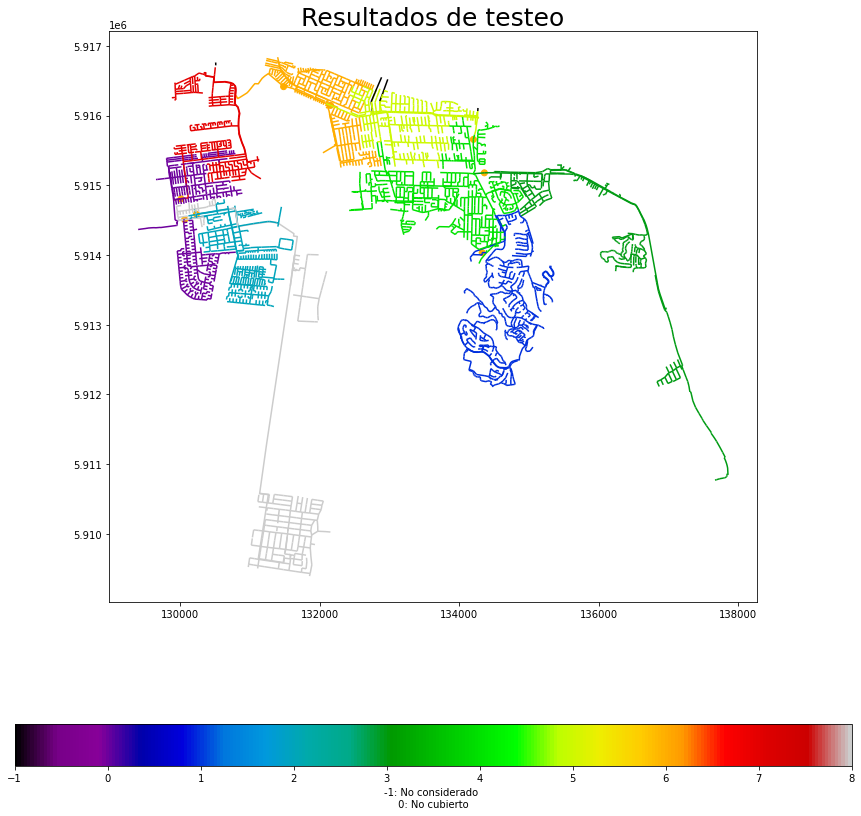

In [6]:
# low = 0; high = N
# while low != high:
#     mid = (low + high) // 2
#     P, sP = greedyAppReduceDynamic(G, W, [0] * N, 8, mid, 1e8)
#     if N - sP < mid:
#         high = mid
#     else:
#         low = mid + 1
        
low = 362
init_P, _ = greedyAppReduceDynamic(G, W, [0] * N, 8, low - 1, 1e8)

plot_sample_no_intersections(G, [0] * N, init_P, geometry, _id)

In [7]:
def simulate_robust(G, W, k2, S, verbose):
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            if verbose:
                print("it,", t, R)
            
            if t == 0:
                P = init_P
            elif R >= 10:
                low = 0; high = R
                while low != high:
                    mid = (low + high) // 2
                    P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, mid, 1e8)
                    if R - sP < mid:
                        high = mid
                    else:
                        low = mid + 1
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, low, 1e8)
                
                if low > 1:
                    P_, sP_ = greedyAppReduceDynamicRobust(G, W, V, root, k2, low - 1, 1e8)
                    
                    if verbose:
                        print("low:", low, R - sP, R - sP_)
                    
                    if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R):
                        P = P_; sP = sP_
            else:
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, 1, 1e8)
    
            if verbose:
                plot_sample_no_intersections(G, V, P, geometry, _id)
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [66]:
iters = simulate_robust(G, W, 5, random.sample(range(N), 50), False)
# simulate_robust(G, W, 5, [510], True)

Result 2347: 3    acc: 3.0
Result 3811: 4    acc: 3.5
Result 1379: 5    acc: 4.0
Result 1862: 5    acc: 4.25
Result 2805: 5    acc: 4.4
Result 52: 6    acc: 4.666666666666667
Result 1233: 5    acc: 4.714285714285714
Result 1787: 5    acc: 4.75
Result 3273: 5    acc: 4.777777777777778
Result 1592: 4    acc: 4.7
Result 3374: 10    acc: 5.181818181818182
Result 369: 5    acc: 5.166666666666667
Result 3161: 5    acc: 5.153846153846154
Result 3796: 4    acc: 5.071428571428571
Result 4153: 4    acc: 5.0
Result 2646: 4    acc: 4.9375
Result 1087: 4    acc: 4.882352941176471
Result 1641: 3    acc: 4.777777777777778
Result 1044: 4    acc: 4.7368421052631575
Result 1210: 4    acc: 4.7
Result 4430: 5    acc: 4.714285714285714
Result 3936: 6    acc: 4.7727272727272725
Result 2704: 6    acc: 4.826086956521739
Result 152: 5    acc: 4.833333333333333
Result 1330: 4    acc: 4.8
Result 3530: 4    acc: 4.769230769230769
Result 796: 5    acc: 4.777777777777778
Result 1789: 6    acc: 4.821428571428571
Res

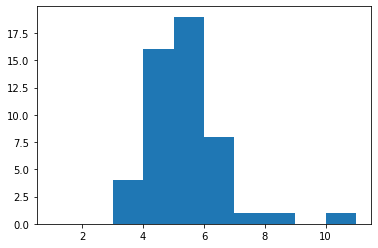

In [67]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [18]:
def greedyAppReduceDynamicRobustFilter(G, W, V_, root, K, limit, wlim, plim):
    
    V = V_.copy(); N = len(V)

    ans = []; tot = 0
    while len(ans) < K:
        
        E_ = []
        
        S = [0 for u in range(N)]
        for v in range(N):
            if not V[v]:
                s = get_size(G, V, v)
                sr, S[v] = get_size_weight_robust(G, W, V, root, v)
                if (sr / s) >= plim:
                    E_.append(v)
        
        maxv = 0; u = -1
        for v in E_:
            s = get_size_precalc_robust(G, S, V, root, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            
            maxv = 0; u = -1
            for v in range(N):
                if not V[v]:
                    s = get_size_precalc_robust(G, S, V, root, v)
                    if s > maxv and s <= limit and S[v] <= wlim:
                        u = v
                        maxv = s
            
            if u == -1:
                break
        
        V, x = visit_robust(G, V, root, u)
        ans.append(u); tot += x
        
    return ans, tot

In [93]:
def simulate_robust_filter(G, W, k2, S, plim, verbose):
    
    map_prev = {}
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            print("                                                           ", end="\r")
            print(f"Search {r}: {t + 1}    now: {R}", end="\r")
            
            if verbose:
                print("it,", t, R)
                
            nn = 0
            for i in range(N):
                if V[i]:
                    nn += 2**i
            
            if t == 0:
                P = init_P
            elif nn in map_prev.keys():
                P = map_prev[nn]
            else:
                if R >= 10:
                    low = 0; high = R
                    while low != high:
                        mid = (low + high) // 2
                        P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, mid, 1e8, plim)
                        if R - sP < mid:
                            high = mid
                        else:
                            low = mid + 1
                    P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, low, 1e8, plim)

                    if low > 1:
                        P_, sP_ = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, low - 1, 1e8, plim)

                        if verbose:
                            print("low:", low, R - sP, R - sP_)

                        if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R):
                            P = P_; sP = sP_
                else:
                    P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, 1, 1e8, plim)

                map_prev[nn] = P
    
            if verbose:
                plot_sample_no_intersections(G, V, P, geometry, _id)
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [111]:
iters = simulate_robust_filter(G, W, 5, range(N), 0, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 5    acc: 4.866666666666666                     
Result 15: 5    acc: 4.875                                 
Result 16: 4    acc: 4.823529411764706  

Result 273: 4    acc: 4.978102189781022                    
Result 274: 4    acc: 4.974545454545455                    
Result 275: 9    acc: 4.989130434782608                    
Result 276: 10    acc: 5.007220216606498                   
Result 277: 10    acc: 5.025179856115108                   
Result 278: 4    acc: 5.021505376344086                    
Result 279: 5    acc: 5.021428571428571                    
Result 280: 4    acc: 5.01779359430605                     
Result 281: 7    acc: 5.024822695035461                    
Result 282: 4    acc: 5.021201413427562                    
Result 283: 6    acc: 5.024647887323944                    
Result 284: 4    acc: 5.021052631578947                    
Result 285: 5    acc: 5.020979020979021                    
Result 286: 6    acc: 5.024390243902439                    
Result 287: 5    acc: 5.024305555555555                    
Result 288: 6    acc: 5.027681660899654                    
Result 289: 6    acc: 5.031034482758621 

Result 410: 3    acc: 5.092457420924574                    
Result 411: 3    acc: 5.087378640776699                    
Result 412: 5    acc: 5.087167070217918                    
Result 413: 6    acc: 5.0893719806763285                   
Result 414: 4    acc: 5.086746987951807                    
Result 415: 5    acc: 5.086538461538462                    
Result 416: 4    acc: 5.083932853717027                    
Result 417: 4    acc: 5.08133971291866                     
Result 418: 10    acc: 5.093078758949881                   
Result 419: 4    acc: 5.09047619047619                     
Result 420: 5    acc: 5.090261282660332                    
Result 421: 4    acc: 5.087677725118484                    
Result 422: 3    acc: 5.08274231678487                     
Result 423: 5    acc: 5.0825471698113205                   
Result 424: 6    acc: 5.084705882352941                    
Result 425: 5    acc: 5.084507042253521                    
Result 426: 4    acc: 5.081967213114754 

Result 548: 5    acc: 5.114754098360656                    
Result 549: 5    acc: 5.114545454545454                    
Result 550: 5    acc: 5.114337568058076                    
Result 551: 5    acc: 5.114130434782608                    
Result 552: 5    acc: 5.113924050632911                    
Result 553: 5    acc: 5.113718411552346                    
Result 554: 5    acc: 5.113513513513514                    
Result 555: 5    acc: 5.113309352517986                    
Result 556: 5    acc: 5.11310592459605                     
Result 557: 5    acc: 5.112903225806452                    
Result 558: 5    acc: 5.112701252236136                    
Result 559: 5    acc: 5.1125                               
Result 560: 5    acc: 5.112299465240642                    
Result 561: 5    acc: 5.112099644128114                    
Result 562: 5    acc: 5.11190053285968                     
Result 563: 4    acc: 5.109929078014185                    
Result 564: 5    acc: 5.109734513274336 

Result 686: 4    acc: 5.029112081513828                    
Result 687: 5    acc: 5.02906976744186                     
Result 688: 4    acc: 5.027576197387518                    
Result 689: 5    acc: 5.027536231884058                    
Result 690: 5    acc: 5.027496382054993                    
Result 691: 5    acc: 5.027456647398844                    
Result 692: 5    acc: 5.027417027417028                    
Result 693: 5    acc: 5.027377521613833                    
Result 694: 5    acc: 5.027338129496403                    
Result 695: 5    acc: 5.027298850574713                    
Result 696: 4    acc: 5.025824964131994                    
Result 697: 5    acc: 5.025787965616046                    
Result 698: 7    acc: 5.028612303290415                    
Result 699: 4    acc: 5.027142857142858                    
Result 700: 4    acc: 5.025677603423681                    
Result 701: 4    acc: 5.024216524216524                    
Result 702: 4    acc: 5.02275960170697  

Result 823: 4    acc: 5.023058252427185                    
Result 824: 4    acc: 5.0218181818181815                   
Result 825: 5    acc: 5.021791767554479                    
Result 826: 5    acc: 5.021765417170496                    
Result 827: 5    acc: 5.021739130434782                    
Result 828: 4    acc: 5.020506634499397                    
Result 829: 6    acc: 5.021686746987951                    
Result 830: 4    acc: 5.020457280385078                    
Result 831: 4    acc: 5.019230769230769                    
Result 832: 4    acc: 5.018007202881153                    
Result 833: 4    acc: 5.016786570743405                    
Result 834: 4    acc: 5.015568862275449                    
Result 835: 4    acc: 5.014354066985646                    
Result 836: 4    acc: 5.013142174432497                    
Result 837: 4    acc: 5.011933174224343                    
Result 838: 4    acc: 5.01072705601907                     
Result 839: 4    acc: 5.0095238095238095

Result 962: 4    acc: 4.959501557632398                    
Result 963: 4    acc: 4.95850622406639                     
Result 964: 4    acc: 4.957512953367876                    
Result 965: 4    acc: 4.956521739130435                    
Result 966: 4    acc: 4.955532574974147                    
Result 967: 4    acc: 4.954545454545454                    
Result 968: 4    acc: 4.953560371517028                    
Result 969: 5    acc: 4.953608247422681                    
Result 970: 4    acc: 4.952626158599382                    
Result 971: 4    acc: 4.95164609053498                     
Result 972: 6    acc: 4.9527235354573484                   
Result 973: 6    acc: 4.953798767967146                    
Result 974: 6    acc: 4.954871794871795                    
Result 975: 6    acc: 4.95594262295082                     
Result 976: 4    acc: 4.95496417604913                     
Result 977: 5    acc: 4.955010224948875                    
Result 978: 5    acc: 4.955056179775281 

Result 1099: 4    acc: 4.933636363636364                   
Result 1100: 4    acc: 4.932788374205268                   
Result 1101: 7    acc: 4.9346642468239565                  
Result 1102: 3    acc: 4.932910244786945                   
Result 1103: 8    acc: 4.9356884057971016                  
Result 1104: 8    acc: 4.938461538461539                   
Result 1105: 4    acc: 4.937613019891501                   
Result 1106: 4    acc: 4.93676603432701                    
Result 1107: 5    acc: 4.936823104693141                   
Result 1108: 5    acc: 4.93688007213706                    
Result 1109: 4    acc: 4.936036036036036                   
Result 1110: 4    acc: 4.935193519351936                   
Result 1111: 4    acc: 4.934352517985611                   
Result 1112: 6    acc: 4.935309973045822                   
Result 1113: 4    acc: 4.934470377019749                   
Result 1114: 4    acc: 4.933632286995516                   
Result 1115: 4    acc: 4.932795698924731

Result 1236: 5    acc: 4.894907033144705                   
Result 1237: 5    acc: 4.894991922455573                   
Result 1238: 5    acc: 4.895076674737692                   
Result 1239: 6    acc: 4.8959677419354835                  
Result 1240: 5    acc: 4.896051571313457                   
Result 1241: 5    acc: 4.896135265700483                   
Result 1242: 4    acc: 4.8954143201930815                  
Result 1243: 4    acc: 4.894694533762058                   
Result 1244: 5    acc: 4.894779116465863                   
Result 1245: 4    acc: 4.89406099518459                    
Result 1246: 4    acc: 4.893344025661587                   
Result 1247: 4    acc: 4.892628205128205                   
Result 1248: 5    acc: 4.89271417133707                    
Result 1249: 5    acc: 4.8928                              
Result 1250: 5    acc: 4.892885691446843                   
Result 1251: 5    acc: 4.89297124600639                    
Result 1252: 5    acc: 4.893056664006385

Result 1374: 5    acc: 4.8785454545454545                  
Result 1375: 5    acc: 4.878633720930233                   
Result 1376: 4    acc: 4.877995642701525                   
Result 1377: 5    acc: 4.878084179970973                   
Result 1378: 5    acc: 4.878172588832487                   
Result 1379: 5    acc: 4.878260869565217                   
Result 1380: 5    acc: 4.878349022447502                   
Result 1381: 5    acc: 4.878437047756874                   
Result 1382: 5    acc: 4.8785249457700655                  
Result 1383: 5    acc: 4.878612716763006                   
Result 1384: 5    acc: 4.87870036101083                    
Result 1385: 5    acc: 4.878787878787879                   
Result 1386: 5    acc: 4.8788752703677                     
Result 1387: 4    acc: 4.878242074927954                   
Result 1388: 4    acc: 4.8776097912167025                  
Result 1389: 5    acc: 4.877697841726619                   
Result 1390: 5    acc: 4.877785765636233

Result 1512: 5    acc: 4.862524785194977                   
Result 1513: 5    acc: 4.862615587846763                   
Result 1514: 5    acc: 4.862706270627062                   
Result 1515: 5    acc: 4.862796833773087                   
Result 1516: 5    acc: 4.862887277521424                   
Result 1517: 5    acc: 4.862977602108037                   
Result 1518: 5    acc: 4.863067807768268                   
Result 1519: 5    acc: 4.863157894736842                   
Result 1520: 5    acc: 4.863247863247863                   
Result 1521: 5    acc: 4.863337713534823                   
Result 1522: 5    acc: 4.863427445830598                   
Result 1523: 5    acc: 4.863517060367454                   
Result 1524: 5    acc: 4.863606557377049                   
Result 1525: 5    acc: 4.863695937090433                   
Result 1526: 5    acc: 4.863785199738048                   
Result 1527: 5    acc: 4.863874345549738                   
Result 1528: 5    acc: 4.863963374754742

Result 1786: 5    acc: 4.866815892557359                   
Result 1787: 5    acc: 4.866890380313199                   
Result 1788: 5    acc: 4.866964784795975                   
Result 1789: 4    acc: 4.866480446927374                   
Result 1790: 4    acc: 4.865996649916248                   
Result 1791: 4    acc: 4.865513392857143                   
Result 1792: 4    acc: 4.865030674846626                   
Result 1793: 4    acc: 4.864548494983278                   
Result 1794: 6    acc: 4.865181058495822                   
Result 1795: 6    acc: 4.8658129175946545                  
Result 1796: 3    acc: 4.864774624373957                   
Result 1797: 4    acc: 4.864293659621802                   
Result 1798: 4    acc: 4.863813229571984                   
Result 1799: 5    acc: 4.863888888888889                   
Result 1800: 5    acc: 4.863964464186563                   
Result 1801: 5    acc: 4.864039955604883                   
Result 1802: 5    acc: 4.864115363283417

Result 2059: 6    acc: 4.8330097087378645                  
Result 2060: 4    acc: 4.832605531295488                   
Result 2061: 4    acc: 4.832201745877788                   
Result 2062: 6    acc: 4.832767813863306                   
Result 2063: 6    acc: 4.833333333333333                   
Result 2064: 6    acc: 4.8338983050847455                  
Result 2065: 6    acc: 4.834462729912875                   
Result 2066: 6    acc: 4.835026608611514                   
Result 2067: 6    acc: 4.835589941972921                   
Result 2068: 6    acc: 4.83615273078782                    
Result 2069: 5    acc: 4.836231884057971                   
Result 2070: 5    acc: 4.83631096088846                    
Result 2071: 5    acc: 4.836389961389961                   
Result 2072: 4    acc: 4.835986493005306                   
Result 2073: 4    acc: 4.835583413693346                   
Result 2074: 5    acc: 4.835662650602409                   
Result 2075: 5    acc: 4.835741811175337

Result 2196: 5    acc: 4.798361401911698                   
Result 2197: 5    acc: 4.798453139217471                   
Result 2198: 5    acc: 4.798544793087768                   
Result 2199: 5    acc: 4.798636363636364                   
Result 2200: 5    acc: 4.798727850976829                   
Result 2201: 5    acc: 4.798819255222525                   
Result 2202: 5    acc: 4.798910576486609                   
Result 2203: 5    acc: 4.799001814882033                   
Result 2204: 5    acc: 4.799092970521542                   
Result 2205: 5    acc: 4.799184043517679                   
Result 2206: 5    acc: 4.799275033982782                   
Result 2207: 5    acc: 4.799365942028985                   
Result 2208: 5    acc: 4.799456767768221                   
Result 2209: 5    acc: 4.799547511312217                   
Result 2210: 5    acc: 4.799638172772501                   
Result 2211: 5    acc: 4.799728752260398                   
Result 2212: 5    acc: 4.799819249887031

Result 2333: 4    acc: 4.7909168808911735                  
Result 2334: 6    acc: 4.791434689507494                   
Result 2335: 6    acc: 4.79195205479452                    
Result 2336: 4    acc: 4.791613179289688                   
Result 2337: 4    acc: 4.791274593669804                   
Result 2338: 4    acc: 4.790936297563061                   
Result 2339: 4    acc: 4.7905982905982905                  
Result 2340: 4    acc: 4.790260572404955                   
Result 2341: 4    acc: 4.789923142613151                   
Result 2342: 4    acc: 4.789586000853607                   
Result 2343: 4    acc: 4.789249146757679                   
Result 2344: 4    acc: 4.788912579957356                   
Result 2345: 4    acc: 4.788576300085252                   
Result 2346: 4    acc: 4.788240306774606                   
Result 2347: 4    acc: 4.787904599659284                   
Result 2348: 5    acc: 4.787994891443168                   
Result 2349: 5    acc: 4.788085106382979

Result 2471: 4    acc: 4.835760517799352                   
Result 2472: 4    acc: 4.835422563687828                   
Result 2473: 4    acc: 4.835084882780921                   
Result 2474: 4    acc: 4.834747474747474                   
Result 2475: 4    acc: 4.834410339256866                   
Result 2476: 4    acc: 4.8340734759790065                  
Result 2477: 4    acc: 4.833736884584342                   
Result 2478: 4    acc: 4.833400564743848                   
Result 2479: 4    acc: 4.833064516129032                   
Result 2480: 6    acc: 4.833534864973801                   
Result 2481: 6    acc: 4.834004834810637                   
Result 2482: 6    acc: 4.834474426097462                   
Result 2483: 6    acc: 4.834943639291465                   
Result 2484: 6    acc: 4.835412474849095                   
Result 2485: 6    acc: 4.835880933226066                   
Result 2486: 6    acc: 4.836349014877363                   
Result 2487: 6    acc: 4.836816720257235

Result 2609: 5    acc: 4.823371647509578                   
Result 2610: 5    acc: 4.823439295289162                   
Result 2611: 5    acc: 4.823506891271057                   
Result 2612: 5    acc: 4.823574435514734                   
Result 2613: 6    acc: 4.824024483550115                   
Result 2614: 8    acc: 4.825239005736138                   
Result 2615: 7    acc: 4.826070336391437                   
Result 2616: 7    acc: 4.826901031715705                   
Result 2617: 8    acc: 4.828113063407181                   
Result 2618: 8    acc: 4.829324169530355                   
Result 2619: 6    acc: 4.829770992366412                   
Result 2620: 8    acc: 4.830980541777947                   
Result 2621: 8    acc: 4.832189168573608                   
Result 2622: 8    acc: 4.833396873808616                   
Result 2623: 8    acc: 4.834603658536586                   
Result 2624: 6    acc: 4.835047619047619                   
Result 2625: 6    acc: 4.835491241431836

Result 2747: 5    acc: 4.841703056768559                   
Result 2748: 5    acc: 4.8417606402328115                  
Result 2749: 5    acc: 4.841818181818182                   
Result 2750: 5    acc: 4.841875681570338                   
Result 2751: 9    acc: 4.843386627906977                   
Result 2752: 8    acc: 4.844533236469307                   
Result 2753: 8    acc: 4.845679012345679                   
Result 2754: 5    acc: 4.84573502722323                    
Result 2755: 8    acc: 4.846879535558781                   
Result 2756: 8    acc: 4.848023213638013                   
Result 2757: 8    acc: 4.849166062364032                   
Result 2758: 8    acc: 4.850308082638637                   
Result 2759: 7    acc: 4.851086956521739                   
Result 2760: 8    acc: 4.8522274538210795                  
Result 2761: 5    acc: 4.85228095582911                    
Result 2762: 5    acc: 4.852334419109663                   
Result 2763: 4    acc: 4.852026049204052

Result 3020: 5    acc: 4.866269447202913                   
Result 3021: 5    acc: 4.866313699536731                   
Result 3022: 5    acc: 4.86635792259345                    
Result 3023: 5    acc: 4.866402116402116                   
Result 3024: 5    acc: 4.8664462809917355                  
Result 3025: 5    acc: 4.866490416391276                   
Result 3026: 5    acc: 4.866534522629666                   
Result 3027: 5    acc: 4.866578599735799                   
Result 3028: 5    acc: 4.866622647738527                   
Result 3029: 5    acc: 4.866666666666666                   
Result 3030: 5    acc: 4.866710656548994                   
Result 3031: 5    acc: 4.866754617414248                   
Result 3032: 5    acc: 4.866798549291131                   
Result 3033: 5    acc: 4.866842452208306                   
Result 3034: 5    acc: 4.866886326194399                   
Result 3035: 5    acc: 4.866930171277997                   
Result 3036: 5    acc: 4.866973987487652

Result 3159: 4    acc: 4.931962025316456                   
Result 3160: 4    acc: 4.931667193925973                   
Result 3161: 5    acc: 4.93168880455408                    
Result 3162: 5    acc: 4.931710401517547                   
Result 3163: 5    acc: 4.93173198482933                    
Result 3164: 5    acc: 4.93175355450237                    
Result 3165: 4    acc: 4.931459254579911                   
Result 3166: 5    acc: 4.93148089674771                    
Result 3167: 4    acc: 4.9311868686868685                  
Result 3168: 4    acc: 4.930893026191227                   
Result 3169: 5    acc: 4.930914826498423                   
Result 3170: 4    acc: 4.930621255124566                   
Result 3171: 4    acc: 4.930327868852459                   
Result 3172: 4    acc: 4.930034667507091                   
Result 3173: 4    acc: 4.929741650913674                   
Result 3174: 4    acc: 4.9294488188976375                  
Result 3175: 4    acc: 4.929156171284634

Result 3431: 5    acc: 5.02534965034965                    
Result 3432: 8    acc: 5.026216137489077                   
Result 3433: 5    acc: 5.026208503203262                   
Result 3434: 5    acc: 5.026200873362446                   
Result 3435: 5    acc: 5.026193247962747                   
Result 3436: 5    acc: 5.026185627000291                   
Result 3437: 6    acc: 5.026468877254217                   
Result 3438: 6    acc: 5.026751962779878                   
Result 3439: 5    acc: 5.026744186046511                   
Result 3440: 5    acc: 5.026736413833188                   
Result 3441: 5    acc: 5.026728646135967                   
Result 3442: 5    acc: 5.026720882950915                   
Result 3443: 6    acc: 5.0270034843205575                  
Result 3444: 6    acc: 5.027285921625544                   
Result 3445: 7    acc: 5.027858386535113                   
Result 3446: 7    acc: 5.028430519292138                   
Result 3447: 7    acc: 5.029002320185615

Result 3704: 4    acc: 5.053711201079622                   
Result 3705: 4    acc: 5.053426875337291                   
Result 3706: 4    acc: 5.053142702994335                   
Result 3707: 4    acc: 5.052858683926645                   
Result 3708: 4    acc: 5.052574818010245                   
Result 3709: 4    acc: 5.052291105121294                   
Result 3710: 4    acc: 5.052007545136082                   
Result 3711: 4    acc: 5.051724137931035                   
Result 3712: 4    acc: 5.05144088338271                    
Result 3713: 4    acc: 5.051157781367798                   
Result 3714: 4    acc: 5.050874831763123                   
Result 3715: 4    acc: 5.05059203444564                    
Result 3716: 4    acc: 5.05030938929244                    
Result 3717: 5    acc: 5.050295857988166                   
Result 3718: 5    acc: 5.050282333960742                   
Result 3719: 5    acc: 5.050268817204301                   
Result 3720: 5    acc: 5.05025530771298 

Result 3978: 5    acc: 5.065091731590852                   
Result 3979: 6    acc: 5.065326633165829                   
Result 3980: 5    acc: 5.065310223561919                   
Result 3981: 5    acc: 5.0652938221999                     
Result 3982: 5    acc: 5.0652774290735625                  
Result 3983: 5    acc: 5.065261044176707                   
Result 3984: 5    acc: 5.065244667503137                   
Result 3985: 5    acc: 5.065228299046663                   
Result 3986: 5    acc: 5.065211938801103                   
Result 3987: 5    acc: 5.0651955867602805                  
Result 3988: 5    acc: 5.065179242918025                   
Result 3989: 6    acc: 5.065413533834587                   
Result 3990: 5    acc: 5.06539714357304                    
Result 3991: 6    acc: 5.06563126252505                    
Result 3992: 5    acc: 5.065614825945405                   
Result 3993: 5    acc: 5.0655983975963945                  
Result 3994: 5    acc: 5.065581977471839

Result 4116: 7    acc: 5.069468059266456                   
Result 4117: 4    acc: 5.069208353569694                   
Result 4118: 4    acc: 5.068948773974266                   
Result 4119: 4    acc: 5.06868932038835                    
Result 4120: 4    acc: 5.068429992720214                   
Result 4121: 4    acc: 5.068170790878215                   
Result 4122: 4    acc: 5.067911714770798                   
Result 4123: 5    acc: 5.067895247332687                   
Result 4124: 8    acc: 5.068606060606061                   
Result 4125: 5    acc: 5.06858943286476                    
Result 4126: 5    acc: 5.068572813181488                   
Result 4127: 5    acc: 5.068556201550388                   
Result 4128: 5    acc: 5.068539597965609                   
Result 4129: 6    acc: 5.068765133171913                   
Result 4130: 5    acc: 5.068748487049141                   
Result 4131: 5    acc: 5.068731848983543                   
Result 4132: 5    acc: 5.068715218969272

Result 4253: 5    acc: 5.076398683591914                   
Result 4254: 6    acc: 5.076615746180964                   
Result 4255: 5    acc: 5.076597744360902                   
Result 4256: 5    acc: 5.076579750998356                   
Result 4257: 4    acc: 5.076326914044152                   
Result 4258: 4    acc: 5.076074195820615                   
Result 4259: 4    acc: 5.075821596244132                   
Result 4260: 4    acc: 5.075569115231167                   
Result 4261: 7    acc: 5.076020647583294                   
Result 4262: 5    acc: 5.076002814919071                   
Result 4263: 5    acc: 5.075984990619137                   
Result 4264: 5    acc: 5.075967174677609                   
Result 4265: 6    acc: 5.076183778715424                   
Result 4266: 6    acc: 5.076400281228029                   
Result 4267: 6    acc: 5.076616682286786                   
Result 4268: 4    acc: 5.076364488170531                   
Result 4269: 4    acc: 5.076112412177986

Result 4390: 5    acc: 5.104759735823275                   
Result 4391: 5    acc: 5.104735883424408                   
Result 4392: 5    acc: 5.104712041884817                   
Result 4393: 4    acc: 5.104460628129267                   
Result 4394: 5    acc: 5.104436860068259                   
Result 4395: 5    acc: 5.104413102820746                   
Result 4396: 5    acc: 5.104389356379349                   
Result 4397: 4    acc: 5.104138244656662                   
Result 4398: 4    acc: 5.103887247101614                   
Result 4399: 3    acc: 5.103409090909091                   
Result 4400: 4    acc: 5.103158373097023                   
Result 4401: 4    acc: 5.10290776919582                    
Result 4402: 5    acc: 5.102884397002044                   
Result 4403: 5    acc: 5.102861035422343                   
Result 4404: 4    acc: 5.10261066969353                    
Result 4405: 6    acc: 5.1028143440762594                  
Result 4406: 6    acc: 5.103017926026776

Result 4527: 6    acc: 5.09606890459364                    
Result 4528: 6    acc: 5.096268491940826                   
Result 4529: 6    acc: 5.096467991169978                   
Result 4530: 6    acc: 5.096667402339439                   
Result 4531: 6    acc: 5.096866725507502                   
Result 4532: 6    acc: 5.097065960732407                   
Result 4533: 6    acc: 5.097265108072342                   
Result 4534: 6    acc: 5.097464167585446                   
Result 4535: 6    acc: 5.097663139329806                   
Result 4536: 6    acc: 5.097862023363456                   
Result 4537: 5    acc: 5.097840458351697                   
Result 4538: 5    acc: 5.097818902842036                   
Result 4539: 5    acc: 5.097797356828194                   
Result 4540: 5    acc: 5.097775820303898                   
Result 4541: 5    acc: 5.09775429326288                    
Result 4542: 5    acc: 5.097732775698877                   
Result 4543: 5    acc: 5.097711267605634

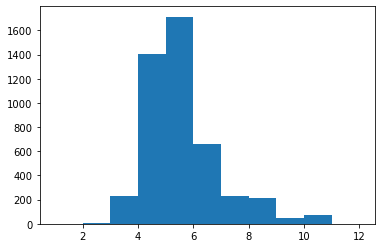

In [112]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [113]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.2, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 5    acc: 4.866666666666666                     
Result 15: 5    acc: 4.875                                 
Result 16: 4    acc: 4.823529411764706  

Result 273: 4    acc: 4.974452554744525                    
Result 274: 4    acc: 4.970909090909091                    
Result 275: 9    acc: 4.9855072463768115                   
Result 276: 11    acc: 5.007220216606498                   
Result 277: 11    acc: 5.028776978417266                   
Result 278: 6    acc: 5.032258064516129                    
Result 279: 5    acc: 5.0321428571428575                   
Result 280: 4    acc: 5.02846975088968                     
Result 281: 7    acc: 5.035460992907802                    
Result 282: 3    acc: 5.028268551236749                    
Result 283: 6    acc: 5.03169014084507                     
Result 284: 4    acc: 5.028070175438597                    
Result 285: 5    acc: 5.027972027972028                    
Result 286: 6    acc: 5.031358885017422                    
Result 287: 5    acc: 5.03125                              
Result 288: 6    acc: 5.034602076124568                    
Result 289: 6    acc: 5.037931034482758 

Result 410: 3    acc: 5.111922141119221                    
Result 411: 3    acc: 5.106796116504855                    
Result 412: 5    acc: 5.106537530266344                    
Result 413: 6    acc: 5.108695652173913                    
Result 414: 4    acc: 5.106024096385542                    
Result 415: 5    acc: 5.105769230769231                    
Result 416: 4    acc: 5.103117505995204                    
Result 417: 4    acc: 5.100478468899522                    
Result 418: 9    acc: 5.109785202863962                    
Result 419: 4    acc: 5.107142857142857                    
Result 420: 5    acc: 5.10688836104513                     
Result 421: 4    acc: 5.104265402843602                    
Result 422: 3    acc: 5.099290780141844                    
Result 423: 6    acc: 5.101415094339623                    
Result 424: 6    acc: 5.103529411764706                    
Result 425: 5    acc: 5.103286384976526                    
Result 426: 4    acc: 5.100702576112412 

Result 548: 5    acc: 5.120218579234972                    
Result 549: 5    acc: 5.12                                 
Result 550: 5    acc: 5.11978221415608                     
Result 551: 5    acc: 5.119565217391305                    
Result 552: 5    acc: 5.119349005424954                    
Result 553: 5    acc: 5.11913357400722                     
Result 554: 5    acc: 5.118918918918919                    
Result 555: 5    acc: 5.118705035971223                    
Result 556: 5    acc: 5.118491921005386                    
Result 557: 5    acc: 5.118279569892473                    
Result 558: 5    acc: 5.1180679785330945                   
Result 559: 5    acc: 5.117857142857143                    
Result 560: 5    acc: 5.117647058823529                    
Result 561: 5    acc: 5.117437722419929                    
Result 562: 5    acc: 5.1172291296625225                   
Result 563: 4    acc: 5.115248226950355                    
Result 564: 5    acc: 5.115044247787611 

Result 685: 4    acc: 5.034985422740525                    
Result 686: 4    acc: 5.033478893740902                    
Result 687: 5    acc: 5.03343023255814                     
Result 688: 4    acc: 5.031930333817126                    
Result 689: 5    acc: 5.0318840579710145                   
Result 690: 5    acc: 5.031837916063676                    
Result 691: 5    acc: 5.031791907514451                    
Result 692: 5    acc: 5.031746031746032                    
Result 693: 5    acc: 5.031700288184438                    
Result 694: 5    acc: 5.031654676258992                    
Result 695: 5    acc: 5.031609195402299                    
Result 696: 4    acc: 5.03012912482066                     
Result 697: 5    acc: 5.030085959885387                    
Result 698: 7    acc: 5.032904148783977                    
Result 699: 4    acc: 5.031428571428571                    
Result 700: 4    acc: 5.029957203994294                    
Result 701: 4    acc: 5.028490028490029 

Result 823: 4    acc: 5.032766990291262                    
Result 824: 4    acc: 5.031515151515151                    
Result 825: 5    acc: 5.031476997578692                    
Result 826: 5    acc: 5.031438935912938                    
Result 827: 5    acc: 5.031400966183575                    
Result 828: 4    acc: 5.030156815440289                    
Result 829: 6    acc: 5.031325301204819                    
Result 830: 4    acc: 5.030084235860409                    
Result 831: 4    acc: 5.028846153846154                    
Result 832: 4    acc: 5.0276110444177675                   
Result 833: 4    acc: 5.026378896882494                    
Result 834: 4    acc: 5.025149700598803                    
Result 835: 4    acc: 5.023923444976076                    
Result 836: 4    acc: 5.022700119474313                    
Result 837: 4    acc: 5.021479713603819                    
Result 838: 4    acc: 5.020262216924911                    
Result 839: 4    acc: 5.019047619047619 

Result 960: 4    acc: 4.975026014568158                    
Result 961: 4    acc: 4.974012474012474                    
Result 962: 4    acc: 4.973001038421599                    
Result 963: 4    acc: 4.971991701244813                    
Result 964: 4    acc: 4.97098445595855                     
Result 965: 4    acc: 4.969979296066253                    
Result 966: 4    acc: 4.968976215098242                    
Result 967: 4    acc: 4.9679752066115705                   
Result 968: 4    acc: 4.966976264189887                    
Result 969: 5    acc: 4.967010309278351                    
Result 970: 4    acc: 4.966014418125644                    
Result 971: 4    acc: 4.965020576131687                    
Result 972: 6    acc: 4.966084275436794                    
Result 973: 6    acc: 4.967145790554415                    
Result 974: 6    acc: 4.9682051282051285                   
Result 975: 6    acc: 4.969262295081967                    
Result 976: 4    acc: 4.968270214943705 

Result 1233: 5    acc: 4.905996758508914                   
Result 1234: 5    acc: 4.906072874493927                   
Result 1235: 5    acc: 4.906148867313916                   
Result 1236: 5    acc: 4.906224737267583                   
Result 1237: 5    acc: 4.906300484652665                   
Result 1238: 5    acc: 4.90637610976594                    
Result 1239: 6    acc: 4.907258064516129                   
Result 1240: 5    acc: 4.907332796132152                   
Result 1241: 5    acc: 4.907407407407407                   
Result 1242: 4    acc: 4.906677393403057                   
Result 1243: 4    acc: 4.905948553054662                   
Result 1244: 5    acc: 4.906024096385543                   
Result 1245: 4    acc: 4.90529695024077                    
Result 1246: 4    acc: 4.904570970328789                   
Result 1247: 4    acc: 4.903846153846154                   
Result 1248: 5    acc: 4.903923138510809                   
Result 1249: 5    acc: 4.904            

Result 1505: 5    acc: 4.872509960159363                   
Result 1506: 5    acc: 4.872594558725946                   
Result 1507: 5    acc: 4.872679045092839                   
Result 1508: 5    acc: 4.8727634194831015                  
Result 1509: 5    acc: 4.872847682119206                   
Result 1510: 4    acc: 4.872270019854401                   
Result 1511: 4    acc: 4.871693121693122                   
Result 1512: 5    acc: 4.871777924653007                   
Result 1513: 5    acc: 4.871862615587847                   
Result 1514: 5    acc: 4.871947194719472                   
Result 1515: 5    acc: 4.872031662269129                   
Result 1516: 5    acc: 4.872116018457482                   
Result 1517: 5    acc: 4.872200263504611                   
Result 1518: 5    acc: 4.87228439763002                    
Result 1519: 5    acc: 4.872368421052632                   
Result 1520: 5    acc: 4.872452333990796                   
Result 1521: 5    acc: 4.872536136662286

Result 1777: 4    acc: 4.8796400449943755                  
Result 1778: 4    acc: 4.879145587408656                   
Result 1779: 4    acc: 4.878651685393258                   
Result 1780: 4    acc: 4.878158338012352                   
Result 1781: 4    acc: 4.877665544332211                   
Result 1782: 5    acc: 4.877734155916994                   
Result 1783: 5    acc: 4.87780269058296                    
Result 1784: 5    acc: 4.877871148459384                   
Result 1785: 5    acc: 4.877939529675252                   
Result 1786: 5    acc: 4.878007834359261                   
Result 1787: 5    acc: 4.878076062639821                   
Result 1788: 5    acc: 4.8781442146450535                  
Result 1789: 4    acc: 4.877653631284916                   
Result 1790: 4    acc: 4.877163595756561                   
Result 1791: 4    acc: 4.876674107142857                   
Result 1792: 4    acc: 4.876185164528723                   
Result 1793: 4    acc: 4.875696767001115

Result 2050: 4    acc: 4.8405655777669425                  
Result 2051: 4    acc: 4.840155945419103                   
Result 2052: 4    acc: 4.839746712128592                   
Result 2053: 4    acc: 4.839337877312561                   
Result 2054: 6    acc: 4.839902676399027                   
Result 2055: 11    acc: 4.842898832684825                  
Result 2056: 3    acc: 4.842002916869227                   
Result 2057: 5    acc: 4.8420796890184645                  
Result 2058: 6    acc: 4.842642059252064                   
Result 2059: 6    acc: 4.843203883495145                   
Result 2060: 4    acc: 4.842794759825328                   
Result 2061: 4    acc: 4.842386032977692                   
Result 2062: 6    acc: 4.8429471643238005                  
Result 2063: 6    acc: 4.8435077519379846                  
Result 2064: 6    acc: 4.84406779661017                    
Result 2065: 6    acc: 4.844627299128751                   
Result 2066: 6    acc: 4.8451862602806  

Result 2324: 4    acc: 4.8025806451612905                  
Result 2325: 4    acc: 4.802235597592434                   
Result 2326: 4    acc: 4.801890846583584                   
Result 2327: 4    acc: 4.801546391752577                   
Result 2328: 4    acc: 4.8012022327179045                  
Result 2329: 4    acc: 4.800858369098712                   
Result 2330: 4    acc: 4.800514800514801                   
Result 2331: 4    acc: 4.800171526586621                   
Result 2332: 4    acc: 4.799828546935276                   
Result 2333: 4    acc: 4.799485861182519                   
Result 2334: 6    acc: 4.8                                 
Result 2335: 6    acc: 4.800513698630137                   
Result 2336: 4    acc: 4.800171159606333                   
Result 2337: 4    acc: 4.7998289136013685                  
Result 2338: 4    acc: 4.799486960239419                   
Result 2339: 4    acc: 4.799145299145299                   
Result 2340: 4    acc: 4.798803929944468

Result 2462: 4    acc: 4.846122614697523                   
Result 2463: 6    acc: 4.846590909090909                   
Result 2464: 4    acc: 4.846247464503042                   
Result 2465: 4    acc: 4.845904298459043                   
Result 2466: 4    acc: 4.845561410620187                   
Result 2467: 4    acc: 4.845218800648298                   
Result 2468: 4    acc: 4.844876468205752                   
Result 2469: 4    acc: 4.844534412955466                   
Result 2470: 4    acc: 4.8441926345609065                  
Result 2471: 4    acc: 4.843851132686084                   
Result 2472: 4    acc: 4.843509906995552                   
Result 2473: 4    acc: 4.843168957154406                   
Result 2474: 4    acc: 4.8428282828282825                  
Result 2475: 4    acc: 4.8424878836833605                  
Result 2476: 4    acc: 4.8421477593863544                  
Result 2477: 4    acc: 4.84180790960452                    
Result 2478: 4    acc: 4.841468334005647

Result 2600: 5    acc: 4.831218762014609                   
Result 2601: 5    acc: 4.831283627978478                   
Result 2602: 5    acc: 4.831348444102958                   
Result 2603: 5    acc: 4.831413210445469                   
Result 2604: 4    acc: 4.8310940499040305                  
Result 2605: 5    acc: 4.831158864159631                   
Result 2606: 5    acc: 4.831223628691983                   
Result 2607: 5    acc: 4.831288343558282                   
Result 2608: 5    acc: 4.831353008815638                   
Result 2609: 5    acc: 4.831417624521073                   
Result 2610: 5    acc: 4.831482190731521                   
Result 2611: 5    acc: 4.831546707503828                   
Result 2612: 5    acc: 4.831611174894757                   
Result 2613: 7    acc: 4.832440703902066                   
Result 2614: 7    acc: 4.8332695984703635                  
Result 2615: 6    acc: 4.833715596330276                   
Result 2616: 8    acc: 4.834925487199083

Result 2739: 4    acc: 4.84963503649635                    
Result 2740: 4    acc: 4.849325063845312                   
Result 2741: 6    acc: 4.849744711889132                   
Result 2742: 6    acc: 4.850164053955523                   
Result 2743: 4    acc: 4.849854227405248                   
Result 2744: 5    acc: 4.849908925318761                   
Result 2745: 4    acc: 4.849599417334304                   
Result 2746: 5    acc: 4.849654168183473                   
Result 2747: 5    acc: 4.8497088791848615                  
Result 2748: 5    acc: 4.849763550381957                   
Result 2749: 5    acc: 4.849818181818182                   
Result 2750: 5    acc: 4.849872773536895                   
Result 2751: 10    acc: 4.851744186046512                  
Result 2752: 8    acc: 4.852887758808572                   
Result 2753: 8    acc: 4.8540305010893245                  
Result 2754: 5    acc: 4.854083484573502                   
Result 2755: 8    acc: 4.855224963715529

Result 2877: 4    acc: 4.873175816539264                   
Result 2878: 4    acc: 4.872872525182355                   
Result 2879: 8    acc: 4.873958333333333                   
Result 2880: 8    acc: 4.8750433877126                     
Result 2881: 8    acc: 4.876127689104789                   
Result 2882: 8    acc: 4.8772112382934445                  
Result 2883: 8    acc: 4.8782940360610265                  
Result 2884: 8    acc: 4.879376083188908                   
Result 2885: 8    acc: 4.88045738045738                    
Result 2886: 8    acc: 4.881537928645653                   
Result 2887: 8    acc: 4.882617728531856                   
Result 2888: 8    acc: 4.883696780893042                   
Result 2889: 8    acc: 4.88477508650519                    
Result 2890: 8    acc: 4.885852646143203                   
Result 2891: 8    acc: 4.886929460580913                   
Result 2892: 8    acc: 4.888005530591082                   
Result 2893: 8    acc: 4.889080856945404

Result 3015: 3    acc: 4.8753315649867375                  
Result 3016: 4    acc: 4.87504143188598                    
Result 3017: 5    acc: 4.875082836315441                   
Result 3018: 5    acc: 4.875124213315668                   
Result 3019: 5    acc: 4.8751655629139075                  
Result 3020: 5    acc: 4.875206885137372                   
Result 3021: 5    acc: 4.875248180013236                   
Result 3022: 5    acc: 4.87528944756864                    
Result 3023: 5    acc: 4.8753306878306875                  
Result 3024: 5    acc: 4.875371900826447                   
Result 3025: 5    acc: 4.875413086582948                   
Result 3026: 5    acc: 4.875454245127188                   
Result 3027: 5    acc: 4.875495376486129                   
Result 3028: 5    acc: 4.875536480686695                   
Result 3029: 5    acc: 4.875577557755776                   
Result 3030: 5    acc: 4.875618607720225                   
Result 3031: 5    acc: 4.87565963060686 

Result 3288: 7    acc: 4.95621769534813                    
Result 3289: 6    acc: 4.956534954407295                   
Result 3290: 7    acc: 4.9571558796718325                  
Result 3291: 6    acc: 4.957472660996355                   
Result 3292: 7    acc: 4.958092924385059                   
Result 3293: 6    acc: 4.958409228901032                   
Result 3294: 7    acc: 4.959028831562974                   
Result 3295: 7    acc: 4.959648058252427                   
Result 3296: 7    acc: 4.960266909311495                   
Result 3297: 7    acc: 4.960885385081868                   
Result 3298: 7    acc: 4.96150348590482                    
Result 3299: 7    acc: 4.962121212121212                   
Result 3300: 7    acc: 4.962738564071493                   
Result 3301: 7    acc: 4.9633555420957                     
Result 3302: 7    acc: 4.963972146533455                   
Result 3303: 7    acc: 4.964588377723971                   
Result 3304: 7    acc: 4.965204236006051

Result 3425: 4    acc: 5.039696438995914                   
Result 3426: 4    acc: 5.039393055150277                   
Result 3427: 6    acc: 5.039673278879813                   
Result 3428: 6    acc: 5.039953339165938                   
Result 3429: 5    acc: 5.039941690962099                   
Result 3430: 5    acc: 5.039930049548237                   
Result 3431: 5    acc: 5.039918414918415                   
Result 3432: 8    acc: 5.040780658316342                   
Result 3433: 5    acc: 5.040768782760629                   
Result 3434: 5    acc: 5.04075691411936                    
Result 3435: 5    acc: 5.040745052386496                   
Result 3436: 5    acc: 5.040733197556008                   
Result 3437: 6    acc: 5.041012216404886                   
Result 3438: 6    acc: 5.041291072986334                   
Result 3439: 5    acc: 5.041279069767442                   
Result 3440: 5    acc: 5.041267073525138                   
Result 3441: 5    acc: 5.041255084253341

Result 3562: 4    acc: 5.057535784451305                   
Result 3563: 4    acc: 5.057239057239057                   
Result 3564: 5    acc: 5.057223001402525                   
Result 3565: 6    acc: 5.057487380818845                   
Result 3566: 8    acc: 5.058312307261003                   
Result 3567: 8    acc: 5.059136771300448                   
Result 3568: 8    acc: 5.059960773325861                   
Result 3569: 6    acc: 5.060224089635854                   
Result 3570: 6    acc: 5.060487258471016                   
Result 3571: 5    acc: 5.0604703247480405                  
Result 3572: 6    acc: 5.060733277357962                   
Result 3573: 6    acc: 5.0609960828203695                  
Result 3574: 6    acc: 5.061258741258741                   
Result 3575: 6    acc: 5.06152125279642                    
Result 3576: 6    acc: 5.061783617556611                   
Result 3577: 5    acc: 5.061766349916154                   
Result 3578: 6    acc: 5.062028499580888

Result 3700: 3    acc: 5.06863009997298                    
Result 3701: 3    acc: 5.06807131280389                    
Result 3702: 5    acc: 5.0680529300567105                  
Result 3703: 5    acc: 5.068034557235421                   
Result 3704: 4    acc: 5.06774628879892                    
Result 3705: 4    acc: 5.0674581759309225                  
Result 3706: 4    acc: 5.06717021850553                    
Result 3707: 4    acc: 5.06688241639698                    
Result 3708: 4    acc: 5.066594769479644                   
Result 3709: 4    acc: 5.066307277628033                   
Result 3710: 4    acc: 5.066019940716788                   
Result 3711: 4    acc: 5.0657327586206895                  
Result 3712: 4    acc: 5.065445731214651                   
Result 3713: 4    acc: 5.065158858373721                   
Result 3714: 4    acc: 5.064872139973082                   
Result 3715: 4    acc: 5.064585575888052                   
Result 3716: 4    acc: 5.064299165994081

Result 3838: 5    acc: 5.063558218286012                   
Result 3839: 5    acc: 5.063541666666667                   
Result 3840: 5    acc: 5.063525123665712                   
Result 3841: 5    acc: 5.0635085892764184                  
Result 3842: 4    acc: 5.063231850117096                   
Result 3843: 8    acc: 5.063995837669094                   
Result 3844: 4    acc: 5.06371911573472                    
Result 3845: 4    acc: 5.063442537701508                   
Result 3846: 4    acc: 5.063166103457239                   
Result 3847: 4    acc: 5.0628898128898125                  
Result 3848: 5    acc: 5.062873473629514                   
Result 3849: 4    acc: 5.062597402597403                   
Result 3850: 4    acc: 5.062321474941574                   
Result 3851: 8    acc: 5.063084112149533                   
Result 3852: 8    acc: 5.063846353490787                   
Result 3853: 8    acc: 5.064608199273482                   
Result 3854: 8    acc: 5.065369649805447

Result 3975: 6    acc: 5.07897384305835                    
Result 3976: 6    acc: 5.07920543122957                    
Result 3977: 5    acc: 5.079185520361991                   
Result 3978: 5    acc: 5.079165619502388                   
Result 3979: 6    acc: 5.079396984924623                   
Result 3980: 5    acc: 5.079377040944486                   
Result 3981: 5    acc: 5.0793571069814165                  
Result 3982: 5    acc: 5.079337183027868                   
Result 3983: 5    acc: 5.079317269076305                   
Result 3984: 5    acc: 5.079297365119197                   
Result 3985: 5    acc: 5.079277471149021                   
Result 3986: 5    acc: 5.079257587158264                   
Result 3987: 5    acc: 5.079237713139419                   
Result 3988: 5    acc: 5.0792178490849835                  
Result 3989: 6    acc: 5.079448621553885                   
Result 3990: 5    acc: 5.079428714607868                   
Result 3991: 6    acc: 5.079659318637274

Result 4247: 6    acc: 5.088983050847458                   
Result 4248: 7    acc: 5.089432807719463                   
Result 4249: 6    acc: 5.089647058823529                   
Result 4250: 8    acc: 5.090331686661962                   
Result 4251: 5    acc: 5.090310442144873                   
Result 4252: 4    acc: 5.090054079473313                   
Result 4253: 5    acc: 5.090032910202162                   
Result 4254: 6    acc: 5.0902467685076385                  
Result 4255: 5    acc: 5.090225563909774                   
Result 4256: 5    acc: 5.0902043692741366                  
Result 4257: 4    acc: 5.0899483325504935                  
Result 4258: 4    acc: 5.089692416060108                   
Result 4259: 4    acc: 5.08943661971831                    
Result 4260: 4    acc: 5.089180943440507                   
Result 4261: 7    acc: 5.089629282027217                   
Result 4262: 5    acc: 5.089608257095942                   
Result 4263: 5    acc: 5.089587242026266

Result 4384: 6    acc: 5.117217787913341                   
Result 4385: 6    acc: 5.1174190606475145                  
Result 4386: 6    acc: 5.117620241622977                   
Result 4387: 6    acc: 5.117821330902461                   
Result 4388: 6    acc: 5.118022328548644                   
Result 4389: 5    acc: 5.117995444191344                   
Result 4390: 5    acc: 5.117968572079253                   
Result 4391: 5    acc: 5.117941712204007                   
Result 4392: 5    acc: 5.1179148645572505                  
Result 4393: 4    acc: 5.117660446062813                   
Result 4394: 5    acc: 5.1176336746302615                  
Result 4395: 5    acc: 5.117606915377616                   
Result 4396: 5    acc: 5.117580168296566                   
Result 4397: 4    acc: 5.117326057298772                   
Result 4398: 4    acc: 5.117072061832235                   
Result 4399: 3    acc: 5.116590909090909                   
Result 4400: 4    acc: 5.116337196091798

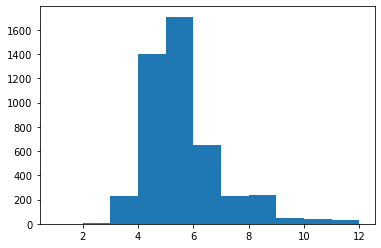

In [114]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [115]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.4, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 4    acc: 4.8                                   
Result 15: 5    acc: 4.8125                                
Result 16: 5    acc: 4.823529411764706  

Result 273: 4    acc: 4.95985401459854                     
Result 274: 4    acc: 4.956363636363636                    
Result 275: 9    acc: 4.971014492753623                    
Result 276: 9    acc: 4.985559566787003                    
Result 277: 9    acc: 5.0                                  
Result 278: 6    acc: 5.003584229390681                    
Result 279: 5    acc: 5.003571428571429                    
Result 280: 4    acc: 5.0                                  
Result 281: 7    acc: 5.00709219858156                     
Result 282: 3    acc: 5.0                                  
Result 283: 6    acc: 5.003521126760563                    
Result 284: 4    acc: 5.0                                  
Result 285: 5    acc: 5.0                                  
Result 286: 5    acc: 5.0                                  
Result 287: 7    acc: 5.006944444444445                    
Result 288: 6    acc: 5.010380622837371                    
Result 289: 6    acc: 5.0137931034482754

Result 410: 3    acc: 5.099756690997567                    
Result 411: 3    acc: 5.094660194174757                    
Result 412: 5    acc: 5.094430992736077                    
Result 413: 6    acc: 5.096618357487923                    
Result 414: 4    acc: 5.093975903614457                    
Result 415: 5    acc: 5.09375                              
Result 416: 4    acc: 5.091127098321343                    
Result 417: 4    acc: 5.088516746411483                    
Result 418: 9    acc: 5.097852028639618                    
Result 419: 4    acc: 5.095238095238095                    
Result 420: 5    acc: 5.095011876484561                    
Result 421: 4    acc: 5.092417061611374                    
Result 422: 3    acc: 5.087470449172577                    
Result 423: 6    acc: 5.089622641509434                    
Result 424: 6    acc: 5.091764705882353                    
Result 425: 5    acc: 5.091549295774648                    
Result 426: 4    acc: 5.0889929742388755

Result 547: 4    acc: 5.12043795620438                     
Result 548: 5    acc: 5.120218579234972                    
Result 549: 5    acc: 5.12                                 
Result 550: 5    acc: 5.11978221415608                     
Result 551: 5    acc: 5.119565217391305                    
Result 552: 5    acc: 5.119349005424954                    
Result 553: 5    acc: 5.11913357400722                     
Result 554: 5    acc: 5.118918918918919                    
Result 555: 5    acc: 5.118705035971223                    
Result 556: 5    acc: 5.118491921005386                    
Result 557: 5    acc: 5.118279569892473                    
Result 558: 5    acc: 5.1180679785330945                   
Result 559: 5    acc: 5.117857142857143                    
Result 560: 5    acc: 5.117647058823529                    
Result 561: 5    acc: 5.117437722419929                    
Result 562: 5    acc: 5.1172291296625225                   
Result 563: 4    acc: 5.115248226950355 

Result 684: 4    acc: 5.054014598540146                    
Result 685: 4    acc: 5.052478134110787                    
Result 686: 4    acc: 5.0509461426492                      
Result 687: 5    acc: 5.050872093023256                    
Result 688: 4    acc: 5.049346879535559                    
Result 689: 5    acc: 5.04927536231884                     
Result 690: 5    acc: 5.049204052098408                    
Result 691: 5    acc: 5.0491329479768785                   
Result 692: 5    acc: 5.049062049062049                    
Result 693: 5    acc: 5.0489913544668585                   
Result 694: 5    acc: 5.048920863309353                    
Result 695: 5    acc: 5.0488505747126435                   
Result 696: 4    acc: 5.047345767575322                    
Result 697: 5    acc: 5.04727793696275                     
Result 698: 7    acc: 5.050071530758226                    
Result 699: 4    acc: 5.048571428571429                    
Result 700: 4    acc: 5.0470756062767475

Result 957: 4    acc: 4.979123173277662                    
Result 958: 4    acc: 4.978102189781022                    
Result 959: 4    acc: 4.977083333333334                    
Result 960: 4    acc: 4.976066597294485                    
Result 961: 4    acc: 4.975051975051975                    
Result 962: 4    acc: 4.9740394600207685                   
Result 963: 4    acc: 4.973029045643154                    
Result 964: 4    acc: 4.972020725388601                    
Result 965: 4    acc: 4.971014492753623                    
Result 966: 4    acc: 4.970010341261634                    
Result 967: 4    acc: 4.9690082644628095                   
Result 968: 4    acc: 4.9680082559339525                   
Result 969: 5    acc: 4.968041237113402                    
Result 970: 4    acc: 4.967044284243048                    
Result 971: 4    acc: 4.966049382716049                    
Result 972: 6    acc: 4.9671120246659815                   
Result 973: 6    acc: 4.968172484599589 

Result 1230: 5    acc: 4.90982940698619                    
Result 1231: 5    acc: 4.909902597402597                   
Result 1232: 5    acc: 4.909975669099757                   
Result 1233: 5    acc: 4.910048622366289                   
Result 1234: 5    acc: 4.910121457489878                   
Result 1235: 5    acc: 4.910194174757281                   
Result 1236: 5    acc: 4.910266774454325                   
Result 1237: 5    acc: 4.910339256865913                   
Result 1238: 5    acc: 4.910411622276029                   
Result 1239: 5    acc: 4.910483870967742                   
Result 1240: 5    acc: 4.910556003223207                   
Result 1241: 5    acc: 4.9106280193236715                  
Result 1242: 4    acc: 4.909895414320193                   
Result 1243: 4    acc: 4.909163987138264                   
Result 1244: 5    acc: 4.909236947791165                   
Result 1245: 4    acc: 4.908507223113965                   
Result 1246: 4    acc: 4.907778668805133

Result 1367: 6    acc: 4.885964912280702                   
Result 1368: 6    acc: 4.886778670562454                   
Result 1369: 6    acc: 4.887591240875913                   
Result 1370: 6    acc: 4.888402625820569                   
Result 1371: 6    acc: 4.889212827988338                   
Result 1372: 6    acc: 4.890021849963583                   
Result 1373: 6    acc: 4.890829694323144                   
Result 1374: 5    acc: 4.890909090909091                   
Result 1375: 5    acc: 4.890988372093023                   
Result 1376: 4    acc: 4.890341321713871                   
Result 1377: 5    acc: 4.890420899854862                   
Result 1378: 5    acc: 4.890500362581581                   
Result 1379: 5    acc: 4.8905797101449275                  
Result 1380: 5    acc: 4.890658942795076                   
Result 1381: 5    acc: 4.8907380607814765                  
Result 1382: 5    acc: 4.890817064352856                   
Result 1383: 5    acc: 4.890895953757226

Result 1504: 4    acc: 4.869767441860465                   
Result 1505: 5    acc: 4.869853917662683                   
Result 1506: 5    acc: 4.869940278699403                   
Result 1507: 5    acc: 4.870026525198939                   
Result 1508: 5    acc: 4.870112657388999                   
Result 1509: 5    acc: 4.870198675496689                   
Result 1510: 4    acc: 4.869622766379881                   
Result 1511: 4    acc: 4.869047619047619                   
Result 1512: 5    acc: 4.869134170522141                   
Result 1513: 5    acc: 4.869220607661823                   
Result 1514: 5    acc: 4.869306930693069                   
Result 1515: 5    acc: 4.869393139841689                   
Result 1516: 5    acc: 4.869479235332894                   
Result 1517: 5    acc: 4.869565217391305                   
Result 1518: 5    acc: 4.869651086240948                   
Result 1519: 5    acc: 4.869736842105263                   
Result 1520: 5    acc: 4.8698224852071  

Result 1643: 5    acc: 4.894768856447689                   
Result 1644: 5    acc: 4.89483282674772                    
Result 1645: 6    acc: 4.8955042527339                     
Result 1646: 5    acc: 4.895567698846388                   
Result 1647: 7    acc: 4.896844660194175                   
Result 1648: 7    acc: 4.898120072771377                   
Result 1649: 6    acc: 4.8987878787878785                  
Result 1650: 5    acc: 4.898849182313749                   
Result 1651: 5    acc: 4.898910411622276                   
Result 1652: 5    acc: 4.898971566848155                   
Result 1653: 5    acc: 4.899032648125756                   
Result 1654: 5    acc: 4.899093655589124                   
Result 1655: 7    acc: 4.90036231884058                    
Result 1656: 5    acc: 4.9004224502112255                  
Result 1657: 5    acc: 4.900482509047045                   
Result 1658: 5    acc: 4.900542495479204                   
Result 1659: 5    acc: 4.900602409638554

Result 1780: 4    acc: 4.880404267265581                   
Result 1781: 4    acc: 4.879910213243547                   
Result 1782: 5    acc: 4.879977565900168                   
Result 1783: 5    acc: 4.880044843049327                   
Result 1784: 5    acc: 4.880112044817928                   
Result 1785: 5    acc: 4.880179171332586                   
Result 1786: 5    acc: 4.8802462227196415                  
Result 1787: 5    acc: 4.880313199105146                   
Result 1788: 5    acc: 4.880380100614869                   
Result 1789: 4    acc: 4.879888268156424                   
Result 1790: 4    acc: 4.8793969849246235                  
Result 1791: 4    acc: 4.87890625                          
Result 1792: 4    acc: 4.878416062465142                   
Result 1793: 4    acc: 4.877926421404682                   
Result 1794: 5    acc: 4.87799442896936                    
Result 1795: 6    acc: 4.878619153674833                   
Result 1796: 3    acc: 4.877573734001113

Result 2053: 4    acc: 4.84031158714703                    
Result 2054: 6    acc: 4.840875912408759                   
Result 2055: 11    acc: 4.843871595330739                  
Result 2056: 3    acc: 4.8429752066115705                  
Result 2057: 5    acc: 4.8430515063168125                  
Result 2058: 6    acc: 4.843613404565323                   
Result 2059: 6    acc: 4.844174757281554                   
Result 2060: 4    acc: 4.843765162542455                   
Result 2061: 4    acc: 4.843355965082444                   
Result 2062: 6    acc: 4.843916626272419                   
Result 2063: 6    acc: 4.844476744186046                   
Result 2064: 6    acc: 4.845036319612591                   
Result 2065: 6    acc: 4.845595353339787                   
Result 2066: 6    acc: 4.846153846153846                   
Result 2067: 6    acc: 4.846711798839459                   
Result 2068: 6    acc: 4.847269212179797                   
Result 2069: 5    acc: 4.847342995169082

Result 2190: 5    acc: 4.813783660429028                   
Result 2191: 5    acc: 4.813868613138686                   
Result 2192: 5    acc: 4.813953488372093                   
Result 2193: 5    acc: 4.814038286235187                   
Result 2194: 5    acc: 4.814123006833713                   
Result 2195: 5    acc: 4.814207650273224                   
Result 2196: 5    acc: 4.814292216659081                   
Result 2197: 5    acc: 4.814376706096452                   
Result 2198: 5    acc: 4.814461118690314                   
Result 2199: 5    acc: 4.8145454545454545                  
Result 2200: 5    acc: 4.81462971376647                    
Result 2201: 5    acc: 4.814713896457766                   
Result 2202: 5    acc: 4.814798002723559                   
Result 2203: 5    acc: 4.814882032667876                   
Result 2204: 5    acc: 4.814965986394558                   
Result 2205: 5    acc: 4.8150498640072525                  
Result 2206: 5    acc: 4.815133665609425

Result 2327: 4    acc: 4.80713058419244                    
Result 2328: 4    acc: 4.806784027479605                   
Result 2329: 4    acc: 4.806437768240343                   
Result 2330: 4    acc: 4.806091806091806                   
Result 2331: 4    acc: 4.805746140651801                   
Result 2332: 4    acc: 4.805400771538792                   
Result 2333: 4    acc: 4.805055698371894                   
Result 2334: 6    acc: 4.805567451820129                   
Result 2335: 6    acc: 4.806078767123288                   
Result 2336: 4    acc: 4.805733846812152                   
Result 2337: 4    acc: 4.8053892215568865                  
Result 2338: 4    acc: 4.805044890979051                   
Result 2339: 4    acc: 4.8047008547008545                  
Result 2340: 4    acc: 4.804357112345151                   
Result 2341: 4    acc: 4.80401366353544                    
Result 2342: 4    acc: 4.80367050789586                    
Result 2343: 4    acc: 4.803327645051194

Result 2465: 4    acc: 4.847931873479319                   
Result 2466: 4    acc: 4.847588163761654                   
Result 2467: 4    acc: 4.847244732576986                   
Result 2468: 4    acc: 4.846901579586877                   
Result 2469: 4    acc: 4.846558704453441                   
Result 2470: 4    acc: 4.846216106839337                   
Result 2471: 4    acc: 4.845873786407767                   
Result 2472: 4    acc: 4.845531742822483                   
Result 2473: 4    acc: 4.845189975747777                   
Result 2474: 4    acc: 4.844848484848485                   
Result 2475: 4    acc: 4.844507269789984                   
Result 2476: 4    acc: 4.844166330238191                   
Result 2477: 4    acc: 4.843825665859564                   
Result 2478: 4    acc: 4.843485276321097                   
Result 2479: 4    acc: 4.843145161290322                   
Result 2480: 6    acc: 4.843611446997179                   
Result 2481: 6    acc: 4.844077356970185

Result 2602: 5    acc: 4.833653476757587                   
Result 2603: 5    acc: 4.833717357910906                   
Result 2604: 4    acc: 4.833397312859885                   
Result 2605: 5    acc: 4.833461243284727                   
Result 2606: 8    acc: 4.834675872650556                   
Result 2607: 8    acc: 4.835889570552148                   
Result 2608: 8    acc: 4.83710233806056                    
Result 2609: 5    acc: 4.837164750957855                   
Result 2610: 5    acc: 4.837227116047491                   
Result 2611: 5    acc: 4.83728943338438                    
Result 2612: 5    acc: 4.837351703023344                   
Result 2613: 7    acc: 4.838179035960215                   
Result 2614: 7    acc: 4.8390057361376675                  
Result 2615: 7    acc: 4.839831804281346                   
Result 2616: 7    acc: 4.840657241115782                   
Result 2617: 5    acc: 4.840718105423988                   
Result 2618: 7    acc: 4.841542573501337

Result 2875: 4    acc: 4.886300417246175                   
Result 2876: 4    acc: 4.885992353145638                   
Result 2877: 4    acc: 4.885684503127171                   
Result 2878: 4    acc: 4.885376866967697                   
Result 2879: 8    acc: 4.886458333333334                   
Result 2880: 8    acc: 4.88753904894134                    
Result 2881: 8    acc: 4.888619014573213                   
Result 2882: 8    acc: 4.8896982310093655                  
Result 2883: 8    acc: 4.890776699029126                   
Result 2884: 8    acc: 4.891854419410746                   
Result 2885: 8    acc: 4.892931392931393                   
Result 2886: 8    acc: 4.894007620367163                   
Result 2887: 8    acc: 4.895083102493075                   
Result 2888: 8    acc: 4.896157840083074                   
Result 2889: 8    acc: 4.897231833910035                   
Result 2890: 8    acc: 4.898305084745763                   
Result 2891: 8    acc: 4.899377593360996

Result 3148: 8    acc: 4.944744363289933                   
Result 3149: 8    acc: 4.945714285714286                   
Result 3150: 8    acc: 4.946683592510314                   
Result 3151: 9    acc: 4.947969543147208                   
Result 3152: 9    acc: 4.9492546780843645                  
Result 3153: 9    acc: 4.950538998097654                   
Result 3154: 9    acc: 4.951822503961965                   
Result 3155: 8    acc: 4.952788339670469                   
Result 3156: 4    acc: 4.9524865378523915                  
Result 3157: 4    acc: 4.952184927169094                   
Result 3158: 4    acc: 4.951883507439063                   
Result 3159: 4    acc: 4.951582278481013                   
Result 3160: 4    acc: 4.951281240113888                   
Result 3161: 5    acc: 4.9512966476913345                  
Result 3162: 5    acc: 4.951312045526399                   
Result 3163: 5    acc: 4.951327433628318                   
Result 3164: 5    acc: 4.951342812006319

Result 3421: 5    acc: 5.05260081823495                    
Result 3422: 5    acc: 5.052585451358458                   
Result 3423: 5    acc: 5.052570093457944                   
Result 3424: 5    acc: 5.052554744525548                   
Result 3425: 4    acc: 5.052247518972563                   
Result 3426: 4    acc: 5.0519404727166615                  
Result 3427: 5    acc: 5.051925320886815                   
Result 3428: 5    acc: 5.05191017789443                    
Result 3429: 5    acc: 5.051895043731778                   
Result 3430: 5    acc: 5.05187991839114                    
Result 3431: 5    acc: 5.051864801864802                   
Result 3432: 8    acc: 5.0527235653946985                  
Result 3433: 5    acc: 5.05270821199767                    
Result 3434: 5    acc: 5.0526928675400296                  
Result 3435: 5    acc: 5.05267753201397                    
Result 3436: 5    acc: 5.052662205411696                   
Result 3437: 5    acc: 5.052646887725421

Result 3559: 5    acc: 5.0705056179775285                  
Result 3560: 5    acc: 5.070485818590283                   
Result 3561: 5    acc: 5.070466030320045                   
Result 3562: 5    acc: 5.070446253157452                   
Result 3563: 4    acc: 5.070145903479236                   
Result 3564: 5    acc: 5.070126227208976                   
Result 3565: 5    acc: 5.0701065619742005                  
Result 3566: 10    acc: 5.071488645920942                  
Result 3567: 10    acc: 5.072869955156951                  
Result 3568: 10    acc: 5.0742504903334265                 
Result 3569: 6    acc: 5.074509803921568                   
Result 3570: 6    acc: 5.074768972276673                   
Result 3571: 6    acc: 5.075027995520717                   
Result 3572: 7    acc: 5.075566750629723                   
Result 3573: 7    acc: 5.076105204252938                   
Result 3574: 7    acc: 5.076643356643356                   
Result 3575: 7    acc: 5.077181208053691

Result 3831: 4    acc: 5.090031315240084                   
Result 3832: 4    acc: 5.089746934516045                   
Result 3833: 4    acc: 5.089462702138759                   
Result 3834: 4    acc: 5.089178617992177                   
Result 3835: 5    acc: 5.089155370177268                   
Result 3836: 5    acc: 5.089132134480063                   
Result 3837: 5    acc: 5.089108910891089                   
Result 3838: 5    acc: 5.0890856994008855                  
Result 3839: 5    acc: 5.0890625                           
Result 3840: 5    acc: 5.08903931267899                    
Result 3841: 5    acc: 5.089016137428422                   
Result 3842: 4    acc: 5.088732760863908                   
Result 3843: 8    acc: 5.0894901144641                     
Result 3844: 4    acc: 5.089206762028609                   
Result 3845: 4    acc: 5.0889235569422775                  
Result 3846: 4    acc: 5.0886404990902                     
Result 3847: 4    acc: 5.088357588357589

Result 3969: 6    acc: 5.101007556675063                   
Result 3970: 6    acc: 5.101233946109292                   
Result 3971: 6    acc: 5.101460221550856                   
Result 3972: 6    acc: 5.10168638308583                    
Result 3973: 6    acc: 5.101912430800201                   
Result 3974: 6    acc: 5.102138364779874                   
Result 3975: 6    acc: 5.102364185110664                   
Result 3976: 6    acc: 5.1025898918783                     
Result 3977: 5    acc: 5.102564102564102                   
Result 3978: 5    acc: 5.102538326212616                   
Result 3979: 5    acc: 5.10251256281407                    
Result 3980: 5    acc: 5.102486812358704                   
Result 3981: 5    acc: 5.102461074836765                   
Result 3982: 5    acc: 5.102435350238514                   
Result 3983: 5    acc: 5.102409638554217                   
Result 3984: 5    acc: 5.102383939774153                   
Result 3985: 5    acc: 5.10235825388861 

Result 4242: 7    acc: 5.0956870139052555                  
Result 4243: 9    acc: 5.0966069745523095                  
Result 4244: 9    acc: 5.097526501766785                   
Result 4245: 6    acc: 5.09773904851625                    
Result 4246: 6    acc: 5.097951495173064                   
Result 4247: 6    acc: 5.09816384180791                    
Result 4248: 7    acc: 5.098611437985408                   
Result 4249: 6    acc: 5.0988235294117645                  
Result 4250: 8    acc: 5.099505998588567                   
Result 4251: 5    acc: 5.0994825964252115                  
Result 4252: 4    acc: 5.099224077122032                   
Result 4253: 5    acc: 5.099200752233192                   
Result 4254: 6    acc: 5.099412455934195                   
Result 4255: 5    acc: 5.0993890977443606                  
Result 4256: 5    acc: 5.099365750528541                   
Result 4257: 4    acc: 5.099107562235791                   
Result 4258: 4    acc: 5.098849495186664

Result 4515: 5    acc: 5.122674933569531                   
Result 4516: 5    acc: 5.12264777507195                    
Result 4517: 5    acc: 5.122620628596724                   
Result 4518: 3    acc: 5.122150918344767                   
Result 4519: 7    acc: 5.122566371681416                   
Result 4520: 7    acc: 5.122981641229816                   
Result 4521: 7    acc: 5.123396727111897                   
Result 4522: 7    acc: 5.123811629449481                   
Result 4523: 7    acc: 5.12422634836428                    
Result 4524: 7    acc: 5.124640883977901                   
Result 4525: 7    acc: 5.125055236411843                   
Result 4526: 7    acc: 5.125469405787498                   
Result 4527: 7    acc: 5.125883392226148                   
Result 4528: 7    acc: 5.126297195848974                   
Result 4529: 6    acc: 5.126490066225165                   
Result 4530: 6    acc: 5.126682851467667                   
Result 4531: 6    acc: 5.126875551632833

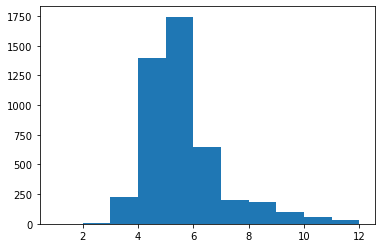

In [116]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [117]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.6, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 5    acc: 5.0                                    
Result 3: 5    acc: 5.0                                    
Result 4: 5    acc: 5.0                                    
Result 5: 6    acc: 5.166666666666667                      
Result 6: 5    acc: 5.142857142857143                      
Result 7: 5    acc: 5.125                                  
Result 8: 5    acc: 5.111111111111111                      
Result 9: 5    acc: 5.1                                    
Result 10: 5    acc: 5.090909090909091                     
Result 11: 5    acc: 5.083333333333333                     
Result 12: 5    acc: 5.076923076923077                     
Result 13: 4    acc: 5.0                                   
Result 14: 4    acc: 4.933333333333334                     
Result 15: 4    acc: 4.875                                 
Result 16: 4    acc: 4.823529411764706  

Result 272: 8    acc: 5.197802197802198                    
Result 273: 8    acc: 5.208029197080292                    
Result 274: 13    acc: 5.236363636363636                   
Result 275: 13    acc: 5.2644927536231885                  
Result 276: 16    acc: 5.303249097472924                   
Result 277: 16    acc: 5.341726618705036                   
Result 278: 7    acc: 5.347670250896058                    
Result 279: 5    acc: 5.3464285714285715                   
Result 280: 4    acc: 5.341637010676156                    
Result 281: 4    acc: 5.336879432624113                    
Result 282: 3    acc: 5.328621908127208                    
Result 283: 6    acc: 5.330985915492958                    
Result 284: 4    acc: 5.326315789473684                    
Result 285: 5    acc: 5.325174825174825                    
Result 286: 5    acc: 5.32404181184669                     
Result 287: 6    acc: 5.326388888888889                    
Result 288: 6    acc: 5.328719723183391 

Result 544: 4    acc: 5.304587155963302                    
Result 545: 4    acc: 5.302197802197802                    
Result 546: 4    acc: 5.29981718464351                     
Result 547: 4    acc: 5.297445255474453                    
Result 548: 6    acc: 5.298724954462659                    
Result 549: 4    acc: 5.296363636363636                    
Result 550: 6    acc: 5.297640653357532                    
Result 551: 6    acc: 5.298913043478261                    
Result 552: 6    acc: 5.300180831826402                    
Result 553: 6    acc: 5.3014440433212995                   
Result 554: 6    acc: 5.302702702702702                    
Result 555: 6    acc: 5.303956834532374                    
Result 556: 6    acc: 5.305206463195691                    
Result 557: 6    acc: 5.306451612903226                    
Result 558: 6    acc: 5.3076923076923075                   
Result 559: 6    acc: 5.308928571428571                    
Result 560: 6    acc: 5.310160427807487 

Result 681: 4    acc: 5.197947214076247                    
Result 682: 4    acc: 5.196193265007321                    
Result 683: 4    acc: 5.194444444444445                    
Result 684: 4    acc: 5.192700729927007                    
Result 685: 4    acc: 5.190962099125365                    
Result 686: 4    acc: 5.189228529839884                    
Result 687: 4    acc: 5.1875                               
Result 688: 4    acc: 5.18577648766328                     
Result 689: 4    acc: 5.184057971014493                    
Result 690: 4    acc: 5.182344428364689                    
Result 691: 4    acc: 5.180635838150289                    
Result 692: 4    acc: 5.178932178932179                    
Result 693: 4    acc: 5.177233429394812                    
Result 694: 4    acc: 5.175539568345323                    
Result 695: 4    acc: 5.1738505747126435                   
Result 696: 4    acc: 5.172166427546628                    
Result 697: 4    acc: 5.170487106017192 

Result 953: 4    acc: 5.09643605870021                     
Result 954: 4    acc: 5.0952879581151835                   
Result 955: 4    acc: 5.094142259414226                    
Result 956: 4    acc: 5.09299895506792                     
Result 957: 4    acc: 5.091858037578288                    
Result 958: 4    acc: 5.090719499478624                    
Result 959: 4    acc: 5.089583333333334                    
Result 960: 4    acc: 5.088449531737774                    
Result 961: 4    acc: 5.087318087318088                    
Result 962: 4    acc: 5.086188992731048                    
Result 963: 4    acc: 5.0850622406639                      
Result 964: 4    acc: 5.083937823834197                    
Result 965: 4    acc: 5.082815734989648                    
Result 966: 4    acc: 5.081695966907962                    
Result 967: 4    acc: 5.080578512396694                    
Result 968: 4    acc: 5.079463364293086                    
Result 969: 6    acc: 5.08041237113402  

Result 1091: 5    acc: 5.066849816849817                   
Result 1092: 5    acc: 5.066788655077768                   
Result 1093: 5    acc: 5.06672760511883                    
Result 1094: 5    acc: 5.066666666666666                   
Result 1095: 4    acc: 5.065693430656935                   
Result 1096: 4    acc: 5.064721969006381                   
Result 1097: 4    acc: 5.063752276867031                   
Result 1098: 4    acc: 5.062784349408553                   
Result 1099: 4    acc: 5.0618181818181816                  
Result 1100: 4    acc: 5.0608537693006355                  
Result 1101: 5    acc: 5.060798548094374                   
Result 1102: 3    acc: 5.058930190389846                   
Result 1103: 8    acc: 5.061594202898551                   
Result 1104: 16    acc: 5.071493212669683                  
Result 1105: 4    acc: 5.070524412296564                   
Result 1106: 4    acc: 5.069557362240289                   
Result 1107: 5    acc: 5.069494584837545

Result 1228: 5    acc: 5.024410089503662                   
Result 1229: 3    acc: 5.022764227642276                   
Result 1230: 4    acc: 5.021933387489845                   
Result 1231: 4    acc: 5.021103896103896                   
Result 1232: 4    acc: 5.0202757502027575                  
Result 1233: 4    acc: 5.019448946515397                   
Result 1234: 4    acc: 5.018623481781376                   
Result 1235: 4    acc: 5.017799352750809                   
Result 1236: 4    acc: 5.016976556184317                   
Result 1237: 4    acc: 5.016155088852988                   
Result 1238: 4    acc: 5.015334947538338                   
Result 1239: 4    acc: 5.014516129032258                   
Result 1240: 4    acc: 5.013698630136986                   
Result 1241: 5    acc: 5.013687600644122                   
Result 1242: 4    acc: 5.012872083668544                   
Result 1243: 4    acc: 5.012057877813505                   
Result 1244: 5    acc: 5.012048192771084

Result 1500: 4    acc: 4.9580279813457695                  
Result 1501: 4    acc: 4.957390146471371                   
Result 1502: 4    acc: 4.956753160345975                   
Result 1503: 4    acc: 4.9561170212765955                  
Result 1504: 4    acc: 4.9554817275747505                  
Result 1505: 5    acc: 4.9555112881806105                  
Result 1506: 5    acc: 4.955540809555408                   
Result 1507: 5    acc: 4.955570291777188                   
Result 1508: 5    acc: 4.955599734923791                   
Result 1509: 5    acc: 4.9556291390728475                  
Result 1510: 4    acc: 4.954996690933156                   
Result 1511: 3    acc: 4.953703703703703                   
Result 1512: 4    acc: 4.953073364177132                   
Result 1513: 4    acc: 4.952443857331572                   
Result 1514: 4    acc: 4.9518151815181515                  
Result 1515: 4    acc: 4.9511873350923485                  
Result 1516: 5    acc: 4.951219512195122

Result 1639: 4    acc: 4.950609756097561                   
Result 1640: 4    acc: 4.950030469226082                   
Result 1641: 3    acc: 4.94884287454324                    
Result 1642: 3    acc: 4.947656725502131                   
Result 1643: 7    acc: 4.9489051094890515                  
Result 1644: 7    acc: 4.950151975683891                   
Result 1645: 7    acc: 4.951397326852977                   
Result 1646: 5    acc: 4.951426836672739                   
Result 1647: 4    acc: 4.950849514563107                   
Result 1648: 4    acc: 4.95027289266222                    
Result 1649: 4    acc: 4.949696969696969                   
Result 1650: 5    acc: 4.9497274379164145                  
Result 1651: 5    acc: 4.949757869249395                   
Result 1652: 5    acc: 4.949788263762856                   
Result 1653: 5    acc: 4.949818621523579                   
Result 1654: 5    acc: 4.949848942598187                   
Result 1655: 5    acc: 4.94987922705314 

Result 1776: 4    acc: 4.920652785593697                   
Result 1777: 4    acc: 4.9201349831271095                  
Result 1778: 4    acc: 4.919617762788083                   
Result 1779: 4    acc: 4.919101123595506                   
Result 1780: 4    acc: 4.918585064570466                   
Result 1781: 4    acc: 4.918069584736251                   
Result 1782: 5    acc: 4.918115535614134                   
Result 1783: 5    acc: 4.918161434977579                   
Result 1784: 5    acc: 4.918207282913166                   
Result 1785: 5    acc: 4.918253079507279                   
Result 1786: 5    acc: 4.918298824846111                   
Result 1787: 5    acc: 4.91834451901566                    
Result 1788: 5    acc: 4.9183901621017325                  
Result 1789: 4    acc: 4.917877094972067                   
Result 1790: 4    acc: 4.917364600781686                   
Result 1791: 4    acc: 4.916852678571429                   
Result 1792: 4    acc: 4.916341327384272

Result 1915: 4    acc: 4.929540709812109                   
Result 1916: 5    acc: 4.929577464788732                   
Result 1917: 5    acc: 4.929614181438999                   
Result 1918: 5    acc: 4.929650859822824                   
Result 1919: 5    acc: 4.9296875                           
Result 1920: 5    acc: 4.9297241020301925                  
Result 1921: 5    acc: 4.929760665972945                   
Result 1922: 5    acc: 4.929797191887675                   
Result 1923: 4    acc: 4.929313929313929                   
Result 1924: 4    acc: 4.928831168831169                   
Result 1925: 4    acc: 4.928348909657321                   
Result 1926: 4    acc: 4.927867151011935                   
Result 1927: 4    acc: 4.927385892116183                   
Result 1928: 4    acc: 4.926905132192846                   
Result 1929: 4    acc: 4.926424870466321                   
Result 1930: 4    acc: 4.92594510616261                    
Result 1931: 4    acc: 4.925465838509317

Result 2054: 6    acc: 4.910948905109489                   
Result 2055: 14    acc: 4.915369649805448                  
Result 2056: 3    acc: 4.9144385026737964                  
Result 2057: 5    acc: 4.914480077745384                   
Result 2058: 6    acc: 4.91500728508985                    
Result 2059: 6    acc: 4.915533980582524                   
Result 2060: 4    acc: 4.915089762251334                   
Result 2061: 4    acc: 4.914645974781766                   
Result 2062: 6    acc: 4.91517207949588                    
Result 2063: 6    acc: 4.915697674418604                   
Result 2064: 6    acc: 4.916222760290557                   
Result 2065: 6    acc: 4.91674733785092                    
Result 2066: 6    acc: 4.917271407837446                   
Result 2067: 6    acc: 4.917794970986461                   
Result 2068: 6    acc: 4.918318028032866                   
Result 2069: 5    acc: 4.918357487922705                   
Result 2070: 5    acc: 4.918396909705456

Result 2191: 5    acc: 4.883667883211679                   
Result 2192: 5    acc: 4.883720930232558                   
Result 2193: 5    acc: 4.883773928896992                   
Result 2194: 5    acc: 4.88382687927107                    
Result 2195: 5    acc: 4.883879781420765                   
Result 2196: 5    acc: 4.8839326354119255                  
Result 2197: 5    acc: 4.883985441310282                   
Result 2198: 5    acc: 4.884038199181446                   
Result 2199: 5    acc: 4.884090909090909                   
Result 2200: 5    acc: 4.884143571104044                   
Result 2201: 5    acc: 4.884196185286103                   
Result 2202: 5    acc: 4.884248751702224                   
Result 2203: 5    acc: 4.8843012704174225                  
Result 2204: 5    acc: 4.884353741496598                   
Result 2205: 5    acc: 4.884406165004533                   
Result 2206: 5    acc: 4.88445854100589                    
Result 2207: 5    acc: 4.884510869565218

Result 2464: 4    acc: 4.909533468559838                   
Result 2465: 4    acc: 4.909164639091647                   
Result 2466: 4    acc: 4.908796108633968                   
Result 2467: 4    acc: 4.908427876823339                   
Result 2468: 4    acc: 4.908059943296881                   
Result 2469: 4    acc: 4.907692307692308                   
Result 2470: 4    acc: 4.907324969647916                   
Result 2471: 4    acc: 4.906957928802589                   
Result 2472: 4    acc: 4.906591184795794                   
Result 2473: 4    acc: 4.906224737267583                   
Result 2474: 4    acc: 4.905858585858586                   
Result 2475: 4    acc: 4.905492730210016                   
Result 2476: 4    acc: 4.905127169963666                   
Result 2477: 4    acc: 4.904761904761905                   
Result 2478: 4    acc: 4.90439693424768                    
Result 2479: 4    acc: 4.904032258064516                   
Result 2480: 6    acc: 4.90447400241838 

Result 2736: 4    acc: 4.929119473876507                   
Result 2737: 4    acc: 4.928780131482834                   
Result 2738: 4    acc: 4.928441036874772                   
Result 2739: 4    acc: 4.928102189781022                   
Result 2740: 4    acc: 4.927763589930683                   
Result 2741: 5    acc: 4.927789934354486                   
Result 2742: 5    acc: 4.9278162595698145                  
Result 2743: 4    acc: 4.927478134110787                   
Result 2744: 9    acc: 4.9289617486338795                  
Result 2745: 4    acc: 4.9286234522942465                  
Result 2746: 4    acc: 4.928285402257008                   
Result 2747: 4    acc: 4.927947598253275                   
Result 2748: 5    acc: 4.927973808657693                   
Result 2749: 6    acc: 4.9283636363636365                  
Result 2750: 6    acc: 4.928753180661578                   
Result 2751: 4    acc: 4.928415697674419                   
Result 2752: 9    acc: 4.929894660370505

Result 2874: 3    acc: 4.954086956521739                   
Result 2875: 4    acc: 4.953755215577191                   
Result 2876: 4    acc: 4.953423705248523                   
Result 2877: 4    acc: 4.953092425295344                   
Result 2878: 4    acc: 4.952761375477596                   
Result 2879: 8    acc: 4.953819444444444                   
Result 2880: 8    acc: 4.9548767788962165                  
Result 2881: 8    acc: 4.955933379597502                   
Result 2882: 8    acc: 4.956989247311828                   
Result 2883: 8    acc: 4.958044382801664                   
Result 2884: 8    acc: 4.959098786828423                   
Result 2885: 8    acc: 4.96015246015246                    
Result 2886: 8    acc: 4.9612054035330795                  
Result 2887: 8    acc: 4.962257617728532                   
Result 2888: 8    acc: 4.9633091034960195                  
Result 2889: 8    acc: 4.964359861591696                   
Result 2890: 8    acc: 4.965409892770667

Result 3146: 10    acc: 5.016523673339688                  
Result 3147: 10    acc: 5.018106734434562                  
Result 3148: 10    acc: 5.019688790092093                  
Result 3149: 10    acc: 5.0212698412698415                 
Result 3150: 10    acc: 5.022849888924151                  
Result 3151: 13    acc: 5.025380710659898                  
Result 3152: 13    acc: 5.027909927053599                  
Result 3153: 13    acc: 5.030437539632213                  
Result 3154: 4    acc: 5.030110935023772                   
Result 3155: 10    acc: 5.031685678073511                  
Result 3156: 4    acc: 5.031358885017422                   
Result 3157: 4    acc: 5.031032298923369                   
Result 3158: 4    acc: 5.0307059195948085                  
Result 3159: 4    acc: 5.030379746835443                   
Result 3160: 4    acc: 5.030053780449225                   
Result 3161: 5    acc: 5.030044275774826                   
Result 3162: 5    acc: 5.030034777110338

Result 3283: 6    acc: 5.028319123020706                   
Result 3284: 6    acc: 5.028614916286149                   
Result 3285: 6    acc: 5.028910529519172                   
Result 3286: 6    acc: 5.029205962884089                   
Result 3287: 6    acc: 5.029501216545012                   
Result 3288: 6    acc: 5.029796290665856                   
Result 3289: 5    acc: 5.029787234042553                   
Result 3290: 7    acc: 5.030385900941963                   
Result 3291: 5    acc: 5.0303766707168895                  
Result 3292: 6    acc: 5.030671120558761                   
Result 3293: 5    acc: 5.030661809350334                   
Result 3294: 6    acc: 5.030955993930197                   
Result 3295: 5    acc: 5.030946601941747                   
Result 3296: 7    acc: 5.031543827722172                   
Result 3297: 7    acc: 5.0321406913280775                  
Result 3298: 7    acc: 5.032737193088815                   
Result 3299: 7    acc: 5.033333333333333

Result 3557: 4    acc: 5.139966273187184                   
Result 3558: 4    acc: 5.139645967968531                   
Result 3559: 4    acc: 5.139325842696629                   
Result 3560: 4    acc: 5.139005897219882                   
Result 3561: 4    acc: 5.138686131386861                   
Result 3562: 4    acc: 5.138366545046309                   
Result 3563: 4    acc: 5.138047138047138                   
Result 3564: 4    acc: 5.1377279102384295                  
Result 3565: 4    acc: 5.137408861469433                   
Result 3566: 16    acc: 5.140454163162321                  
Result 3567: 16    acc: 5.143497757847534                  
Result 3568: 16    acc: 5.1465396469599325                 
Result 3569: 12    acc: 5.148459383753502                  
Result 3570: 12    acc: 5.150378045365444                  
Result 3571: 12    acc: 5.152295632698769                  
Result 3572: 12    acc: 5.154212146655472                  
Result 3573: 12    acc: 5.15612758813654

Result 3694: 6    acc: 5.221109607577808                   
Result 3695: 6    acc: 5.221320346320346                   
Result 3696: 5    acc: 5.221260481471464                   
Result 3697: 5    acc: 5.221200648999459                   
Result 3698: 5    acc: 5.2211408488780755                  
Result 3699: 5    acc: 5.221081081081081                   
Result 3700: 3    acc: 5.220480951094299                   
Result 3701: 3    acc: 5.21988114532685                    
Result 3702: 5    acc: 5.219821766135566                   
Result 3703: 5    acc: 5.2197624190064795                  
Result 3704: 4    acc: 5.219433198380567                   
Result 3705: 4    acc: 5.219104155423637                   
Result 3706: 4    acc: 5.218775289991907                   
Result 3707: 4    acc: 5.218446601941747                   
Result 3708: 4    acc: 5.218118091129685                   
Result 3709: 4    acc: 5.217789757412399                   
Result 3710: 4    acc: 5.217461600646726

Result 3831: 4    acc: 5.225469728601253                   
Result 3832: 4    acc: 5.225150013044613                   
Result 3833: 4    acc: 5.224830464267084                   
Result 3834: 4    acc: 5.224511082138201                   
Result 3835: 5    acc: 5.224452554744525                   
Result 3836: 5    acc: 5.224394057857701                   
Result 3837: 5    acc: 5.224335591453882                   
Result 3838: 5    acc: 5.224277155509247                   
Result 3839: 5    acc: 5.22421875                          
Result 3840: 5    acc: 5.224160374902369                   
Result 3841: 5    acc: 5.224102030192608                   
Result 3842: 4    acc: 5.223783502472027                   
Result 3843: 8    acc: 5.224505723204995                   
Result 3844: 4    acc: 5.224187256176853                   
Result 3845: 4    acc: 5.22386895475819                    
Result 3846: 4    acc: 5.223550818819859                   
Result 3847: 4    acc: 5.223232848232848

Result 3968: 5    acc: 5.257495590828924                   
Result 3969: 6    acc: 5.257682619647355                   
Result 3970: 6    acc: 5.257869554268447                   
Result 3971: 6    acc: 5.258056394763344                   
Result 3972: 6    acc: 5.258243141203121                   
Result 3973: 6    acc: 5.258429793658782                   
Result 3974: 6    acc: 5.2586163522012574                  
Result 3975: 6    acc: 5.258802816901408                   
Result 3976: 6    acc: 5.258989187830022                   
Result 3977: 10    acc: 5.260180995475113                  
Result 3978: 10    acc: 5.261372204071375                  
Result 3979: 5    acc: 5.261306532663316                   
Result 3980: 5    acc: 5.261240894247677                   
Result 3981: 5    acc: 5.261175288799598                   
Result 3982: 5    acc: 5.261109716294251                   
Result 3983: 5    acc: 5.261044176706827                   
Result 3984: 4    acc: 5.260727728983689

Result 4241: 8    acc: 5.235973597359736                   
Result 4242: 4    acc: 5.235682300259251                   
Result 4243: 13    acc: 5.23751178133836                   
Result 4244: 13    acc: 5.239340400471143                  
Result 4245: 9    acc: 5.240226095148375                   
Result 4246: 4    acc: 5.239934071109018                   
Result 4247: 6    acc: 5.240112994350283                   
Result 4248: 6    acc: 5.2402918333725585                  
Result 4249: 4    acc: 5.24                                
Result 4250: 10    acc: 5.241119736532581                  
Result 4251: 5    acc: 5.241063029162747                   
Result 4252: 4    acc: 5.240771220315072                   
Result 4253: 5    acc: 5.240714621532675                   
Result 4254: 5    acc: 5.240658049353701                   
Result 4255: 4    acc: 5.240366541353383                   
Result 4256: 5    acc: 5.24031007751938                    
Result 4257: 5    acc: 5.24025364020667 

Result 4378: 4    acc: 5.266727563370632                   
Result 4379: 4    acc: 5.266438356164383                   
Result 4380: 4    acc: 5.266149280986077                   
Result 4381: 4    acc: 5.2658603377453215                  
Result 4382: 4    acc: 5.265571526351814                   
Result 4383: 5    acc: 5.265510948905109                   
Result 4384: 6    acc: 5.265678449258837                   
Result 4385: 6    acc: 5.2658458732330145                  
Result 4386: 6    acc: 5.266013220879873                   
Result 4387: 6    acc: 5.266180492251595                   
Result 4388: 6    acc: 5.2663476874003186                  
Result 4389: 5    acc: 5.2662870159453306                  
Result 4390: 5    acc: 5.266226372124801                   
Result 4391: 5    acc: 5.266165755919855                   
Result 4392: 5    acc: 5.266105167311633                   
Result 4393: 4    acc: 5.265817023213473                   
Result 4394: 5    acc: 5.26575654152446 

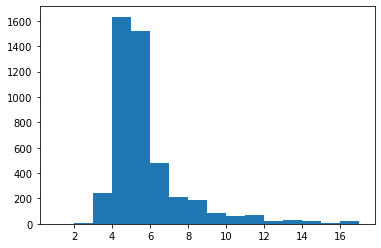

In [118]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [119]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.8, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 6    acc: 4.8                                    
Result 5: 5    acc: 4.833333333333333                      
Result 6: 4    acc: 4.714285714285714                      
Result 7: 4    acc: 4.625                                  
Result 8: 4    acc: 4.555555555555555                      
Result 9: 4    acc: 4.5                                    
Result 10: 4    acc: 4.454545454545454                     
Result 11: 6    acc: 4.583333333333333                     
Result 12: 6    acc: 4.6923076923076925                    
Result 13: 5    acc: 4.714285714285714                     
Result 14: 3    acc: 4.6                                   
Result 15: 3    acc: 4.5                                   
Result 16: 3    acc: 4.411764705882353  

Result 137: 4    acc: 6.463768115942029                    
Result 138: 7    acc: 6.467625899280575                    
Result 139: 7    acc: 6.4714285714285715                   
Result 140: 8    acc: 6.4822695035460995                   
Result 141: 8    acc: 6.492957746478873                    
Result 142: 8    acc: 6.503496503496503                    
Result 143: 4    acc: 6.486111111111111                    
Result 144: 7    acc: 6.489655172413793                    
Result 145: 7    acc: 6.493150684931507                    
Result 146: 7    acc: 6.496598639455782                    
Result 147: 8    acc: 6.506756756756757                    
Result 148: 8    acc: 6.516778523489933                    
Result 149: 8    acc: 6.526666666666666                    
Result 150: 8    acc: 6.5364238410596025                   
Result 151: 7    acc: 6.5394736842105265                   
Result 152: 8    acc: 6.549019607843137                    
Result 153: 8    acc: 6.558441558441558 

Result 274: 16    acc: 5.9781818181818185                  
Result 275: 16    acc: 6.0144927536231885                  
Result 276: 17    acc: 6.054151624548736                   
Result 277: 17    acc: 6.093525179856115                   
Result 278: 13    acc: 6.118279569892473                   
Result 279: 5    acc: 6.114285714285714                    
Result 280: 4    acc: 6.106761565836299                    
Result 281: 4    acc: 6.099290780141844                    
Result 282: 4    acc: 6.091872791519434                    
Result 283: 6    acc: 6.091549295774648                    
Result 284: 4    acc: 6.08421052631579                     
Result 285: 5    acc: 6.080419580419581                    
Result 286: 4    acc: 6.073170731707317                    
Result 287: 7    acc: 6.076388888888889                    
Result 288: 6    acc: 6.076124567474048                    
Result 289: 6    acc: 6.075862068965518                    
Result 290: 4    acc: 6.0687285223367695

Result 547: 4    acc: 5.855839416058394                    
Result 548: 5    acc: 5.854280510018215                    
Result 549: 4    acc: 5.850909090909091                    
Result 550: 5    acc: 5.849364791288567                    
Result 551: 5    acc: 5.8478260869565215                   
Result 552: 5    acc: 5.84629294755877                     
Result 553: 5    acc: 5.844765342960288                    
Result 554: 5    acc: 5.8432432432432435                   
Result 555: 5    acc: 5.841726618705036                    
Result 556: 5    acc: 5.840215439856373                    
Result 557: 5    acc: 5.838709677419355                    
Result 558: 5    acc: 5.837209302325581                    
Result 559: 5    acc: 5.835714285714285                    
Result 560: 5    acc: 5.834224598930481                    
Result 561: 5    acc: 5.832740213523132                    
Result 562: 5    acc: 5.8312611012433395                   
Result 563: 4    acc: 5.828014184397163 

Result 685: 4    acc: 5.654518950437318                    
Result 686: 4    acc: 5.652110625909753                    
Result 687: 4    acc: 5.649709302325581                    
Result 688: 4    acc: 5.647314949201742                    
Result 689: 4    acc: 5.644927536231884                    
Result 690: 4    acc: 5.642547033285094                    
Result 691: 4    acc: 5.640173410404624                    
Result 692: 4    acc: 5.637806637806638                    
Result 693: 4    acc: 5.6354466858789625                   
Result 694: 4    acc: 5.633093525179856                    
Result 695: 4    acc: 5.630747126436781                    
Result 696: 4    acc: 5.628407460545193                    
Result 697: 4    acc: 5.626074498567335                    
Result 698: 4    acc: 5.623748211731044                    
Result 699: 4    acc: 5.621428571428571                    
Result 700: 4    acc: 5.619115549215406                    
Result 701: 4    acc: 5.616809116809117 

Result 822: 10    acc: 5.534629404617254                   
Result 823: 3    acc: 5.531553398058253                    
Result 824: 3    acc: 5.528484848484848                    
Result 825: 5    acc: 5.527845036319612                    
Result 826: 4    acc: 5.525997581620314                    
Result 827: 5    acc: 5.52536231884058                     
Result 828: 4    acc: 5.523522316043426                    
Result 829: 6    acc: 5.524096385542169                    
Result 830: 4    acc: 5.522262334536703                    
Result 831: 4    acc: 5.5204326923076925                   
Result 832: 4    acc: 5.518607442977191                    
Result 833: 4    acc: 5.516786570743405                    
Result 834: 4    acc: 5.514970059880239                    
Result 835: 4    acc: 5.5131578947368425                   
Result 836: 4    acc: 5.511350059737157                    
Result 837: 4    acc: 5.509546539379475                    
Result 838: 4    acc: 5.507747318235995 

Result 1095: 4    acc: 5.429744525547445                   
Result 1096: 4    acc: 5.428441203281677                   
Result 1097: 4    acc: 5.427140255009108                   
Result 1098: 4    acc: 5.425841674249318                   
Result 1099: 4    acc: 5.424545454545455                   
Result 1100: 4    acc: 5.423251589464123                   
Result 1101: 6    acc: 5.423774954627949                   
Result 1102: 3    acc: 5.42157751586582                    
Result 1103: 8    acc: 5.423913043478261                   
Result 1104: 15    acc: 5.432579185520362                  
Result 1105: 4    acc: 5.43128390596745                    
Result 1106: 4    acc: 5.429990966576333                   
Result 1107: 5    acc: 5.4296028880866425                  
Result 1108: 5    acc: 5.429215509467989                   
Result 1109: 4    acc: 5.427927927927928                   
Result 1110: 4    acc: 5.426642664266427                   
Result 1111: 4    acc: 5.425359712230215

Result 1233: 4    acc: 5.351701782820097                   
Result 1234: 4    acc: 5.350607287449392                   
Result 1235: 4    acc: 5.349514563106796                   
Result 1236: 4    acc: 5.348423605497171                   
Result 1237: 4    acc: 5.347334410339257                   
Result 1238: 4    acc: 5.346246973365617                   
Result 1239: 4    acc: 5.34516129032258                    
Result 1240: 4    acc: 5.344077356970185                   
Result 1241: 5    acc: 5.343800322061192                   
Result 1242: 4    acc: 5.34271922767498                    
Result 1243: 4    acc: 5.341639871382637                   
Result 1244: 5    acc: 5.341365461847389                   
Result 1245: 4    acc: 5.340288924558587                   
Result 1246: 4    acc: 5.339214113873296                   
Result 1247: 4    acc: 5.3381410256410255                  
Result 1248: 5    acc: 5.337870296236989                   
Result 1249: 5    acc: 5.3376           

Result 1370: 5    acc: 5.261123267687819                   
Result 1371: 5    acc: 5.260932944606414                   
Result 1372: 5    acc: 5.260742898761835                   
Result 1373: 5    acc: 5.260553129548763                   
Result 1374: 5    acc: 5.260363636363636                   
Result 1375: 5    acc: 5.2601744186046515                  
Result 1376: 5    acc: 5.25998547567175                    
Result 1377: 5    acc: 5.2597968069666186                  
Result 1378: 5    acc: 5.259608411892676                   
Result 1379: 5    acc: 5.259420289855073                   
Result 1380: 5    acc: 5.25923244026068                    
Result 1381: 5    acc: 5.25904486251809                    
Result 1382: 5    acc: 5.2588575560376                     
Result 1383: 5    acc: 5.258670520231214                   
Result 1384: 5    acc: 5.2584837545126355                  
Result 1385: 5    acc: 5.258297258297258                   
Result 1386: 5    acc: 5.258111031002163

Result 1508: 5    acc: 5.24519549370444                    
Result 1509: 5    acc: 5.245033112582782                   
Result 1510: 4    acc: 5.244209133024487                   
Result 1511: 3    acc: 5.242724867724868                   
Result 1512: 4    acc: 5.241903502974224                   
Result 1513: 4    acc: 5.24108322324967                    
Result 1514: 4    acc: 5.24026402640264                    
Result 1515: 4    acc: 5.239445910290238                   
Result 1516: 5    acc: 5.239288068556362                   
Result 1517: 4    acc: 5.238471673254282                   
Result 1518: 4    acc: 5.237656352863726                   
Result 1519: 4    acc: 5.2368421052631575                  
Result 1520: 4    acc: 5.236028928336621                   
Result 1521: 4    acc: 5.235216819973719                   
Result 1522: 4    acc: 5.2344057780696                     
Result 1523: 4    acc: 5.233595800524935                   
Result 1524: 4    acc: 5.232786885245901

Result 1781: 4    acc: 5.179012345679013                   
Result 1782: 5    acc: 5.17891194615816                    
Result 1783: 5    acc: 5.178811659192825                   
Result 1784: 5    acc: 5.178711484593838                   
Result 1785: 5    acc: 5.178611422172453                   
Result 1786: 5    acc: 5.178511471740347                   
Result 1787: 5    acc: 5.1784116331096195                  
Result 1788: 5    acc: 5.178311906092789                   
Result 1789: 4    acc: 5.177653631284916                   
Result 1790: 4    acc: 5.176996091568956                   
Result 1791: 4    acc: 5.176339285714286                   
Result 1792: 4    acc: 5.175683212493029                   
Result 1793: 4    acc: 5.1750278706800446                  
Result 1794: 8    acc: 5.176601671309192                   
Result 1795: 6    acc: 5.17706013363029                    
Result 1796: 3    acc: 5.175848636616583                   
Result 1797: 4    acc: 5.175194660734149

Result 2054: 5    acc: 5.151824817518248                   
Result 2055: 15    acc: 5.156614785992218                  
Result 2056: 3    acc: 5.155566358774915                   
Result 2057: 6    acc: 5.15597667638484                    
Result 2058: 4    acc: 5.155415250121418                   
Result 2059: 4    acc: 5.154854368932039                   
Result 2060: 4    acc: 5.15429403202329                    
Result 2061: 4    acc: 5.153734238603298                   
Result 2062: 5    acc: 5.1536597188560345                  
Result 2063: 5    acc: 5.153585271317829                   
Result 2064: 5    acc: 5.153510895883778                   
Result 2065: 5    acc: 5.153436592449177                   
Result 2066: 5    acc: 5.153362360909531                   
Result 2067: 5    acc: 5.153288201160541                   
Result 2068: 5    acc: 5.153214113098115                   
Result 2069: 6    acc: 5.153623188405797                   
Result 2070: 5    acc: 5.153549010140029

Result 2326: 5    acc: 5.094112591319295                   
Result 2327: 5    acc: 5.094072164948454                   
Result 2328: 5    acc: 5.094031773293259                   
Result 2329: 5    acc: 5.093991416309013                   
Result 2330: 5    acc: 5.093951093951094                   
Result 2331: 5    acc: 5.093910806174957                   
Result 2332: 5    acc: 5.093870552936134                   
Result 2333: 4    acc: 5.093401885175664                   
Result 2334: 5    acc: 5.093361884368308                   
Result 2335: 5    acc: 5.093321917808219                   
Result 2336: 4    acc: 5.092854086435601                   
Result 2337: 4    acc: 5.092386655260907                   
Result 2338: 4    acc: 5.091919623770842                   
Result 2339: 4    acc: 5.091452991452991                   
Result 2340: 4    acc: 5.090986757795814                   
Result 2341: 4    acc: 5.0905209222886425                  
Result 2342: 4    acc: 5.090055484421682

Result 2463: 6    acc: 5.122159090909091                   
Result 2464: 4    acc: 5.121703853955375                   
Result 2465: 4    acc: 5.12124898621249                    
Result 2466: 4    acc: 5.120794487231455                   
Result 2467: 4    acc: 5.12034035656402                    
Result 2468: 4    acc: 5.119886593762657                   
Result 2469: 4    acc: 5.119433198380567                   
Result 2470: 4    acc: 5.118980169971671                   
Result 2471: 4    acc: 5.118527508090615                   
Result 2472: 4    acc: 5.118075212292762                   
Result 2473: 4    acc: 5.117623282134196                   
Result 2474: 4    acc: 5.1171717171717175                  
Result 2475: 4    acc: 5.116720516962843                   
Result 2476: 4    acc: 5.1162696810658055                  
Result 2477: 4    acc: 5.1158192090395485                  
Result 2478: 4    acc: 5.115369100443727                   
Result 2479: 4    acc: 5.11491935483871 

Result 2736: 4    acc: 5.154914139568871                   
Result 2737: 4    acc: 5.154492330168006                   
Result 2738: 4    acc: 5.1540708287696235                  
Result 2739: 4    acc: 5.153649635036496                   
Result 2740: 4    acc: 5.153228748631886                   
Result 2741: 5    acc: 5.153172866520788                   
Result 2742: 5    acc: 5.153117025154939                   
Result 2743: 4    acc: 5.1526967930029155                  
Result 2744: 9    acc: 5.154098360655738                   
Result 2745: 3    acc: 5.153313911143481                   
Result 2746: 4    acc: 5.152894066254095                   
Result 2747: 4    acc: 5.152474526928676                   
Result 2748: 5    acc: 5.152419061476901                   
Result 2749: 5    acc: 5.152363636363637                   
Result 2750: 5    acc: 5.152308251544893                   
Result 2751: 5    acc: 5.152252906976744                   
Result 2752: 9    acc: 5.153650563022158

Result 2875: 4    acc: 5.2103616133518775                  
Result 2876: 4    acc: 5.209940910670838                   
Result 2877: 4    acc: 5.209520500347463                   
Result 2878: 4    acc: 5.20910038207711                    
Result 2879: 8    acc: 5.210069444444445                   
Result 2880: 8    acc: 5.211037834085387                   
Result 2881: 8    acc: 5.212005551700209                   
Result 2882: 8    acc: 5.212972597988207                   
Result 2883: 8    acc: 5.2139389736477115                  
Result 2884: 8    acc: 5.214904679376083                   
Result 2885: 8    acc: 5.215869715869716                   
Result 2886: 8    acc: 5.216834083824039                   
Result 2887: 8    acc: 5.217797783933518                   
Result 2888: 8    acc: 5.218760816891658                   
Result 2889: 8    acc: 5.219723183391004                   
Result 2890: 8    acc: 5.22068488412314                    
Result 2891: 8    acc: 5.2216459197787  

Result 3014: 3    acc: 5.197014925373134                   
Result 3015: 3    acc: 5.196286472148541                   
Result 3016: 4    acc: 5.195889956910839                   
Result 3017: 5    acc: 5.1958250497017895                  
Result 3018: 5    acc: 5.195760185491885                   
Result 3019: 5    acc: 5.195695364238411                   
Result 3020: 5    acc: 5.195630585898709                   
Result 3021: 5    acc: 5.195565850430179                   
Result 3022: 5    acc: 5.195501157790274                   
Result 3023: 5    acc: 5.195436507936508                   
Result 3024: 5    acc: 5.195371900826446                   
Result 3025: 5    acc: 5.195307336417713                   
Result 3026: 5    acc: 5.1952428146679885                  
Result 3027: 5    acc: 5.195178335535006                   
Result 3028: 5    acc: 5.19511389897656                    
Result 3029: 5    acc: 5.195049504950495                   
Result 3030: 5    acc: 5.194985153414715

Result 3286: 7    acc: 5.3510800121691515                  
Result 3287: 7    acc: 5.351581508515815                   
Result 3288: 7    acc: 5.352082699908787                   
Result 3289: 5    acc: 5.351975683890577                   
Result 3290: 7    acc: 5.35247645092677                    
Result 3291: 5    acc: 5.352369380315918                   
Result 3292: 7    acc: 5.352869723656241                   
Result 3293: 5    acc: 5.352762598664238                   
Result 3294: 6    acc: 5.352959028831563                   
Result 3295: 6    acc: 5.353155339805825                   
Result 3296: 7    acc: 5.353654837731271                   
Result 3297: 7    acc: 5.354154032747119                   
Result 3298: 7    acc: 5.354652925128827                   
Result 3299: 7    acc: 5.355151515151515                   
Result 3300: 6    acc: 5.355346864586489                   
Result 3301: 6    acc: 5.355542095699576                   
Result 3302: 6    acc: 5.355737208598244

Result 3561: 4    acc: 5.47164514317799                    
Result 3562: 4    acc: 5.471232107774347                   
Result 3563: 9    acc: 5.472222222222222                   
Result 3564: 9    acc: 5.473211781206171                   
Result 3565: 9    acc: 5.474200785193494                   
Result 3566: 17    acc: 5.477432015699467                  
Result 3567: 17    acc: 5.480661434977579                  
Result 3568: 17    acc: 5.483889044550295                  
Result 3569: 13    acc: 5.485994397759104                  
Result 3570: 13    acc: 5.488098571828619                  
Result 3571: 13    acc: 5.4902015677491605                 
Result 3572: 13    acc: 5.492303386509936                  
Result 3573: 13    acc: 5.494404029099049                  
Result 3574: 13    acc: 5.496503496503497                  
Result 3575: 15    acc: 5.499161073825503                  
Result 3576: 15    acc: 5.501817165222254                  
Result 3577: 14    acc: 5.50419228619340

Result 3833: 4    acc: 5.552164840897235                   
Result 3834: 4    acc: 5.551760104302478                   
Result 3835: 5    acc: 5.551616266944734                   
Result 3836: 5    acc: 5.551472504560855                   
Result 3837: 5    acc: 5.5513288170922355                  
Result 3838: 5    acc: 5.551185204480333                   
Result 3839: 5    acc: 5.551041666666666                   
Result 3840: 5    acc: 5.550898203592815                   
Result 3841: 5    acc: 5.550754815200416                   
Result 3842: 4    acc: 5.5503512880562065                  
Result 3843: 8    acc: 5.5509885535900105                  
Result 3844: 4    acc: 5.550585175552666                   
Result 3845: 4    acc: 5.550182007280291                   
Result 3846: 4    acc: 5.549779048609306                   
Result 3847: 4    acc: 5.549376299376299                   
Result 3848: 5    acc: 5.549233567160301                   
Result 3849: 4    acc: 5.548831168831168

Result 3970: 4    acc: 5.583983883152858                   
Result 3971: 8    acc: 5.5845921450151055                  
Result 3972: 8    acc: 5.585200100679587                   
Result 3973: 8    acc: 5.5858077503774535                  
Result 3974: 8    acc: 5.586415094339623                   
Result 3975: 8    acc: 5.587022132796781                   
Result 3976: 8    acc: 5.587628865979381                   
Result 3977: 11    acc: 5.588989441930618                  
Result 3978: 11    acc: 5.590349334003519                  
Result 3979: 5    acc: 5.590201005025126                   
Result 3980: 4    acc: 5.589801557397639                   
Result 3981: 4    acc: 5.589402310396785                   
Result 3982: 4    acc: 5.5890032638714535                  
Result 3983: 5    acc: 5.588855421686747                   
Result 3984: 4    acc: 5.588456712672522                   
Result 3985: 4    acc: 5.588058203712995                   
Result 3986: 5    acc: 5.587910709806873

Result 4243: 12    acc: 5.551366635249765                  
Result 4244: 12    acc: 5.552885747938752                  
Result 4245: 18    acc: 5.555817239755064                  
Result 4246: 12    acc: 5.557334589121733                  
Result 4247: 11    acc: 5.55861581920904                   
Result 4248: 11    acc: 5.55989644622264                   
Result 4249: 6    acc: 5.56                                
Result 4250: 9    acc: 5.56080922135968                    
Result 4251: 4    acc: 5.560442144873001                   
Result 4252: 5    acc: 5.560310369151187                   
Result 4253: 4    acc: 5.559943582510578                   
Result 4254: 5    acc: 5.559811985898943                   
Result 4255: 4    acc: 5.5594454887218046                  
Result 4256: 4    acc: 5.559079163730327                   
Result 4257: 5    acc: 5.558947862846407                   
Result 4258: 5    acc: 5.558816623620568                   
Result 4259: 4    acc: 5.558450704225352

Result 4381: 4    acc: 5.591510725696029                   
Result 4382: 4    acc: 5.591147615788273                   
Result 4383: 5    acc: 5.591012773722627                   
Result 4384: 6    acc: 5.591106043329533                   
Result 4385: 6    acc: 5.591199270405837                   
Result 4386: 6    acc: 5.591292454980625                   
Result 4387: 6    acc: 5.591385597082954                   
Result 4388: 6    acc: 5.591478696741855                   
Result 4389: 5    acc: 5.5913439635535305                  
Result 4390: 5    acc: 5.59120929173309                    
Result 4391: 5    acc: 5.591074681238616                   
Result 4392: 5    acc: 5.590940132028226                   
Result 4393: 5    acc: 5.590805644060082                   
Result 4394: 5    acc: 5.590671217292377                   
Result 4395: 5    acc: 5.590536851683349                   
Result 4396: 5    acc: 5.590402547191267                   
Result 4397: 4    acc: 5.590040927694407

Result 4519: 7    acc: 5.573672566371681                   
Result 4520: 7    acc: 5.57398805573988                    
Result 4521: 7    acc: 5.574303405572755                   
Result 4522: 7    acc: 5.574618615962857                   
Result 4523: 7    acc: 5.574933687002653                   
Result 4524: 7    acc: 5.5752486187845305                  
Result 4525: 7    acc: 5.575563411400795                   
Result 4526: 7    acc: 5.575878064943671                   
Result 4527: 7    acc: 5.5761925795053005                  
Result 4528: 7    acc: 5.576506955177743                   
Result 4529: 7    acc: 5.57682119205298                    
Result 4530: 7    acc: 5.577135290222909                   
Result 4531: 7    acc: 5.577449249779347                   
Result 4532: 7    acc: 5.57776307081403                    
Result 4533: 7    acc: 5.578076753418615                   
Result 4534: 7    acc: 5.578390297684675                   
Result 4535: 7    acc: 5.578703703703703

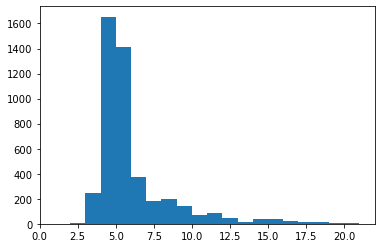

In [120]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [121]:
iters = simulate_robust_filter(G, W, 5, range(N), 1, False)

Result 0: 4    acc: 4.0                                    
Result 1: 4    acc: 4.0                                    
Result 2: 3    acc: 3.6666666666666665                     
Result 3: 3    acc: 3.5                                    
Result 4: 7    acc: 4.2                                    
Result 5: 8    acc: 4.833333333333333                      
Result 6: 4    acc: 4.714285714285714                      
Result 7: 4    acc: 4.625                                  
Result 8: 4    acc: 4.555555555555555                      
Result 9: 4    acc: 4.5                                    
Result 10: 4    acc: 4.454545454545454                     
Result 11: 7    acc: 4.666666666666667                     
Result 12: 7    acc: 4.846153846153846                     
Result 13: 4    acc: 4.785714285714286                     
Result 14: 4    acc: 4.733333333333333                     
Result 15: 4    acc: 4.6875                                
Result 16: 4    acc: 4.647058823529412  

Result 137: 4    acc: 6.521739130434782                    
Result 138: 8    acc: 6.532374100719425                    
Result 139: 9    acc: 6.55                                 
Result 140: 9    acc: 6.567375886524823                    
Result 141: 9    acc: 6.584507042253521                    
Result 142: 9    acc: 6.601398601398602                    
Result 143: 4    acc: 6.583333333333333                    
Result 144: 7    acc: 6.586206896551724                    
Result 145: 7    acc: 6.589041095890411                    
Result 146: 7    acc: 6.591836734693878                    
Result 147: 9    acc: 6.608108108108108                    
Result 148: 9    acc: 6.624161073825503                    
Result 149: 9    acc: 6.64                                 
Result 150: 9    acc: 6.655629139072848                    
Result 151: 9    acc: 6.671052631578948                    
Result 152: 8    acc: 6.6797385620915035                   
Result 153: 9    acc: 6.694805194805195 

Result 274: 22    acc: 6.567272727272727                   
Result 275: 22    acc: 6.6231884057971016                  
Result 276: 22    acc: 6.67870036101083                    
Result 277: 22    acc: 6.733812949640288                   
Result 278: 18    acc: 6.774193548387097                   
Result 279: 4    acc: 6.764285714285714                    
Result 280: 4    acc: 6.754448398576512                    
Result 281: 4    acc: 6.74468085106383                     
Result 282: 5    acc: 6.738515901060071                    
Result 283: 10    acc: 6.75                                
Result 284: 4    acc: 6.7403508771929825                   
Result 285: 4    acc: 6.730769230769231                    
Result 286: 22    acc: 6.7839721254355405                  
Result 287: 5    acc: 6.777777777777778                    
Result 288: 8    acc: 6.782006920415225                    
Result 289: 10    acc: 6.793103448275862                   
Result 290: 25    acc: 6.855670103092783

Result 546: 11    acc: 7.422303473491773                   
Result 547: 3    acc: 7.414233576642336                    
Result 548: 4    acc: 7.408014571948998                    
Result 549: 8    acc: 7.409090909090909                    
Result 550: 4    acc: 7.402903811252268                    
Result 551: 4    acc: 7.396739130434782                    
Result 552: 4    acc: 7.390596745027125                    
Result 553: 4    acc: 7.384476534296029                    
Result 554: 4    acc: 7.378378378378378                    
Result 555: 4    acc: 7.372302158273381                    
Result 556: 4    acc: 7.36624775583483                     
Result 557: 4    acc: 7.360215053763441                    
Result 558: 4    acc: 7.354203935599284                    
Result 559: 4    acc: 7.348214285714286                    
Result 560: 4    acc: 7.342245989304812                    
Result 561: 4    acc: 7.3362989323843415                   
Result 562: 4    acc: 7.3303730017761985

Result 683: 5    acc: 7.0964912280701755                   
Result 684: 3    acc: 7.090510948905109                    
Result 685: 8    acc: 7.091836734693878                    
Result 686: 8    acc: 7.09315866084425                     
Result 687: 8    acc: 7.094476744186046                    
Result 688: 7    acc: 7.09433962264151                     
Result 689: 8    acc: 7.095652173913043                    
Result 690: 8    acc: 7.096960926193922                    
Result 691: 8    acc: 7.098265895953757                    
Result 692: 8    acc: 7.0995670995671                      
Result 693: 8    acc: 7.100864553314121                    
Result 694: 8    acc: 7.102158273381295                    
Result 695: 8    acc: 7.103448275862069                    
Result 696: 8    acc: 7.104734576757532                    
Result 697: 8    acc: 7.106017191977077                    
Result 698: 5    acc: 7.103004291845494                    
Result 699: 8    acc: 7.104285714285714 

Result 821: 3    acc: 7.135036496350365                    
Result 822: 13    acc: 7.142162818955042                   
Result 823: 5    acc: 7.139563106796117                    
Result 824: 5    acc: 7.136969696969697                    
Result 825: 4    acc: 7.13317191283293                     
Result 826: 3    acc: 7.128174123337364                    
Result 827: 4    acc: 7.124396135265701                    
Result 828: 8    acc: 7.125452352231604                    
Result 829: 11    acc: 7.130120481927711                   
Result 830: 4    acc: 7.126353790613718                    
Result 831: 4    acc: 7.122596153846154                    
Result 832: 5    acc: 7.120048019207683                    
Result 833: 5    acc: 7.117505995203837                    
Result 834: 5    acc: 7.11497005988024                     
Result 835: 5    acc: 7.1124401913875595                   
Result 836: 5    acc: 7.109916367980884                    
Result 837: 5    acc: 7.107398568019093 

Result 959: 5    acc: 7.275                                
Result 960: 5    acc: 7.272632674297607                    
Result 961: 4    acc: 7.269230769230769                    
Result 962: 5    acc: 7.266874350986501                    
Result 963: 25    acc: 7.285269709543568                   
Result 964: 5    acc: 7.282901554404145                    
Result 965: 5    acc: 7.280538302277432                    
Result 966: 5    acc: 7.27817993795243                     
Result 967: 5    acc: 7.275826446280992                    
Result 968: 5    acc: 7.273477812177503                    
Result 969: 23    acc: 7.289690721649484                   
Result 970: 11    acc: 7.29351184346035                    
Result 971: 11    acc: 7.2973251028806585                  
Result 972: 8    acc: 7.298047276464542                    
Result 973: 8    acc: 7.298767967145791                    
Result 974: 8    acc: 7.29948717948718                     
Result 975: 9    acc: 7.301229508196721 

Result 1096: 4    acc: 7.228805834092981                   
Result 1097: 4    acc: 7.225865209471767                   
Result 1098: 4    acc: 7.222929936305732                   
Result 1099: 4    acc: 7.22                                
Result 1100: 4    acc: 7.2170753860127155                  
Result 1101: 24    acc: 7.2323049001814885                 
Result 1102: 25    acc: 7.248413417951043                  
Result 1103: 4    acc: 7.245471014492754                   
Result 1104: 17    acc: 7.254298642533937                  
Result 1105: 4    acc: 7.251356238698011                   
Result 1106: 20    acc: 7.262872628726288                  
Result 1107: 6    acc: 7.26173285198556                    
Result 1108: 5    acc: 7.259693417493237                   
Result 1109: 4    acc: 7.256756756756757                   
Result 1110: 4    acc: 7.2538253825382535                  
Result 1111: 4    acc: 7.250899280575539                   
Result 1112: 14    acc: 7.25696316262354

Result 1369: 5    acc: 6.964963503649635                   
Result 1370: 5    acc: 6.963530269876003                   
Result 1371: 5    acc: 6.962099125364431                   
Result 1372: 5    acc: 6.96067006554989                    
Result 1373: 5    acc: 6.95924308588064                    
Result 1374: 4    acc: 6.957090909090909                   
Result 1375: 4    acc: 6.954941860465116                   
Result 1376: 5    acc: 6.953522149600581                   
Result 1377: 4    acc: 6.951378809869376                   
Result 1378: 4    acc: 6.949238578680203                   
Result 1379: 4    acc: 6.947101449275363                   
Result 1380: 4    acc: 6.944967414916727                   
Result 1381: 5    acc: 6.94356005788712                    
Result 1382: 5    acc: 6.942154736080983                   
Result 1383: 5    acc: 6.940751445086705                   
Result 1384: 5    acc: 6.939350180505415                   
Result 1385: 5    acc: 6.937950937950938

Result 1642: 4    acc: 6.962264150943396                   
Result 1643: 8    acc: 6.9628953771289535                  
Result 1644: 8    acc: 6.963525835866261                   
Result 1645: 8    acc: 6.964155528554071                   
Result 1646: 5    acc: 6.962962962962963                   
Result 1647: 4    acc: 6.961165048543689                   
Result 1648: 4    acc: 6.959369314736204                   
Result 1649: 4    acc: 6.957575757575758                   
Result 1650: 5    acc: 6.9563900666262874                  
Result 1651: 5    acc: 6.955205811138015                   
Result 1652: 5    acc: 6.954022988505747                   
Result 1653: 5    acc: 6.952841596130592                   
Result 1654: 5    acc: 6.95166163141994                    
Result 1655: 5    acc: 6.950483091787439                   
Result 1656: 5    acc: 6.9493059746529875                  
Result 1657: 5    acc: 6.948130277442702                   
Result 1658: 5    acc: 6.946955997588909

Result 1915: 5    acc: 7.017223382045929                   
Result 1916: 4    acc: 7.01564945226917                    
Result 1917: 4    acc: 7.014077163712201                   
Result 1918: 4    acc: 7.012506513809275                   
Result 1919: 5    acc: 7.011458333333334                   
Result 1920: 5    acc: 7.0104112441436754                  
Result 1921: 5    acc: 7.009365244536941                   
Result 1922: 5    acc: 7.008320332813312                   
Result 1923: 5    acc: 7.007276507276507                   
Result 1924: 5    acc: 7.006233766233766                   
Result 1925: 5    acc: 7.005192107995846                   
Result 1926: 5    acc: 7.004151530877011                   
Result 1927: 5    acc: 7.003112033195021                   
Result 1928: 5    acc: 7.002073613271125                   
Result 1929: 5    acc: 7.001036269430052                   
Result 1930: 5    acc: 7.0                                 
Result 1931: 5    acc: 6.99896480331263 

Result 2052: 4    acc: 6.928397467121286                   
Result 2053: 4    acc: 6.926971762414801                   
Result 2054: 8    acc: 6.927493917274939                   
Result 2055: 28    acc: 6.937743190661479                  
Result 2056: 2    acc: 6.935342732134176                   
Result 2057: 9    acc: 6.9363459669582115                  
Result 2058: 10    acc: 6.937833899951433                  
Result 2059: 10    acc: 6.939320388349515                  
Result 2060: 9    acc: 6.940320232896652                   
Result 2061: 9    acc: 6.941319107662464                   
Result 2062: 4    acc: 6.9398933591856515                  
Result 2063: 4    acc: 6.938468992248062                   
Result 2064: 4    acc: 6.937046004842615                   
Result 2065: 4    acc: 6.935624394966118                   
Result 2066: 4    acc: 6.934204160619255                   
Result 2067: 4    acc: 6.932785299806576                   
Result 2068: 4    acc: 6.931367810536491

Result 2324: 4    acc: 6.9561290322580644                  
Result 2325: 4    acc: 6.954858125537403                   
Result 2326: 4    acc: 6.95358831113021                    
Result 2327: 4    acc: 6.952319587628866                   
Result 2328: 4    acc: 6.951051953628166                   
Result 2329: 4    acc: 6.949785407725322                   
Result 2330: 4    acc: 6.948519948519949                   
Result 2331: 4    acc: 6.947255574614065                   
Result 2332: 4    acc: 6.945992284612087                   
Result 2333: 4    acc: 6.9447300771208225                  
Result 2334: 4    acc: 6.943468950749464                   
Result 2335: 4    acc: 6.942208904109589                   
Result 2336: 4    acc: 6.940949935815148                   
Result 2337: 4    acc: 6.939692044482464                   
Result 2338: 7    acc: 6.9397178281316805                  
Result 2339: 7    acc: 6.93974358974359                    
Result 2340: 7    acc: 6.939769329346433

Result 2597: 5    acc: 6.968052347959969                   
Result 2598: 5    acc: 6.967295113505195                   
Result 2599: 4    acc: 6.966153846153846                   
Result 2600: 4    acc: 6.965013456362938                   
Result 2601: 4    acc: 6.963873943120676                   
Result 2602: 8    acc: 6.964271993853246                   
Result 2603: 8    acc: 6.964669738863288                   
Result 2604: 5    acc: 6.963915547024952                   
Result 2605: 5    acc: 6.963161933998465                   
Result 2606: 9    acc: 6.963943229766015                   
Result 2607: 9    acc: 6.964723926380368                   
Result 2608: 9    acc: 6.965504024530471                   
Result 2609: 5    acc: 6.964750957854406                   
Result 2610: 5    acc: 6.963998468019915                   
Result 2611: 5    acc: 6.9632465543644715                  
Result 2612: 8    acc: 6.963643321852277                   
Result 2613: 10    acc: 6.96480489671002

Result 2869: 4    acc: 7.108710801393729                   
Result 2870: 4    acc: 7.107628004179729                   
Result 2871: 4    acc: 7.1065459610027855                  
Result 2872: 4    acc: 7.105464671075531                   
Result 2873: 4    acc: 7.104384133611691                   
Result 2874: 4    acc: 7.103304347826087                   
Result 2875: 7    acc: 7.10326842837274                    
Result 2876: 7    acc: 7.103232533889468                   
Result 2877: 7    acc: 7.103196664350243                   
Result 2878: 7    acc: 7.103160819729073                   
Result 2879: 3    acc: 7.101736111111111                   
Result 2880: 3    acc: 7.100312391530719                   
Result 2881: 3    acc: 7.098889659958362                   
Result 2882: 3    acc: 7.097467915365939                   
Result 2883: 3    acc: 7.096047156726768                   
Result 2884: 8    acc: 7.096360485268631                   
Result 2885: 8    acc: 7.096673596673597

Result 3006: 7    acc: 7.011972065181244                   
Result 3007: 7    acc: 7.011968085106383                   
Result 3008: 7    acc: 7.011964107676969                   
Result 3009: 7    acc: 7.011960132890366                   
Result 3010: 7    acc: 7.011956160743939                   
Result 3011: 7    acc: 7.01195219123506                    
Result 3012: 4    acc: 7.010952538997676                   
Result 3013: 4    acc: 7.009953550099535                   
Result 3014: 4    acc: 7.008955223880597                   
Result 3015: 4    acc: 7.007957559681698                   
Result 3016: 7    acc: 7.007954922108055                   
Result 3017: 7    acc: 7.007952286282306                   
Result 3018: 7    acc: 7.007949652202716                   
Result 3019: 7    acc: 7.00794701986755                    
Result 3020: 7    acc: 7.007944389275075                   
Result 3021: 7    acc: 7.00794176042356                    
Result 3022: 7    acc: 7.007939133311281

Result 3278: 15    acc: 7.281488258615432                  
Result 3279: 29    acc: 7.288109756097561                  
Result 3280: 4    acc: 7.28710758914965                    
Result 3281: 15    acc: 7.2894576477757465                 
Result 3282: 15    acc: 7.291806274748706                  
Result 3283: 15    acc: 7.2941534713763705                 
Result 3284: 15    acc: 7.2964992389649925                 
Result 3285: 16    acc: 7.299147900182593                  
Result 3286: 16    acc: 7.301794949802251                  
Result 3287: 15    acc: 7.304136253041363                  
Result 3288: 15    acc: 7.306476132563089                  
Result 3289: 16    acc: 7.309118541033435                  
Result 3290: 17    acc: 7.31206320267396                   
Result 3291: 16    acc: 7.314702308626974                  
Result 3292: 28    acc: 7.320983905253568                  
Result 3293: 16    acc: 7.323618700667881                  
Result 3294: 28    acc: 7.32989377845220

Result 3550: 10    acc: 7.661785412559842                  
Result 3551: 10    acc: 7.662443693693693                  
Result 3552: 10    acc: 7.663101604278075                  
Result 3553: 10    acc: 7.663759144625773                  
Result 3554: 10    acc: 7.664416315049227                  
Result 3555: 10    acc: 7.665073115860517                  
Result 3556: 10    acc: 7.66572954737138                   
Result 3557: 10    acc: 7.666385609893198                  
Result 3558: 10    acc: 7.667041303737005                  
Result 3559: 5    acc: 7.666292134831461                   
Result 3560: 5    acc: 7.665543386689133                   
Result 3561: 5    acc: 7.664795058955643                   
Result 3562: 5    acc: 7.664047151277014                   
Result 3563: 12    acc: 7.665263748597082                  
Result 3564: 12    acc: 7.666479663394109                  
Result 3565: 12    acc: 7.667694896242288                  
Result 3566: 18    acc: 7.67059153350154

Result 3823: 7    acc: 7.934884937238493                   
Result 3824: 6    acc: 7.93437908496732                    
Result 3825: 6    acc: 7.933873497124934                   
Result 3826: 6    acc: 7.93336817350405                    
Result 3827: 6    acc: 7.9328631138975965                  
Result 3828: 6    acc: 7.9323583180987205                  
Result 3829: 6    acc: 7.931853785900783                   
Result 3830: 6    acc: 7.931349517097364                   
Result 3831: 6    acc: 7.9308455114822545                  
Result 3832: 6    acc: 7.930341768849465                   
Result 3833: 6    acc: 7.929838288993219                   
Result 3834: 6    acc: 7.929335071707953                   
Result 3835: 4    acc: 7.928310740354536                   
Result 3836: 4    acc: 7.92728694292416                    
Result 3837: 4    acc: 7.9262636789994785                  
Result 3838: 4    acc: 7.925240948163585                   
Result 3839: 4    acc: 7.92421875       

Result 4095: 4    acc: 8.177978515625                      
Result 4096: 4    acc: 8.1769587503051                     
Result 4097: 3    acc: 8.175695461200586                   
Result 4098: 3    acc: 8.174432788484996                   
Result 4099: 4    acc: 8.173414634146342                   
Result 4100: 4    acc: 8.172396976347232                   
Result 4101: 4    acc: 8.171379814724524                   
Result 4102: 3    acc: 8.170119424811114                   
Result 4103: 3    acc: 8.168859649122806                   
Result 4104: 4    acc: 8.167844092570036                   
Result 4105: 4    acc: 8.1668290306868                     
Result 4106: 4    acc: 8.16581446311176                    
Result 4107: 4    acc: 8.164800389483934                   
Result 4108: 4    acc: 8.163786809442687                   
Result 4109: 4    acc: 8.162773722627737                   
Result 4110: 3    acc: 8.161517878861591                   
Result 4111: 10    acc: 8.16196498054474

Result 4232: 4    acc: 8.315379163713677                   
Result 4233: 4    acc: 8.314359943316013                   
Result 4234: 4    acc: 8.313341204250294                   
Result 4235: 4    acc: 8.312322946175637                   
Result 4236: 9    acc: 8.312485248996932                   
Result 4237: 9    acc: 8.312647475224162                   
Result 4238: 9    acc: 8.312809624911536                   
Result 4239: 9    acc: 8.312971698113207                   
Result 4240: 9    acc: 8.313133694883282                   
Result 4241: 17    acc: 8.315181518151816                  
Result 4242: 4    acc: 8.31416450624558                    
Result 4243: 21    acc: 8.317153628652214                  
Result 4244: 21    acc: 8.320141342756184                  
Result 4245: 17    acc: 8.32218558643429                   
Result 4246: 10    acc: 8.32258064516129                   
Result 4247: 18    acc: 8.324858757062147                  
Result 4248: 18    acc: 8.32713579665803

Result 4504: 8    acc: 8.388235294117647                   
Result 4505: 28    acc: 8.392587660896583                  
Result 4506: 28    acc: 8.396938096294653                  
Result 4507: 27    acc: 8.40106477373558                   
Result 4508: 27    acc: 8.405189620758483                  
Result 4509: 27    acc: 8.409312638580932                  
Result 4510: 27    acc: 8.41343382841942                   
Result 4511: 27    acc: 8.417553191489361                  
Result 4512: 27    acc: 8.421670729005097                  
Result 4513: 28    acc: 8.426007975188304                  
Result 4514: 28    acc: 8.430343300110742                  
Result 4515: 28    acc: 8.434676705048716                  
Result 4516: 28    acc: 8.439008191277397                  
Result 4517: 28    acc: 8.443337760070827                  
Result 4518: 32    acc: 8.448550564284133                  
Result 4519: 33    acc: 8.453982300884956                  
Result 4520: 33    acc: 8.45941163459411

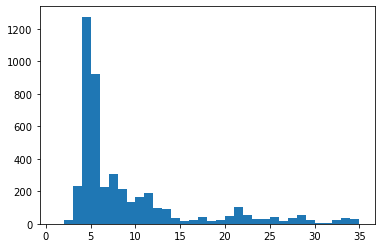

In [122]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

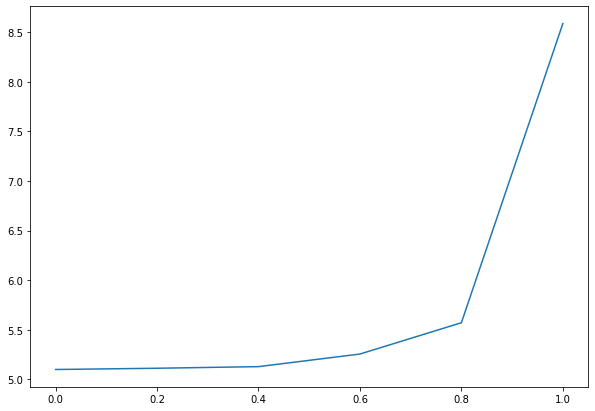

In [19]:
x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = [5.097688617531618, 5.110335804622765, 5.126689925861317, 5.253597906672481, 5.5695595290013085, 8.587658089838639]

plt.figure(figsize=(10, 7))
plt.plot(x, y)
plt.show()

In [7]:
def greedyAppReduceDynamicAll(G, W, V_, root, K, slim, wlim, plim, calcRobust, visitRobust):
    
    V = V_.copy(); N = len(V)

    ans = []; tot = 0
    while len(ans) < K:
        
        E = []
        
        S = [0 for u in range(N)]
        for v in range(N):
            if not V[v]:
                ss = get_size(G, V, v)
                sr = get_size_robust(G, V, root, v)
                if calcRobust:
                    _, S[v] = get_size_weight_robust(G, W, V, root, v)
                else:
                    _, S[v] = get_size_weight(G, W, V, v)
                if (sr / ss) >= plim:
                    E.append(v)
        
        maxv = 0; u = -1
        for v in E:
            s = None
            if calcRobust:
                s = get_size_precalc_robust(G, S, V, root, v)
            else:
                s = get_size_precalc(G, S, V, v)
            if s > maxv and s <= slim and S[v] <= wlim:
                u = v
                maxv = s
                
        if u == -1 and plim > 0:
            
            maxv = 0; u = -1
            for v in range(N):
                if not V[v]:
                    if calcRobust:
                        s = get_size_precalc_robust(G, S, V, root, v)
                    else:
                        s = get_size_precalc(G, S, V, v)
                    if s > maxv and s <= slim and S[v] <= wlim:
                        u = v
                        maxv = s
            
        if u == -1:
            break
        
        x = None
        if visitRobust:
            V, x = visit_robust(G, V, root, u)
        else:
            V, x = visit(G, V, u)
        ans.append(u); tot += x
        
    return ans, tot

In [8]:
def simulate_robust(G, W, k2, S, plim, calcRobust, visitRobust, verbose):
    
    map_prev = {}
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            if not verbose:
                print("                                                           ", end="\r")
                print(f"Search {r}: {t + 1}    now: {R}", end="\r")
            
            if verbose:
                print("it,", t, R)
                
            nn = 0
            for i in range(N):
                if V[i]:
                    nn += 2**i
            
            if t == 0:
                P = init_P
            elif nn in map_prev.keys():
                P = map_prev[nn]
            else:
                if R >= 10:
                    low = 0; high = R
                    while low != high:
                        mid = (low + high) // 2
                        P, sP = greedyAppReduceDynamicAll(G, W, V, root, k2, mid, 1e8, plim, calcRobust, visitRobust)
                        if R - sP < mid:
                            high = mid
                        else:
                            low = mid + 1
                    P, sP = greedyAppReduceDynamicAll(G, W, V, root, k2, low, 1e8, plim, calcRobust, visitRobust)
                    
                    if verbose:
                        print("pre low:", low, R - sP)

                    if low > 1:
                        P_, sP_ = greedyAppReduceDynamicAll(G, W, V, root, k2, low - 1, 1e8, plim, calcRobust, visitRobust)

                        if verbose:
                            print("low:", low, R - sP, R - sP_)

                        if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R):
                            P = P_; sP = sP_
                else:
                    P, sP = greedyAppReduceDynamicAll(G, W, V, root, k2, 1, 1e8, plim, calcRobust, visitRobust)

                map_prev[nn] = P
    
            if verbose:
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))
                print("P: ", ' '.join([str(p) for p in P]))
                plot_sample_no_intersections(G, V, P, geometry, _id)

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [10]:
iters = simulate_robust(G, W, 5, range(N), 0, False, False, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 4    acc: 4.8                                   
Result 15: 4    acc: 4.75                                  
Result 16: 4    acc: 4.705882352941177  

Result 136: 5    acc: 4.905109489051095                    
Result 137: 5    acc: 4.905797101449275                    
Result 138: 5    acc: 4.906474820143885                    
Result 139: 6    acc: 4.914285714285715                    
Result 140: 5    acc: 4.914893617021277                    
Result 141: 5    acc: 4.915492957746479                    
Result 142: 6    acc: 4.923076923076923                    
Result 143: 5    acc: 4.923611111111111                    
Result 144: 4    acc: 4.917241379310345                    
Result 145: 4    acc: 4.910958904109589                    
Result 146: 4    acc: 4.904761904761905                    
Result 147: 5    acc: 4.905405405405405                    
Result 148: 5    acc: 4.906040268456376                    
Result 149: 6    acc: 4.913333333333333                    
Result 150: 5    acc: 4.913907284768212                    
Result 151: 6    acc: 4.921052631578948                    
Result 152: 5    acc: 4.921568627450981 

Result 273: 3    acc: 4.7153284671532845                   
Result 274: 6    acc: 4.72                                 
Result 275: 6    acc: 4.72463768115942                     
Result 276: 6    acc: 4.729241877256317                    
Result 277: 6    acc: 4.733812949640288                    
Result 278: 4    acc: 4.731182795698925                    
Result 279: 5    acc: 4.732142857142857                    
Result 280: 5    acc: 4.733096085409253                    
Result 281: 4    acc: 4.7304964539007095                   
Result 282: 4    acc: 4.72791519434629                     
Result 283: 7    acc: 4.735915492957746                    
Result 284: 5    acc: 4.7368421052631575                   
Result 285: 5    acc: 4.7377622377622375                   
Result 286: 6    acc: 4.7421602787456445                   
Result 287: 3    acc: 4.736111111111111                    
Result 288: 7    acc: 4.743944636678201                    
Result 289: 7    acc: 4.751724137931035 

Result 409: 7    acc: 4.9487804878048784                   
Result 410: 3    acc: 4.9440389294403895                   
Result 411: 3    acc: 4.939320388349515                    
Result 412: 5    acc: 4.939467312348668                    
Result 413: 7    acc: 4.944444444444445                    
Result 414: 5    acc: 4.944578313253012                    
Result 415: 5    acc: 4.944711538461538                    
Result 416: 5    acc: 4.94484412470024                     
Result 417: 4    acc: 4.942583732057416                    
Result 418: 7    acc: 4.947494033412887                    
Result 419: 5    acc: 4.947619047619048                    
Result 420: 5    acc: 4.947743467933492                    
Result 421: 5    acc: 4.947867298578199                    
Result 422: 4    acc: 4.945626477541371                    
Result 423: 5    acc: 4.945754716981132                    
Result 424: 7    acc: 4.950588235294117                    
Result 425: 5    acc: 4.950704225352113 

Result 547: 4    acc: 4.885036496350365                    
Result 548: 5    acc: 4.885245901639344                    
Result 549: 5    acc: 4.885454545454546                    
Result 550: 5    acc: 4.885662431941924                    
Result 551: 5    acc: 4.885869565217392                    
Result 552: 5    acc: 4.886075949367089                    
Result 553: 5    acc: 4.886281588447654                    
Result 554: 5    acc: 4.886486486486486                    
Result 555: 5    acc: 4.886690647482014                    
Result 556: 5    acc: 4.88689407540395                     
Result 557: 5    acc: 4.887096774193548                    
Result 558: 5    acc: 4.887298747763864                    
Result 559: 5    acc: 4.8875                               
Result 560: 5    acc: 4.887700534759358                    
Result 561: 5    acc: 4.887900355871886                    
Result 562: 5    acc: 4.88809946714032                     
Result 563: 4    acc: 4.886524822695035 

Result 685: 4    acc: 4.8425655976676385                   
Result 686: 4    acc: 4.841339155749636                    
Result 687: 5    acc: 4.84156976744186                     
Result 688: 7    acc: 4.844702467343977                    
Result 689: 5    acc: 4.844927536231884                    
Result 690: 5    acc: 4.845151953690304                    
Result 691: 5    acc: 4.845375722543353                    
Result 692: 5    acc: 4.845598845598846                    
Result 693: 5    acc: 4.845821325648415                    
Result 694: 5    acc: 4.846043165467626                    
Result 695: 5    acc: 4.846264367816092                    
Result 696: 4    acc: 4.845050215208034                    
Result 697: 5    acc: 4.845272206303725                    
Result 698: 5    acc: 4.84549356223176                     
Result 699: 4    acc: 4.844285714285714                    
Result 700: 4    acc: 4.843081312410842                    
Result 701: 4    acc: 4.8418803418803416

Result 821: 4    acc: 4.794403892944039                    
Result 822: 5    acc: 4.794653705953827                    
Result 823: 3    acc: 4.79247572815534                     
Result 824: 3    acc: 4.79030303030303                     
Result 825: 4    acc: 4.789346246973365                    
Result 826: 4    acc: 4.7883917775090685                   
Result 827: 5    acc: 4.788647342995169                    
Result 828: 5    acc: 4.788902291917974                    
Result 829: 7    acc: 4.791566265060241                    
Result 830: 4    acc: 4.790613718411552                    
Result 831: 4    acc: 4.789663461538462                    
Result 832: 4    acc: 4.788715486194477                    
Result 833: 4    acc: 4.787769784172662                    
Result 834: 5    acc: 4.788023952095808                    
Result 835: 5    acc: 4.788277511961723                    
Result 836: 5    acc: 4.788530465949821                    
Result 837: 5    acc: 4.788782816229117 

Result 959: 4    acc: 4.780208333333333                    
Result 960: 4    acc: 4.77939646201873                     
Result 961: 5    acc: 4.779625779625779                    
Result 962: 4    acc: 4.778816199376947                    
Result 963: 4    acc: 4.778008298755187                    
Result 964: 3    acc: 4.776165803108809                    
Result 965: 3    acc: 4.774327122153209                    
Result 966: 3    acc: 4.772492244053774                    
Result 967: 3    acc: 4.770661157024794                    
Result 968: 3    acc: 4.768833849329205                    
Result 969: 5    acc: 4.7690721649484535                   
Result 970: 7    acc: 4.771369721936148                    
Result 971: 4    acc: 4.770576131687243                    
Result 972: 7    acc: 4.772867420349435                    
Result 973: 7    acc: 4.775154004106776                    
Result 974: 7    acc: 4.777435897435898                    
Result 975: 7    acc: 4.779713114754099 

Result 1097: 4    acc: 4.760473588342441                   
Result 1098: 4    acc: 4.759781619654231                   
Result 1099: 4    acc: 4.759090909090909                   
Result 1100: 4    acc: 4.758401453224342                   
Result 1101: 5    acc: 4.758620689655173                   
Result 1102: 4    acc: 4.757932910244787                   
Result 1103: 6    acc: 4.759057971014493                   
Result 1104: 6    acc: 4.760180995475113                   
Result 1105: 4    acc: 4.7594936708860756                  
Result 1106: 4    acc: 4.7588075880758804                  
Result 1107: 5    acc: 4.759025270758123                   
Result 1108: 4    acc: 4.75834084761046                    
Result 1109: 4    acc: 4.757657657657657                   
Result 1110: 4    acc: 4.756975697569757                   
Result 1111: 4    acc: 4.756294964028777                   
Result 1112: 6    acc: 4.757412398921833                   
Result 1113: 4    acc: 4.756732495511669

Result 1235: 5    acc: 4.7200647249190935                  
Result 1236: 5    acc: 4.720291026677446                   
Result 1237: 5    acc: 4.720516962843296                   
Result 1238: 5    acc: 4.7207425343018565                  
Result 1239: 5    acc: 4.720967741935484                   
Result 1240: 5    acc: 4.72119258662369                    
Result 1241: 5    acc: 4.721417069243156                   
Result 1242: 4    acc: 4.720836685438456                   
Result 1243: 4    acc: 4.720257234726688                   
Result 1244: 5    acc: 4.720481927710844                   
Result 1245: 4    acc: 4.719903691813804                   
Result 1246: 4    acc: 4.719326383319968                   
Result 1247: 4    acc: 4.71875                             
Result 1248: 5    acc: 4.718975180144115                   
Result 1249: 5    acc: 4.7192                              
Result 1250: 5    acc: 4.719424460431655                   
Result 1251: 5    acc: 4.719648562300319

Result 1373: 5    acc: 4.710334788937409                   
Result 1374: 4    acc: 4.709818181818182                   
Result 1375: 4    acc: 4.709302325581396                   
Result 1376: 5    acc: 4.709513435003631                   
Result 1377: 5    acc: 4.709724238026125                   
Result 1378: 5    acc: 4.709934735315446                   
Result 1379: 5    acc: 4.7101449275362315                  
Result 1380: 5    acc: 4.710354815351195                   
Result 1381: 5    acc: 4.710564399421129                   
Result 1382: 5    acc: 4.710773680404917                   
Result 1383: 5    acc: 4.710982658959537                   
Result 1384: 5    acc: 4.7111913357400725                  
Result 1385: 5    acc: 4.711399711399712                   
Result 1386: 5    acc: 4.711607786589762                   
Result 1387: 4    acc: 4.711095100864553                   
Result 1388: 4    acc: 4.7105831533477325                  
Result 1389: 5    acc: 4.710791366906474

Result 1509: 5    acc: 4.70728476821192                    
Result 1510: 5    acc: 4.70747849106552                    
Result 1511: 4    acc: 4.707010582010582                   
Result 1512: 4    acc: 4.706543291473893                   
Result 1513: 4    acc: 4.706076618229854                   
Result 1514: 4    acc: 4.705610561056106                   
Result 1515: 4    acc: 4.705145118733509                   
Result 1516: 5    acc: 4.705339485827291                   
Result 1517: 5    acc: 4.705533596837944                   
Result 1518: 4    acc: 4.7050691244239635                  
Result 1519: 4    acc: 4.7046052631578945                  
Result 1520: 4    acc: 4.704142011834319                   
Result 1521: 4    acc: 4.7036793692509855                  
Result 1522: 4    acc: 4.703217334208799                   
Result 1523: 4    acc: 4.702755905511811                   
Result 1524: 4    acc: 4.702295081967213                   
Result 1525: 5    acc: 4.702490170380079

Result 1645: 6    acc: 4.707776427703524                   
Result 1646: 4    acc: 4.707346690953249                   
Result 1647: 5    acc: 4.70752427184466                    
Result 1648: 5    acc: 4.7077016373559735                  
Result 1649: 4    acc: 4.707272727272727                   
Result 1650: 4    acc: 4.706844336765597                   
Result 1651: 4    acc: 4.706416464891041                   
Result 1652: 4    acc: 4.705989110707804                   
Result 1653: 4    acc: 4.705562273276905                   
Result 1654: 4    acc: 4.705135951661632                   
Result 1655: 5    acc: 4.705314009661835                   
Result 1656: 4    acc: 4.7048883524441765                  
Result 1657: 4    acc: 4.704463208685163                   
Result 1658: 4    acc: 4.704038577456299                   
Result 1659: 4    acc: 4.703614457831326                   
Result 1660: 4    acc: 4.703190848886213                   
Result 1661: 4    acc: 4.702767749699158

Result 1781: 4    acc: 4.681257014590348                   
Result 1782: 5    acc: 4.681435782389231                   
Result 1783: 5    acc: 4.681614349775785                   
Result 1784: 5    acc: 4.681792717086835                   
Result 1785: 5    acc: 4.681970884658455                   
Result 1786: 5    acc: 4.682148852825965                   
Result 1787: 5    acc: 4.682326621923937                   
Result 1788: 5    acc: 4.682504192286193                   
Result 1789: 4    acc: 4.682122905027933                   
Result 1790: 4    acc: 4.681742043551089                   
Result 1791: 4    acc: 4.681361607142857                   
Result 1792: 4    acc: 4.680981595092025                   
Result 1793: 4    acc: 4.6806020066889635                  
Result 1794: 6    acc: 4.68133704735376                    
Result 1795: 7    acc: 4.682628062360802                   
Result 1796: 5    acc: 4.682804674457429                   
Result 1797: 3    acc: 4.681868743047831

Result 1919: 5    acc: 4.675520833333334                   
Result 1920: 5    acc: 4.675689744924519                   
Result 1921: 5    acc: 4.67585848074922                    
Result 1922: 5    acc: 4.676027041081643                   
Result 1923: 4    acc: 4.675675675675675                   
Result 1924: 4    acc: 4.675324675324675                   
Result 1925: 4    acc: 4.674974039460021                   
Result 1926: 4    acc: 4.674623767514271                   
Result 1927: 4    acc: 4.674273858921162                   
Result 1928: 4    acc: 4.673924313115604                   
Result 1929: 4    acc: 4.6735751295336785                  
Result 1930: 4    acc: 4.673226307612636                   
Result 1931: 4    acc: 4.6728778467908905                  
Result 1932: 4    acc: 4.672529746508019                   
Result 1933: 4    acc: 4.672182006204757                   
Result 1934: 4    acc: 4.671834625322997                   
Result 1935: 6    acc: 4.672520661157025

Result 2056: 5    acc: 4.6708799222168205                  
Result 2057: 5    acc: 4.671039844509233                   
Result 2058: 5    acc: 4.671199611461875                   
Result 2059: 5    acc: 4.671359223300971                   
Result 2060: 5    acc: 4.671518680252305                   
Result 2061: 5    acc: 4.6716779825412225                  
Result 2062: 5    acc: 4.671837130392632                   
Result 2063: 5    acc: 4.671996124031008                   
Result 2064: 5    acc: 4.672154963680388                   
Result 2065: 5    acc: 4.672313649564376                   
Result 2066: 5    acc: 4.672472181906144                   
Result 2067: 5    acc: 4.672630560928433                   
Result 2068: 5    acc: 4.672788786853553                   
Result 2069: 6    acc: 4.673429951690821                   
Result 2070: 5    acc: 4.673587638821825                   
Result 2071: 5    acc: 4.673745173745174                   
Result 2072: 4    acc: 4.673420164013507

Result 2194: 4    acc: 4.641913439635536                   
Result 2195: 4    acc: 4.641621129326047                   
Result 2196: 4    acc: 4.641329085116068                   
Result 2197: 4    acc: 4.641037306642402                   
Result 2198: 4    acc: 4.64074579354252                    
Result 2199: 4    acc: 4.640454545454546                   
Result 2200: 4    acc: 4.640163562017265                   
Result 2201: 4    acc: 4.639872842870118                   
Result 2202: 4    acc: 4.6395823876532                     
Result 2203: 4    acc: 4.6392921960072595                  
Result 2204: 4    acc: 4.639002267573696                   
Result 2205: 4    acc: 4.63871260199456                    
Result 2206: 4    acc: 4.638423198912551                   
Result 2207: 4    acc: 4.638134057971015                   
Result 2208: 4    acc: 4.637845178813943                   
Result 2209: 4    acc: 4.637556561085973                   
Result 2210: 4    acc: 4.637268204432384

Result 2332: 5    acc: 4.619802828975568                   
Result 2333: 4    acc: 4.619537275064268                   
Result 2334: 6    acc: 4.620128479657388                   
Result 2335: 4    acc: 4.61986301369863                    
Result 2336: 4    acc: 4.619597774925118                   
Result 2337: 4    acc: 4.619332763045338                   
Result 2338: 4    acc: 4.619067977768277                   
Result 2339: 4    acc: 4.618803418803418                   
Result 2340: 4    acc: 4.618539085860744                   
Result 2341: 4    acc: 4.618274978650726                   
Result 2342: 4    acc: 4.618011096884336                   
Result 2343: 4    acc: 4.617747440273037                   
Result 2344: 4    acc: 4.617484008528785                   
Result 2345: 4    acc: 4.617220801364024                   
Result 2346: 4    acc: 4.6169578184916915                  
Result 2347: 4    acc: 4.616695059625213                   
Result 2348: 5    acc: 4.616858237547893

Result 2469: 7    acc: 4.682591093117409                   
Result 2470: 7    acc: 4.683528935653581                   
Result 2471: 7    acc: 4.684466019417476                   
Result 2472: 7    acc: 4.6854023453295595                  
Result 2473: 7    acc: 4.686337914308812                   
Result 2474: 7    acc: 4.6872727272727275                  
Result 2475: 7    acc: 4.688206785137318                   
Result 2476: 7    acc: 4.689140088817117                   
Result 2477: 7    acc: 4.690072639225182                   
Result 2478: 7    acc: 4.691004437273094                   
Result 2479: 4    acc: 4.690725806451613                   
Result 2480: 7    acc: 4.691656590084643                   
Result 2481: 7    acc: 4.6925866236905724                  
Result 2482: 7    acc: 4.693515908175594                   
Result 2483: 7    acc: 4.694444444444445                   
Result 2484: 7    acc: 4.695372233400402                   
Result 2485: 7    acc: 4.696299275945294

Result 2605: 4    acc: 4.7122026093630085                  
Result 2606: 4    acc: 4.71192942079018                    
Result 2607: 4    acc: 4.711656441717792                   
Result 2608: 4    acc: 4.711383671904945                   
Result 2609: 4    acc: 4.711111111111111                   
Result 2610: 4    acc: 4.710838759096132                   
Result 2611: 4    acc: 4.710566615620214                   
Result 2612: 4    acc: 4.710294680443934                   
Result 2613: 4    acc: 4.710022953328233                   
Result 2614: 6    acc: 4.7105162523900574                  
Result 2615: 5    acc: 4.710626911314985                   
Result 2616: 5    acc: 4.710737485670615                   
Result 2617: 5    acc: 4.7108479755538575                  
Result 2618: 5    acc: 4.710958381061474                   
Result 2619: 5    acc: 4.711068702290076                   
Result 2620: 6    acc: 4.711560473101869                   
Result 2621: 5    acc: 4.711670480549199

Result 2743: 4    acc: 4.705174927113703                   
Result 2744: 5    acc: 4.70528233151184                    
Result 2745: 3    acc: 4.704661325564458                   
Result 2746: 4    acc: 4.704404805242082                   
Result 2747: 4    acc: 4.704148471615721                   
Result 2748: 5    acc: 4.704256093124773                   
Result 2749: 5    acc: 4.704363636363636                   
Result 2750: 5    acc: 4.704471101417666                   
Result 2751: 5    acc: 4.704578488372093                   
Result 2752: 7    acc: 4.705412277515438                   
Result 2753: 5    acc: 4.705519244734931                   
Result 2754: 5    acc: 4.70562613430127                    
Result 2755: 5    acc: 4.705732946298984                   
Result 2756: 6    acc: 4.70620239390642                    
Result 2757: 6    acc: 4.706671501087745                   
Result 2758: 6    acc: 4.707140268213121                   
Result 2759: 5    acc: 4.707246376811594

Result 2880: 8    acc: 4.721624435959736                   
Result 2881: 8    acc: 4.722761970853574                   
Result 2882: 8    acc: 4.723898716614637                   
Result 2883: 8    acc: 4.7250346740638                     
Result 2884: 8    acc: 4.726169844020797                   
Result 2885: 8    acc: 4.727304227304227                   
Result 2886: 8    acc: 4.7284378247315555                  
Result 2887: 8    acc: 4.729570637119114                   
Result 2888: 8    acc: 4.730702665282105                   
Result 2889: 8    acc: 4.731833910034602                   
Result 2890: 8    acc: 4.732964372189554                   
Result 2891: 8    acc: 4.734094052558783                   
Result 2892: 8    acc: 4.73522295195299                    
Result 2893: 8    acc: 4.736351071181756                   
Result 2894: 8    acc: 4.737478411053541                   
Result 2895: 8    acc: 4.738604972375691                   
Result 2896: 8    acc: 4.739730755954436

Result 3017: 4    acc: 4.730947647448642                   
Result 3018: 4    acc: 4.730705531632991                   
Result 3019: 4    acc: 4.73046357615894                    
Result 3020: 4    acc: 4.730221780867263                   
Result 3021: 4    acc: 4.729980145598941                   
Result 3022: 4    acc: 4.729738670195171                   
Result 3023: 4    acc: 4.729497354497354                   
Result 3024: 4    acc: 4.729256198347107                   
Result 3025: 4    acc: 4.729015201586252                   
Result 3026: 4    acc: 4.728774364056822                   
Result 3027: 4    acc: 4.7285336856010565                  
Result 3028: 4    acc: 4.728293166061406                   
Result 3029: 4    acc: 4.728052805280528                   
Result 3030: 4    acc: 4.727812603101286                   
Result 3031: 4    acc: 4.727572559366755                   
Result 3032: 4    acc: 4.727332673920211                   
Result 3033: 4    acc: 4.727092946605142

Result 3153: 6    acc: 4.7428662016487                     
Result 3154: 5    acc: 4.7429477020602215                  
Result 3155: 7    acc: 4.743662864385298                   
Result 3156: 4    acc: 4.743427304402914                   
Result 3157: 4    acc: 4.743191893603546                   
Result 3158: 4    acc: 4.74295663184552                    
Result 3159: 4    acc: 4.7427215189873415                  
Result 3160: 4    acc: 4.7424865548876936                  
Result 3161: 5    acc: 4.742567994939911                   
Result 3162: 5    acc: 4.742649383496681                   
Result 3163: 5    acc: 4.7427307206068265                  
Result 3164: 6    acc: 4.743127962085308                   
Result 3165: 5    acc: 4.743209096651927                   
Result 3166: 5    acc: 4.743290179981055                   
Result 3167: 4    acc: 4.743055555555555                   
Result 3168: 4    acc: 4.742821079204797                   
Result 3169: 6    acc: 4.743217665615142

Result 3290: 5    acc: 4.7599513825584925                  
Result 3291: 6    acc: 4.7603280680437425                  
Result 3292: 6    acc: 4.760704524749468                   
Result 3293: 6    acc: 4.761080752884031                   
Result 3294: 6    acc: 4.761456752655539                   
Result 3295: 5    acc: 4.761529126213592                   
Result 3296: 5    acc: 4.761601455868972                   
Result 3297: 5    acc: 4.761673741661613                   
Result 3298: 6    acc: 4.762049105789633                   
Result 3299: 6    acc: 4.762424242424243                   
Result 3300: 6    acc: 4.762799151772191                   
Result 3301: 6    acc: 4.763173834039976                   
Result 3302: 6    acc: 4.763548289433848                   
Result 3303: 6    acc: 4.763922518159807                   
Result 3304: 5    acc: 4.763993948562784                   
Result 3305: 6    acc: 4.764367816091954                   
Result 3306: 5    acc: 4.764439068642274

Result 3427: 5    acc: 4.789673278879813                   
Result 3428: 5    acc: 4.78973461650627                    
Result 3429: 4    acc: 4.789504373177842                   
Result 3430: 4    acc: 4.789274264062955                   
Result 3431: 4    acc: 4.7890442890442895                  
Result 3432: 7    acc: 4.789688319254297                   
Result 3433: 4    acc: 4.789458357600466                   
Result 3434: 5    acc: 4.789519650655022                   
Result 3435: 4    acc: 4.7892898719441215                  
Result 3436: 4    acc: 4.789060226942101                   
Result 3437: 5    acc: 4.7891215823153                     
Result 3438: 5    acc: 4.789182902006397                   
Result 3439: 5    acc: 4.789244186046512                   
Result 3440: 5    acc: 4.7893054344667245                  
Result 3441: 5    acc: 4.789366647298083                   
Result 3442: 6    acc: 4.789718268951495                   
Result 3443: 5    acc: 4.789779326364692

Result 3563: 6    acc: 4.817620650953985                   
Result 3564: 6    acc: 4.817952314165498                   
Result 3565: 6    acc: 4.818283791362871                   
Result 3566: 5    acc: 4.818334735071488                   
Result 3567: 6    acc: 4.818665919282512                   
Result 3568: 6    acc: 4.818996917904175                   
Result 3569: 6    acc: 4.819327731092437                   
Result 3570: 6    acc: 4.81965835900308                    
Result 3571: 5    acc: 4.819708846584547                   
Result 3572: 6    acc: 4.820039182759586                   
Result 3573: 6    acc: 4.820369334079463                   
Result 3574: 6    acc: 4.8206993006993                     
Result 3575: 6    acc: 4.821029082774049                   
Result 3576: 6    acc: 4.821358680458485                   
Result 3577: 5    acc: 4.821408608160984                   
Result 3578: 6    acc: 4.821737915618888                   
Result 3579: 4    acc: 4.821508379888268

Result 3700: 4    acc: 4.833558497703323                   
Result 3701: 4    acc: 4.833333333333333                   
Result 3702: 5    acc: 4.833378341884958                   
Result 3703: 5    acc: 4.833423326133909                   
Result 3704: 4    acc: 4.8331983805668015                  
Result 3705: 4    acc: 4.832973556395035                   
Result 3706: 4    acc: 4.832748853520367                   
Result 3707: 4    acc: 4.83252427184466                    
Result 3708: 4    acc: 4.832299811269884                   
Result 3709: 4    acc: 4.832075471698113                   
Result 3710: 4    acc: 4.831851253031528                   
Result 3711: 4    acc: 4.831627155172414                   
Result 3712: 4    acc: 4.831403178023161                   
Result 3713: 4    acc: 4.831179321486268                   
Result 3714: 4    acc: 4.830955585464333                   
Result 3715: 4    acc: 4.830731969860064                   
Result 3716: 4    acc: 4.830508474576271

Result 3839: 5    acc: 4.8296875                           
Result 3840: 5    acc: 4.8297318406664935                  
Result 3841: 5    acc: 4.829776158250911                   
Result 3842: 4    acc: 4.829560239396305                   
Result 3843: 8    acc: 4.830385015608741                   
Result 3844: 4    acc: 4.830169050715215                   
Result 3845: 4    acc: 4.829953198127925                   
Result 3846: 4    acc: 4.829737457759293                   
Result 3847: 4    acc: 4.82952182952183                    
Result 3848: 5    acc: 4.829566121070408                   
Result 3849: 4    acc: 4.8293506493506495                  
Result 3850: 4    acc: 4.829135289535186                   
Result 3851: 8    acc: 4.829958463136033                   
Result 3852: 8    acc: 4.830781209447184                   
Result 3853: 8    acc: 4.831603528801246                   
Result 3854: 8    acc: 4.83242542153048                    
Result 3855: 8    acc: 4.833246887966805

Result 3976: 6    acc: 4.849132511943676                   
Result 3977: 4    acc: 4.848919054801407                   
Result 3978: 4    acc: 4.8487057049509925                  
Result 3979: 5    acc: 4.8487437185929645                  
Result 3980: 5    acc: 4.848781713137402                   
Result 3981: 5    acc: 4.848819688598694                   
Result 3982: 5    acc: 4.848857644991213                   
Result 3983: 4    acc: 4.848644578313253                   
Result 3984: 4    acc: 4.848431618569636                   
Result 3985: 4    acc: 4.84821876567988                    
Result 3986: 4    acc: 4.848006019563582                   
Result 3987: 4    acc: 4.847793380140422                   
Result 3988: 4    acc: 4.847580847330158                   
Result 3989: 5    acc: 4.847619047619047                   
Result 3990: 4    acc: 4.8474066649962415                  
Result 3991: 5    acc: 4.847444889779559                   
Result 3992: 4    acc: 4.847232657150013

Result 4113: 5    acc: 4.833981526494895                   
Result 4114: 5    acc: 4.834021871202916                   
Result 4115: 5    acc: 4.834062196307094                   
Result 4116: 4    acc: 4.833859606509594                   
Result 4117: 4    acc: 4.83365711510442                    
Result 4118: 4    acc: 4.833454722019908                   
Result 4119: 4    acc: 4.833252427184466                   
Result 4120: 4    acc: 4.833050230526571                   
Result 4121: 4    acc: 4.832848131974769                   
Result 4122: 4    acc: 4.832646131457676                   
Result 4123: 5    acc: 4.832686711930165                   
Result 4124: 5    acc: 4.832727272727273                   
Result 4125: 5    acc: 4.832767813863306                   
Result 4126: 5    acc: 4.832808335352556                   
Result 4127: 5    acc: 4.832848837209302                   
Result 4128: 5    acc: 4.832889319447808                   
Result 4129: 5    acc: 4.832929782082324

Result 4250: 7    acc: 4.841919548341567                   
Result 4251: 4    acc: 4.841721542803387                   
Result 4252: 4    acc: 4.841523630378556                   
Result 4253: 4    acc: 4.84132581100141                    
Result 4254: 6    acc: 4.84159811985899                    
Result 4255: 5    acc: 4.841635338345864                   
Result 4256: 5    acc: 4.841672539346958                   
Result 4257: 4    acc: 4.841474870831377                   
Result 4258: 4    acc: 4.8412772951397045                  
Result 4259: 4    acc: 4.841079812206573                   
Result 4260: 4    acc: 4.840882421966675                   
Result 4261: 7    acc: 4.841389019239793                   
Result 4262: 5    acc: 4.841426225662679                   
Result 4263: 5    acc: 4.841463414634147                   
Result 4264: 5    acc: 4.841500586166472                   
Result 4265: 6    acc: 4.841772151898734                   
Result 4266: 6    acc: 4.842043590344504

Result 4387: 6    acc: 4.851412944393801                   
Result 4388: 6    acc: 4.851674641148326                   
Result 4389: 5    acc: 4.851708428246013                   
Result 4390: 5    acc: 4.851742199954452                   
Result 4391: 5    acc: 4.851775956284153                   
Result 4392: 5    acc: 4.851809697245618                   
Result 4393: 4    acc: 4.851615839781521                   
Result 4394: 5    acc: 4.851649601820251                   
Result 4395: 5    acc: 4.851683348498635                   
Result 4396: 5    acc: 4.8517170798271545                  
Result 4397: 4    acc: 4.851523419736243                   
Result 4398: 3    acc: 4.85110252330075                    
Result 4399: 3    acc: 4.850681818181818                   
Result 4400: 4    acc: 4.850488525335151                   
Result 4401: 4    acc: 4.85029532030895                    
Result 4402: 5    acc: 4.850329320917556                   
Result 4403: 5    acc: 4.850363306085377

Result 4523: 5    acc: 4.845711759504863                   
Result 4524: 5    acc: 4.845745856353592                   
Result 4525: 5    acc: 4.845779938135219                   
Result 4526: 5    acc: 4.84581400485973                    
Result 4527: 5    acc: 4.845848056537102                   
Result 4528: 5    acc: 4.845882093177302                   
Result 4529: 5    acc: 4.845916114790287                   
Result 4530: 5    acc: 4.845950121386007                   
Result 4531: 5    acc: 4.845984112974405                   
Result 4532: 5    acc: 4.846018089565409                   
Result 4533: 5    acc: 4.846052051168946                   
Result 4534: 5    acc: 4.846085997794928                   
Result 4535: 5    acc: 4.846119929453263                   
Result 4536: 5    acc: 4.846153846153846                   
Result 4537: 5    acc: 4.8461877479065665                  
Result 4538: 5    acc: 4.846221634721304                   
Result 4539: 5    acc: 4.846255506607929

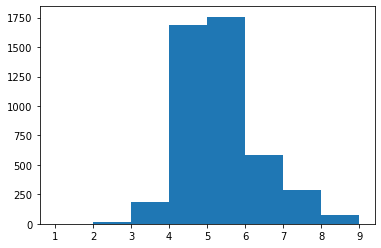

In [11]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [12]:
iters = simulate_robust(G, W, 5, range(N), 0.4, False, False, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 4    acc: 4.8                                   
Result 15: 4    acc: 4.75                                  
Result 16: 4    acc: 4.705882352941177  

Result 136: 5    acc: 4.861313868613139                    
Result 137: 5    acc: 4.86231884057971                     
Result 138: 5    acc: 4.863309352517986                    
Result 139: 5    acc: 4.864285714285714                    
Result 140: 5    acc: 4.865248226950355                    
Result 141: 5    acc: 4.866197183098592                    
Result 142: 5    acc: 4.8671328671328675                   
Result 143: 5    acc: 4.868055555555555                    
Result 144: 4    acc: 4.862068965517241                    
Result 145: 4    acc: 4.8561643835616435                   
Result 146: 4    acc: 4.850340136054422                    
Result 147: 5    acc: 4.851351351351352                    
Result 148: 5    acc: 4.852348993288591                    
Result 149: 5    acc: 4.8533333333333335                   
Result 150: 5    acc: 4.854304635761589                    
Result 151: 5    acc: 4.855263157894737                    
Result 152: 5    acc: 4.856209150326797 

Result 274: 5    acc: 4.7272727272727275                   
Result 275: 5    acc: 4.728260869565218                    
Result 276: 5    acc: 4.729241877256317                    
Result 277: 5    acc: 4.73021582733813                     
Result 278: 6    acc: 4.734767025089606                    
Result 279: 5    acc: 4.735714285714286                    
Result 280: 5    acc: 4.736654804270462                    
Result 281: 5    acc: 4.73758865248227                     
Result 282: 4    acc: 4.734982332155477                    
Result 283: 7    acc: 4.742957746478873                    
Result 284: 5    acc: 4.743859649122807                    
Result 285: 5    acc: 4.744755244755245                    
Result 286: 6    acc: 4.7491289198606275                   
Result 287: 3    acc: 4.743055555555555                    
Result 288: 7    acc: 4.750865051903114                    
Result 289: 7    acc: 4.758620689655173                    
Result 290: 5    acc: 4.759450171821306 

Result 410: 3    acc: 4.961070559610706                    
Result 411: 3    acc: 4.956310679611651                    
Result 412: 5    acc: 4.956416464891041                    
Result 413: 7    acc: 4.961352657004831                    
Result 414: 5    acc: 4.96144578313253                     
Result 415: 5    acc: 4.961538461538462                    
Result 416: 4    acc: 4.959232613908873                    
Result 417: 4    acc: 4.956937799043062                    
Result 418: 5    acc: 4.957040572792363                    
Result 419: 5    acc: 4.957142857142857                    
Result 420: 5    acc: 4.957244655581948                    
Result 421: 5    acc: 4.957345971563981                    
Result 422: 4    acc: 4.955082742316785                    
Result 423: 5    acc: 4.955188679245283                    
Result 424: 7    acc: 4.96                                 
Result 425: 5    acc: 4.960093896713615                    
Result 426: 4    acc: 4.95784543325527  

Result 547: 5    acc: 4.881386861313868                    
Result 548: 6    acc: 4.883424408014572                    
Result 549: 5    acc: 4.883636363636364                    
Result 550: 6    acc: 4.885662431941924                    
Result 551: 6    acc: 4.88768115942029                     
Result 552: 6    acc: 4.8896925858951175                   
Result 553: 6    acc: 4.891696750902527                    
Result 554: 6    acc: 4.8936936936936934                   
Result 555: 6    acc: 4.89568345323741                     
Result 556: 6    acc: 4.897666068222621                    
Result 557: 6    acc: 4.899641577060932                    
Result 558: 6    acc: 4.901610017889087                    
Result 559: 6    acc: 4.9035714285714285                   
Result 560: 6    acc: 4.905525846702317                    
Result 561: 6    acc: 4.907473309608541                    
Result 562: 5    acc: 4.907637655417407                    
Result 563: 4    acc: 4.906028368794326 

Result 685: 4    acc: 4.846938775510204                    
Result 686: 4    acc: 4.84570596797671                     
Result 687: 5    acc: 4.84593023255814                     
Result 688: 7    acc: 4.849056603773585                    
Result 689: 5    acc: 4.84927536231884                     
Result 690: 5    acc: 4.849493487698987                    
Result 691: 5    acc: 4.8497109826589595                   
Result 692: 5    acc: 4.84992784992785                     
Result 693: 5    acc: 4.85014409221902                     
Result 694: 5    acc: 4.850359712230216                    
Result 695: 5    acc: 4.850574712643678                    
Result 696: 4    acc: 4.8493543758967                      
Result 697: 5    acc: 4.849570200573066                    
Result 698: 5    acc: 4.849785407725322                    
Result 699: 4    acc: 4.848571428571429                    
Result 700: 4    acc: 4.847360912981455                    
Result 701: 4    acc: 4.846153846153846 

Result 821: 5    acc: 4.788321167883212                    
Result 822: 5    acc: 4.788578371810449                    
Result 823: 3    acc: 4.786407766990291                    
Result 824: 3    acc: 4.784242424242424                    
Result 825: 4    acc: 4.783292978208232                    
Result 826: 4    acc: 4.782345828295043                    
Result 827: 5    acc: 4.782608695652174                    
Result 828: 5    acc: 4.782870928829915                    
Result 829: 7    acc: 4.785542168674699                    
Result 830: 4    acc: 4.78459687123947                     
Result 831: 4    acc: 4.783653846153846                    
Result 832: 4    acc: 4.782713085234094                    
Result 833: 4    acc: 4.781774580335731                    
Result 834: 5    acc: 4.782035928143713                    
Result 835: 5    acc: 4.782296650717703                    
Result 836: 5    acc: 4.782556750298686                    
Result 837: 5    acc: 4.782816229116945 

Result 957: 4    acc: 4.777661795407098                    
Result 958: 4    acc: 4.776850886339937                    
Result 959: 4    acc: 4.776041666666667                    
Result 960: 4    acc: 4.775234131113423                    
Result 961: 5    acc: 4.775467775467775                    
Result 962: 4    acc: 4.77466251298027                     
Result 963: 4    acc: 4.773858921161826                    
Result 964: 3    acc: 4.772020725388601                    
Result 965: 3    acc: 4.770186335403727                    
Result 966: 3    acc: 4.7683557394002065                   
Result 967: 3    acc: 4.766528925619835                    
Result 968: 3    acc: 4.764705882352941                    
Result 969: 6    acc: 4.765979381443299                    
Result 970: 7    acc: 4.768280123583934                    
Result 971: 4    acc: 4.767489711934156                    
Result 972: 7    acc: 4.76978417266187                     
Result 973: 7    acc: 4.772073921971253 

Result 1095: 4    acc: 4.779197080291971                   
Result 1096: 4    acc: 4.77848678213309                    
Result 1097: 4    acc: 4.777777777777778                   
Result 1098: 4    acc: 4.777070063694268                   
Result 1099: 4    acc: 4.776363636363636                   
Result 1100: 4    acc: 4.775658492279746                   
Result 1101: 7    acc: 4.777676950998185                   
Result 1102: 4    acc: 4.7769718948322755                  
Result 1103: 4    acc: 4.776268115942029                   
Result 1104: 7    acc: 4.778280542986425                   
Result 1105: 4    acc: 4.77757685352622                    
Result 1106: 4    acc: 4.77687443541102                    
Result 1107: 5    acc: 4.777075812274369                   
Result 1108: 4    acc: 4.776375112714157                   
Result 1109: 4    acc: 4.775675675675676                   
Result 1110: 4    acc: 4.7749774977497745                  
Result 1111: 4    acc: 4.774280575539568

Result 1231: 4    acc: 4.729707792207792                   
Result 1232: 4    acc: 4.72911597729116                    
Result 1233: 4    acc: 4.728525121555916                   
Result 1234: 4    acc: 4.727935222672064                   
Result 1235: 4    acc: 4.727346278317152                   
Result 1236: 4    acc: 4.726758286176233                   
Result 1237: 4    acc: 4.726171243941842                   
Result 1238: 4    acc: 4.725585149313963                   
Result 1239: 4    acc: 4.725                               
Result 1240: 4    acc: 4.724415793714746                   
Result 1241: 5    acc: 4.72463768115942                    
Result 1242: 4    acc: 4.7240547063555915                  
Result 1243: 4    acc: 4.723472668810289                   
Result 1244: 5    acc: 4.723694779116466                   
Result 1245: 4    acc: 4.723113964686998                   
Result 1246: 4    acc: 4.7225340817963115                  
Result 1247: 4    acc: 4.721955128205129

Result 1367: 5    acc: 4.6988304093567255                  
Result 1368: 5    acc: 4.699050401753104                   
Result 1369: 5    acc: 4.699270072992701                   
Result 1370: 5    acc: 4.699489423778264                   
Result 1371: 5    acc: 4.699708454810495                   
Result 1372: 5    acc: 4.699927166788055                   
Result 1373: 5    acc: 4.700145560407569                   
Result 1374: 4    acc: 4.699636363636364                   
Result 1375: 4    acc: 4.699127906976744                   
Result 1376: 5    acc: 4.699346405228758                   
Result 1377: 5    acc: 4.699564586357039                   
Result 1378: 5    acc: 4.699782451051487                   
Result 1379: 5    acc: 4.7                                 
Result 1380: 5    acc: 4.700217233888487                   
Result 1381: 5    acc: 4.7004341534008685                  
Result 1382: 5    acc: 4.700650759219089                   
Result 1383: 5    acc: 4.700867052023121

Result 1505: 5    acc: 4.705843293492696                   
Result 1506: 5    acc: 4.706038487060385                   
Result 1507: 5    acc: 4.706233421750663                   
Result 1508: 5    acc: 4.706428098078198                   
Result 1509: 5    acc: 4.706622516556291                   
Result 1510: 5    acc: 4.70681667769689                    
Result 1511: 3    acc: 4.705687830687831                   
Result 1512: 4    acc: 4.70522141440846                    
Result 1513: 4    acc: 4.704755614266843                   
Result 1514: 4    acc: 4.704290429042905                   
Result 1515: 4    acc: 4.703825857519789                   
Result 1516: 5    acc: 4.704021094264997                   
Result 1517: 4    acc: 4.703557312252965                   
Result 1518: 4    acc: 4.703094140882159                   
Result 1519: 4    acc: 4.7026315789473685                  
Result 1520: 4    acc: 4.702169625246548                   
Result 1521: 4    acc: 4.701708278580814

Result 1643: 5    acc: 4.706204379562044                   
Result 1644: 5    acc: 4.706382978723404                   
Result 1645: 6    acc: 4.707168894289186                   
Result 1646: 4    acc: 4.706739526411657                   
Result 1647: 5    acc: 4.706917475728155                   
Result 1648: 5    acc: 4.707095209217708                   
Result 1649: 4    acc: 4.706666666666667                   
Result 1650: 4    acc: 4.706238643246517                   
Result 1651: 4    acc: 4.7058111380145276                  
Result 1652: 4    acc: 4.705384150030248                   
Result 1653: 4    acc: 4.704957678355502                   
Result 1654: 4    acc: 4.704531722054381                   
Result 1655: 5    acc: 4.704710144927536                   
Result 1656: 4    acc: 4.704284852142426                   
Result 1657: 4    acc: 4.703860072376357                   
Result 1658: 4    acc: 4.703435804701628                   
Result 1659: 4    acc: 4.703012048192771

Result 1779: 4    acc: 4.675280898876404                   
Result 1780: 4    acc: 4.674901740595171                   
Result 1781: 4    acc: 4.674523007856341                   
Result 1782: 5    acc: 4.6747055524397085                  
Result 1783: 5    acc: 4.674887892376682                   
Result 1784: 5    acc: 4.675070028011205                   
Result 1785: 5    acc: 4.675251959686451                   
Result 1786: 5    acc: 4.675433687744824                   
Result 1787: 5    acc: 4.675615212527965                   
Result 1788: 5    acc: 4.6757965343767465                  
Result 1789: 4    acc: 4.675418994413408                   
Result 1790: 4    acc: 4.675041876046901                   
Result 1791: 4    acc: 4.674665178571429                   
Result 1792: 4    acc: 4.674288901282766                   
Result 1793: 4    acc: 4.673913043478261                   
Result 1794: 6    acc: 4.674651810584958                   
Result 1795: 5    acc: 4.674832962138084

Result 1918: 4    acc: 4.667535174570088                   
Result 1919: 5    acc: 4.667708333333334                   
Result 1920: 5    acc: 4.667881311816762                   
Result 1921: 5    acc: 4.668054110301769                   
Result 1922: 5    acc: 4.668226729069163                   
Result 1923: 4    acc: 4.667879417879418                   
Result 1924: 4    acc: 4.667532467532467                   
Result 1925: 4    acc: 4.667185877466252                   
Result 1926: 4    acc: 4.666839647119875                   
Result 1927: 4    acc: 4.66649377593361                    
Result 1928: 4    acc: 4.6661482633488855                  
Result 1929: 4    acc: 4.66580310880829                    
Result 1930: 4    acc: 4.665458311755567                   
Result 1931: 4    acc: 4.665113871635611                   
Result 1932: 4    acc: 4.664769787894465                   
Result 1933: 4    acc: 4.664426059979317                   
Result 1934: 4    acc: 4.664082687338501

Result 2054: 7    acc: 4.651581508515815                   
Result 2055: 6    acc: 4.652237354085603                   
Result 2056: 3    acc: 4.651434127369956                   
Result 2057: 5    acc: 4.651603498542274                   
Result 2058: 4    acc: 4.651287032540068                   
Result 2059: 4    acc: 4.650970873786408                   
Result 2060: 5    acc: 4.651140223192625                   
Result 2061: 5    acc: 4.651309408341416                   
Result 2062: 5    acc: 4.651478429471643                   
Result 2063: 5    acc: 4.651647286821706                   
Result 2064: 5    acc: 4.65181598062954                    
Result 2065: 5    acc: 4.651984511132623                   
Result 2066: 5    acc: 4.652152878567973                   
Result 2067: 5    acc: 4.652321083172147                   
Result 2068: 5    acc: 4.652489125181247                   
Result 2069: 6    acc: 4.653140096618357                   
Result 2070: 5    acc: 4.653307580878803

Result 2190: 4    acc: 4.635326335006846                   
Result 2191: 4    acc: 4.635036496350365                   
Result 2192: 4    acc: 4.634746922024624                   
Result 2193: 4    acc: 4.634457611668186                   
Result 2194: 4    acc: 4.634168564920273                   
Result 2195: 4    acc: 4.633879781420765                   
Result 2196: 4    acc: 4.633591260810196                   
Result 2197: 4    acc: 4.633303002729754                   
Result 2198: 4    acc: 4.6330150068212825                  
Result 2199: 4    acc: 4.632727272727273                   
Result 2200: 4    acc: 4.632439800090868                   
Result 2201: 4    acc: 4.632152588555858                   
Result 2202: 4    acc: 4.631865637766682                   
Result 2203: 4    acc: 4.631578947368421                   
Result 2204: 4    acc: 4.631292517006803                   
Result 2205: 4    acc: 4.631006346328196                   
Result 2206: 4    acc: 4.630720434979611

Result 2327: 5    acc: 4.61340206185567                    
Result 2328: 5    acc: 4.6135680549592095                  
Result 2329: 5    acc: 4.613733905579399                   
Result 2330: 5    acc: 4.613899613899614                   
Result 2331: 5    acc: 4.614065180102916                   
Result 2332: 5    acc: 4.614230604372053                   
Result 2333: 4    acc: 4.6139674378748925                  
Result 2334: 3    acc: 4.6132762312633835                  
Result 2335: 4    acc: 4.613013698630137                   
Result 2336: 4    acc: 4.612751390671802                   
Result 2337: 4    acc: 4.612489307100086                   
Result 2338: 4    acc: 4.612227447627191                   
Result 2339: 4    acc: 4.611965811965812                   
Result 2340: 4    acc: 4.611704399829133                   
Result 2341: 4    acc: 4.611443210930829                   
Result 2342: 4    acc: 4.611182244985062                   
Result 2343: 4    acc: 4.610921501706485

Result 2463: 7    acc: 4.667613636363637                   
Result 2464: 7    acc: 4.6685598377281945                  
Result 2465: 7    acc: 4.669505271695053                   
Result 2466: 7    acc: 4.670449939197406                   
Result 2467: 7    acc: 4.671393841166937                   
Result 2468: 7    acc: 4.67233697853382                    
Result 2469: 7    acc: 4.673279352226721                   
Result 2470: 7    acc: 4.674220963172805                   
Result 2471: 7    acc: 4.675161812297735                   
Result 2472: 7    acc: 4.676101900525677                   
Result 2473: 7    acc: 4.677041228779305                   
Result 2474: 7    acc: 4.677979797979798                   
Result 2475: 7    acc: 4.67891760904685                    
Result 2476: 7    acc: 4.679854662898668                   
Result 2477: 7    acc: 4.6807909604519775                  
Result 2478: 7    acc: 4.681726502622025                   
Result 2479: 4    acc: 4.681451612903226

Result 2599: 5    acc: 4.701538461538462                   
Result 2600: 5    acc: 4.701653210303729                   
Result 2601: 5    acc: 4.701767870868562                   
Result 2602: 5    acc: 4.701882443334614                   
Result 2603: 5    acc: 4.701996927803379                   
Result 2604: 3    acc: 4.701343570057581                   
Result 2605: 4    acc: 4.701074443591711                   
Result 2606: 4    acc: 4.700805523590334                   
Result 2607: 4    acc: 4.700536809815951                   
Result 2608: 4    acc: 4.7002683020314295                  
Result 2609: 5    acc: 4.700383141762452                   
Result 2610: 4    acc: 4.700114898506319                   
Result 2611: 4    acc: 4.699846860643185                   
Result 2612: 4    acc: 4.6995790279372365                  
Result 2613: 5    acc: 4.699693955623565                   
Result 2614: 5    acc: 4.69980879541109                    
Result 2615: 5    acc: 4.699923547400612

Result 2736: 4    acc: 4.7044208987943                     
Result 2737: 4    acc: 4.704163623082542                   
Result 2738: 4    acc: 4.7039065352318365                  
Result 2739: 4    acc: 4.703649635036497                   
Result 2740: 4    acc: 4.703392922291135                   
Result 2741: 4    acc: 4.703136396790664                   
Result 2742: 4    acc: 4.702880058330296                   
Result 2743: 4    acc: 4.702623906705539                   
Result 2744: 5    acc: 4.702732240437158                   
Result 2745: 3    acc: 4.702112163146395                   
Result 2746: 5    acc: 4.702220604295595                   
Result 2747: 5    acc: 4.702328966521106                   
Result 2748: 6    acc: 4.702801018552201                   
Result 2749: 6    acc: 4.7032727272727275                  
Result 2750: 6    acc: 4.70374409305707                    
Result 2751: 4    acc: 4.703488372093023                   
Result 2752: 6    acc: 4.703959317108609

Result 2874: 3    acc: 4.7175652173913045                  
Result 2875: 4    acc: 4.7173157162726005                  
Result 2876: 4    acc: 4.717066388599235                   
Result 2877: 4    acc: 4.71681723419041                    
Result 2878: 4    acc: 4.716568252865578                   
Result 2879: 8    acc: 4.717708333333333                   
Result 2880: 8    acc: 4.7188476223533495                  
Result 2881: 8    acc: 4.719986120749479                   
Result 2882: 8    acc: 4.721123829344433                   
Result 2883: 8    acc: 4.722260748959778                   
Result 2884: 8    acc: 4.723396880415945                   
Result 2885: 8    acc: 4.724532224532225                   
Result 2886: 8    acc: 4.725666782126775                   
Result 2887: 8    acc: 4.726800554016621                   
Result 2888: 8    acc: 4.727933541017653                   
Result 2889: 8    acc: 4.729065743944637                   
Result 2890: 8    acc: 4.730197163611207

Result 3012: 4    acc: 4.728177895784932                   
Result 3013: 4    acc: 4.727936297279363                   
Result 3014: 4    acc: 4.7276948590381425                  
Result 3015: 4    acc: 4.727453580901857                   
Result 3016: 4    acc: 4.727212462711303                   
Result 3017: 4    acc: 4.726971504307488                   
Result 3018: 4    acc: 4.726730705531633                   
Result 3019: 4    acc: 4.726490066225166                   
Result 3020: 4    acc: 4.726249586229725                   
Result 3021: 4    acc: 4.726009265387161                   
Result 3022: 4    acc: 4.72576910353953                    
Result 3023: 4    acc: 4.7255291005291005                  
Result 3024: 4    acc: 4.725289256198347                   
Result 3025: 4    acc: 4.725049570389953                   
Result 3026: 4    acc: 4.724810042946812                   
Result 3027: 4    acc: 4.724570673712021                   
Result 3028: 4    acc: 4.724331462528887

Result 3149: 6    acc: 4.724126984126984                   
Result 3150: 6    acc: 4.724531894636623                   
Result 3151: 6    acc: 4.72493654822335                    
Result 3152: 6    acc: 4.725340945131621                   
Result 3153: 6    acc: 4.72574508560558                    
Result 3154: 4    acc: 4.725515055467512                   
Result 3155: 6    acc: 4.725918884664132                   
Result 3156: 4    acc: 4.72568894520114                    
Result 3157: 4    acc: 4.725459151361621                   
Result 3158: 4    acc: 4.725229503007281                   
Result 3159: 4    acc: 4.725                               
Result 3160: 4    acc: 4.724770642201835                   
Result 3161: 5    acc: 4.724857685009487                   
Result 3162: 5    acc: 4.724944672779007                   
Result 3163: 5    acc: 4.725031605562579                   
Result 3164: 5    acc: 4.725118483412322                   
Result 3165: 5    acc: 4.725205306380291

Result 3287: 6    acc: 4.725364963503649                   
Result 3288: 6    acc: 4.725752508361204                   
Result 3289: 6    acc: 4.726139817629179                   
Result 3290: 5    acc: 4.726223032512914                   
Result 3291: 6    acc: 4.726609963547995                   
Result 3292: 6    acc: 4.726996659580929                   
Result 3293: 6    acc: 4.727383120825744                   
Result 3294: 6    acc: 4.727769347496206                   
Result 3295: 5    acc: 4.727851941747573                   
Result 3296: 5    acc: 4.727934485896269                   
Result 3297: 5    acc: 4.7280169799878715                  
Result 3298: 6    acc: 4.728402546226129                   
Result 3299: 6    acc: 4.7287878787878785                  
Result 3300: 6    acc: 4.729172977885489                   
Result 3301: 6    acc: 4.729557843731072                   
Result 3302: 6    acc: 4.729942476536482                   
Result 3303: 6    acc: 4.730326876513317

Result 3423: 5    acc: 4.7485397196261685                  
Result 3424: 5    acc: 4.748613138686132                   
Result 3425: 4    acc: 4.748394629305312                   
Result 3426: 4    acc: 4.748176247446747                   
Result 3427: 4    acc: 4.747957992998833                   
Result 3428: 5    acc: 4.748031496062992                   
Result 3429: 5    acc: 4.748104956268222                   
Result 3430: 5    acc: 4.748178373651997                   
Result 3431: 5    acc: 4.748251748251748                   
Result 3432: 6    acc: 4.74861637052141                    
Result 3433: 4    acc: 4.748398369248689                   
Result 3434: 4    acc: 4.748180494905386                   
Result 3435: 4    acc: 4.747962747380675                   
Result 3436: 5    acc: 4.748036077974978                   
Result 3437: 5    acc: 4.748109365910413                   
Result 3438: 5    acc: 4.748182611224193                   
Result 3439: 5    acc: 4.748255813953488

Result 3561: 4    acc: 4.769792251544076                   
Result 3562: 4    acc: 4.769576199831603                   
Result 3563: 5    acc: 4.769640852974186                   
Result 3564: 5    acc: 4.769705469845722                   
Result 3565: 5    acc: 4.769770050476724                   
Result 3566: 8    acc: 4.770675637790861                   
Result 3567: 8    acc: 4.771580717488789                   
Result 3568: 8    acc: 4.772485289997198                   
Result 3569: 7    acc: 4.773109243697479                   
Result 3570: 7    acc: 4.773732847941753                   
Result 3571: 7    acc: 4.774356103023516                   
Result 3572: 4    acc: 4.774139378673384                   
Result 3573: 4    acc: 4.773922775601567                   
Result 3574: 4    acc: 4.773706293706294                   
Result 3575: 4    acc: 4.773489932885906                   
Result 3576: 4    acc: 4.77327369303886                    
Result 3577: 7    acc: 4.773896031302404

Result 3699: 5    acc: 4.787297297297298                   
Result 3700: 4    acc: 4.787084571737369                   
Result 3701: 4    acc: 4.786871961102107                   
Result 3702: 5    acc: 4.786929516608155                   
Result 3703: 5    acc: 4.786987041036717                   
Result 3704: 4    acc: 4.7867746288798925                  
Result 3705: 4    acc: 4.78656233135456                    
Result 3706: 4    acc: 4.786350148367952                   
Result 3707: 4    acc: 4.7861380798274                     
Result 3708: 4    acc: 4.7859261256403345                  
Result 3709: 4    acc: 4.785714285714286                   
Result 3710: 4    acc: 4.785502559956885                   
Result 3711: 4    acc: 4.785290948275862                   
Result 3712: 4    acc: 4.785079450579047                   
Result 3713: 4    acc: 4.784868066774367                   
Result 3714: 4    acc: 4.784656796769852                   
Result 3715: 4    acc: 4.784445640473628

Result 3836: 5    acc: 4.783163930153766                   
Result 3837: 5    acc: 4.7832204273058885                  
Result 3838: 5    acc: 4.783276895024746                   
Result 3839: 5    acc: 4.783333333333333                   
Result 3840: 5    acc: 4.783389742254621                   
Result 3841: 5    acc: 4.783446121811556                   
Result 3842: 4    acc: 4.783242258652095                   
Result 3843: 8    acc: 4.7840790842872005                  
Result 3844: 4    acc: 4.783875162548765                   
Result 3845: 4    acc: 4.7836713468538745                  
Result 3846: 4    acc: 4.783467637119833                   
Result 3847: 4    acc: 4.783264033264033                   
Result 3848: 5    acc: 4.78332034294622                    
Result 3849: 4    acc: 4.783116883116883                   
Result 3850: 4    acc: 4.782913528953519                   
Result 3851: 8    acc: 4.783748701973001                   
Result 3852: 8    acc: 4.784583441474176

Result 3974: 5    acc: 4.797987421383648                   
Result 3975: 5    acc: 4.798038229376258                   
Result 3976: 5    acc: 4.798089011817953                   
Result 3977: 6    acc: 4.798391151332328                   
Result 3978: 6    acc: 4.798693138979643                   
Result 3979: 5    acc: 4.798743718592965                   
Result 3980: 5    acc: 4.79879427279578                    
Result 3981: 5    acc: 4.798844801607233                   
Result 3982: 5    acc: 4.798895305046448                   
Result 3983: 4    acc: 4.798694779116466                   
Result 3984: 4    acc: 4.79849435382685                    
Result 3985: 4    acc: 4.798294029101856                   
Result 3986: 4    acc: 4.798093804865814                   
Result 3987: 4    acc: 4.79789368104313                    
Result 3988: 4    acc: 4.797693657558285                   
Result 3989: 5    acc: 4.797744360902255                   
Result 3990: 4    acc: 4.797544475068905

Result 4110: 4    acc: 4.785210411092192                   
Result 4111: 5    acc: 4.785262645914397                   
Result 4112: 5    acc: 4.785314855336737                   
Result 4113: 5    acc: 4.785367039377735                   
Result 4114: 5    acc: 4.785419198055893                   
Result 4115: 5    acc: 4.785471331389699                   
Result 4116: 5    acc: 4.78552343939762                    
Result 4117: 4    acc: 4.7853326857697915                  
Result 4118: 4    acc: 4.785142024763292                   
Result 4119: 4    acc: 4.784951456310679                   
Result 4120: 4    acc: 4.7847609803445765                  
Result 4121: 4    acc: 4.784570596797671                   
Result 4122: 4    acc: 4.784380305602716                   
Result 4123: 5    acc: 4.78443258971872                    
Result 4124: 5    acc: 4.784484848484849                   
Result 4125: 4    acc: 4.78429471643238                    
Result 4126: 4    acc: 4.784104676520475

Result 4247: 5    acc: 4.7862523540489645                  
Result 4248: 5    acc: 4.786302659449282                   
Result 4249: 4    acc: 4.786117647058823                   
Result 4250: 6    acc: 4.786403199247236                   
Result 4251: 4    acc: 4.7862182502351835                  
Result 4252: 4    acc: 4.786033388196567                   
Result 4253: 4    acc: 4.785848613070052                   
Result 4254: 6    acc: 4.786133960047003                   
Result 4255: 5    acc: 4.786184210526316                   
Result 4256: 5    acc: 4.786234437397228                   
Result 4257: 4    acc: 4.786049788633161                   
Result 4258: 4    acc: 4.785865226579009                   
Result 4259: 4    acc: 4.785680751173709                   
Result 4260: 4    acc: 4.7854963623562545                  
Result 4261: 7    acc: 4.786015954950727                   
Result 4262: 5    acc: 4.78606615059817                    
Result 4263: 5    acc: 4.786116322701688

Result 4383: 4    acc: 4.798129562043796                   
Result 4384: 6    acc: 4.798403648802736                   
Result 4385: 6    acc: 4.798677610579116                   
Result 4386: 6    acc: 4.7989514474584                     
Result 4387: 6    acc: 4.79922515952598                    
Result 4388: 6    acc: 4.799498746867168                   
Result 4389: 5    acc: 4.7995444191343966                  
Result 4390: 5    acc: 4.799590070598953                   
Result 4391: 5    acc: 4.7996357012750455                  
Result 4392: 5    acc: 4.799681311176872                   
Result 4393: 4    acc: 4.799499317250796                   
Result 4394: 5    acc: 4.799544937428896                   
Result 4395: 5    acc: 4.799590536851683                   
Result 4396: 5    acc: 4.7996361155333185                  
Result 4397: 4    acc: 4.799454297407912                   
Result 4398: 4    acc: 4.799272561945897                   
Result 4399: 4    acc: 4.799090909090909

Result 4519: 6    acc: 4.79424778761062                    
Result 4520: 6    acc: 4.794514487945145                   
Result 4521: 6    acc: 4.794781070322866                   
Result 4522: 5    acc: 4.794826442626575                   
Result 4523: 5    acc: 4.794871794871795                   
Result 4524: 5    acc: 4.794917127071823                   
Result 4525: 5    acc: 4.794962439239947                   
Result 4526: 5    acc: 4.7950077313894415                  
Result 4527: 5    acc: 4.795053003533569                   
Result 4528: 5    acc: 4.7950982556855815                  
Result 4529: 5    acc: 4.79514348785872                    
Result 4530: 5    acc: 4.795188700066211                   
Result 4531: 5    acc: 4.795233892321271                   
Result 4532: 5    acc: 4.795279064637105                   
Result 4533: 5    acc: 4.7953242170269075                  
Result 4534: 5    acc: 4.795369349503859                   
Result 4535: 5    acc: 4.795414462081129

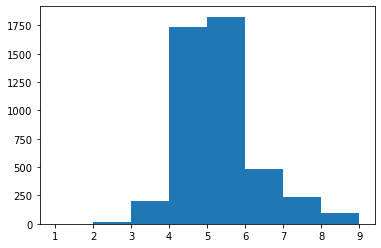

In [13]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [14]:
iters = simulate_robust(G, W, 5, range(N), 0.8, False, False, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 4    acc: 4.769230769230769                     
Result 13: 4    acc: 4.714285714285714                     
Result 14: 4    acc: 4.666666666666667                     
Result 15: 4    acc: 4.625                                 
Result 16: 4    acc: 4.588235294117647  

Result 136: 4    acc: 6.394160583941606                    
Result 137: 4    acc: 6.3768115942028984                   
Result 138: 7    acc: 6.381294964028777                    
Result 139: 7    acc: 6.385714285714286                    
Result 140: 7    acc: 6.390070921985815                    
Result 141: 7    acc: 6.394366197183099                    
Result 142: 6    acc: 6.391608391608392                    
Result 143: 4    acc: 6.375                                
Result 144: 6    acc: 6.372413793103449                    
Result 145: 6    acc: 6.36986301369863                     
Result 146: 6    acc: 6.36734693877551                     
Result 147: 7    acc: 6.371621621621622                    
Result 148: 7    acc: 6.375838926174497                    
Result 149: 6    acc: 6.373333333333333                    
Result 150: 7    acc: 6.377483443708609                    
Result 151: 7    acc: 6.381578947368421                    
Result 152: 7    acc: 6.38562091503268  

Result 273: 4    acc: 5.766423357664234                    
Result 274: 12    acc: 5.789090909090909                   
Result 275: 12    acc: 5.811594202898551                   
Result 276: 12    acc: 5.833935018050542                   
Result 277: 12    acc: 5.856115107913669                   
Result 278: 9    acc: 5.867383512544803                    
Result 279: 5    acc: 5.864285714285714                    
Result 280: 5    acc: 5.8612099644128115                   
Result 281: 4    acc: 5.8546099290780145                   
Result 282: 4    acc: 5.848056537102473                    
Result 283: 7    acc: 5.852112676056338                    
Result 284: 5    acc: 5.849122807017544                    
Result 285: 5    acc: 5.846153846153846                    
Result 286: 4    acc: 5.839721254355401                    
Result 287: 4    acc: 5.833333333333333                    
Result 288: 7    acc: 5.837370242214533                    
Result 289: 7    acc: 5.841379310344828 

Result 409: 10    acc: 5.760975609756097                   
Result 410: 6    acc: 5.761557177615572                    
Result 411: 6    acc: 5.762135922330097                    
Result 412: 5    acc: 5.760290556900727                    
Result 413: 7    acc: 5.763285024154589                    
Result 414: 5    acc: 5.7614457831325305                   
Result 415: 5    acc: 5.759615384615385                    
Result 416: 4    acc: 5.755395683453237                    
Result 417: 4    acc: 5.751196172248804                    
Result 418: 6    acc: 5.751789976133652                    
Result 419: 5    acc: 5.75                                 
Result 420: 5    acc: 5.748218527315914                    
Result 421: 5    acc: 5.746445497630332                    
Result 422: 4    acc: 5.742316784869977                    
Result 423: 4    acc: 5.738207547169812                    
Result 424: 7    acc: 5.741176470588235                    
Result 425: 5    acc: 5.73943661971831  

Result 545: 3    acc: 5.615384615384615                    
Result 546: 10    acc: 5.6234003656307125                  
Result 547: 3    acc: 5.618613138686132                    
Result 548: 4    acc: 5.6156648451730415                   
Result 549: 5    acc: 5.614545454545454                    
Result 550: 4    acc: 5.611615245009075                    
Result 551: 4    acc: 5.608695652173913                    
Result 552: 4    acc: 5.605786618444847                    
Result 553: 4    acc: 5.602888086642599                    
Result 554: 4    acc: 5.6                                  
Result 555: 4    acc: 5.597122302158273                    
Result 556: 4    acc: 5.594254937163376                    
Result 557: 4    acc: 5.591397849462366                    
Result 558: 4    acc: 5.588550983899821                    
Result 559: 4    acc: 5.585714285714285                    
Result 560: 4    acc: 5.5828877005347595                   
Result 561: 4    acc: 5.580071174377224 

Result 681: 4    acc: 5.397360703812317                    
Result 682: 4    acc: 5.3953147877013174                   
Result 683: 4    acc: 5.393274853801169                    
Result 684: 3    acc: 5.38978102189781                     
Result 685: 4    acc: 5.387755102040816                    
Result 686: 4    acc: 5.385735080058224                    
Result 687: 5    acc: 5.3851744186046515                   
Result 688: 4    acc: 5.383164005805515                    
Result 689: 5    acc: 5.3826086956521735                   
Result 690: 5    acc: 5.38205499276411                     
Result 691: 5    acc: 5.381502890173411                    
Result 692: 5    acc: 5.380952380952381                    
Result 693: 5    acc: 5.380403458213256                    
Result 694: 5    acc: 5.379856115107914                    
Result 695: 5    acc: 5.379310344827586                    
Result 696: 4    acc: 5.377331420373027                    
Result 697: 5    acc: 5.376790830945558 

Result 817: 5    acc: 5.310513447432763                    
Result 818: 5    acc: 5.31013431013431                     
Result 819: 5    acc: 5.309756097560975                    
Result 820: 5    acc: 5.309378806333739                    
Result 821: 5    acc: 5.309002433090025                    
Result 822: 9    acc: 5.313487241798299                    
Result 823: 3    acc: 5.310679611650485                    
Result 824: 3    acc: 5.307878787878788                    
Result 825: 5    acc: 5.3075060532687655                   
Result 826: 4    acc: 5.305925030229746                    
Result 827: 5    acc: 5.305555555555555                    
Result 828: 5    acc: 5.30518697225573                     
Result 829: 7    acc: 5.307228915662651                    
Result 830: 4    acc: 5.3056558363417565                   
Result 831: 4    acc: 5.304086538461538                    
Result 832: 4    acc: 5.302521008403361                    
Result 833: 4    acc: 5.300959232613909 

Result 953: 4    acc: 5.29769392033543                     
Result 954: 4    acc: 5.296335078534032                    
Result 955: 4    acc: 5.294979079497908                    
Result 956: 4    acc: 5.2936259143155695                   
Result 957: 4    acc: 5.292275574112735                    
Result 958: 4    acc: 5.290928050052138                    
Result 959: 4    acc: 5.289583333333334                    
Result 960: 4    acc: 5.288241415192508                    
Result 961: 5    acc: 5.287941787941788                    
Result 962: 4    acc: 5.286604361370716                    
Result 963: 4    acc: 5.285269709543568                    
Result 964: 5    acc: 5.284974093264249                    
Result 965: 5    acc: 5.284679089026915                    
Result 966: 5    acc: 5.284384694932782                    
Result 967: 5    acc: 5.284090909090909                    
Result 968: 5    acc: 5.283797729618163                    
Result 969: 6    acc: 5.284536082474227 

Result 1089: 5    acc: 5.26605504587156                    
Result 1090: 5    acc: 5.265811182401467                   
Result 1091: 5    acc: 5.2655677655677655                  
Result 1092: 5    acc: 5.265324794144556                   
Result 1093: 5    acc: 5.2650822669104205                  
Result 1094: 5    acc: 5.264840182648402                   
Result 1095: 4    acc: 5.263686131386861                   
Result 1096: 4    acc: 5.26253418413856                    
Result 1097: 4    acc: 5.261384335154827                   
Result 1098: 4    acc: 5.260236578707916                   
Result 1099: 4    acc: 5.259090909090909                   
Result 1100: 4    acc: 5.25794732061762                    
Result 1101: 12    acc: 5.264065335753176                  
Result 1102: 8    acc: 5.266545784224841                   
Result 1103: 3    acc: 5.2644927536231885                  
Result 1104: 10    acc: 5.268778280542986                  
Result 1105: 4    acc: 5.267631103074141

Result 1225: 5    acc: 5.212887438825448                   
Result 1226: 5    acc: 5.212713936430318                   
Result 1227: 5    acc: 5.212540716612378                   
Result 1228: 5    acc: 5.212367778681855                   
Result 1229: 3    acc: 5.210569105691057                   
Result 1230: 4    acc: 5.209585702680747                   
Result 1231: 4    acc: 5.208603896103896                   
Result 1232: 4    acc: 5.207623682076237                   
Result 1233: 4    acc: 5.206645056726094                   
Result 1234: 4    acc: 5.205668016194332                   
Result 1235: 4    acc: 5.2046925566343045                  
Result 1236: 4    acc: 5.203718674211803                   
Result 1237: 4    acc: 5.202746365105008                   
Result 1238: 4    acc: 5.201775625504439                   
Result 1239: 4    acc: 5.200806451612904                   
Result 1240: 4    acc: 5.199838839645447                   
Result 1241: 5    acc: 5.199677938808374

Result 1361: 5    acc: 5.12848751835536                    
Result 1362: 5    acc: 5.128393250183419                   
Result 1363: 4    acc: 5.127565982404692                   
Result 1364: 4    acc: 5.126739926739927                   
Result 1365: 4    acc: 5.125915080527086                   
Result 1366: 4    acc: 5.125091441111924                   
Result 1367: 4    acc: 5.124269005847953                   
Result 1368: 4    acc: 5.123447772096421                   
Result 1369: 4    acc: 5.122627737226277                   
Result 1370: 4    acc: 5.12180889861415                    
Result 1371: 4    acc: 5.1209912536443145                  
Result 1372: 4    acc: 5.120174799708667                   
Result 1373: 4    acc: 5.119359534206696                   
Result 1374: 4    acc: 5.118545454545455                   
Result 1375: 4    acc: 5.117732558139535                   
Result 1376: 4    acc: 5.116920842411038                   
Result 1377: 4    acc: 5.11611030478955 

Result 1499: 4    acc: 5.0873333333333335                  
Result 1500: 4    acc: 5.086608927381746                   
Result 1501: 4    acc: 5.0858854860186415                  
Result 1502: 4    acc: 5.0851630073186955                  
Result 1503: 4    acc: 5.084441489361702                   
Result 1504: 4    acc: 5.083720930232558                   
Result 1505: 5    acc: 5.083665338645418                   
Result 1506: 5    acc: 5.083609820836098                   
Result 1507: 5    acc: 5.083554376657825                   
Result 1508: 5    acc: 5.083499005964215                   
Result 1509: 5    acc: 5.083443708609272                   
Result 1510: 5    acc: 5.083388484447386                   
Result 1511: 3    acc: 5.082010582010582                   
Result 1512: 4    acc: 5.0812954395241245                  
Result 1513: 4    acc: 5.080581241743725                   
Result 1514: 4    acc: 5.07986798679868                    
Result 1515: 4    acc: 5.079155672823219

Result 1635: 4    acc: 5.069682151589242                   
Result 1636: 4    acc: 5.069028711056811                   
Result 1637: 3    acc: 5.0677655677655675                  
Result 1638: 3    acc: 5.066503965832825                   
Result 1639: 4    acc: 5.065853658536585                   
Result 1640: 5    acc: 5.06581352833638                    
Result 1641: 3    acc: 5.064555420219245                   
Result 1642: 3    acc: 5.063298843578819                   
Result 1643: 7    acc: 5.064476885644769                   
Result 1644: 7    acc: 5.0656534954407295                  
Result 1645: 7    acc: 5.066828675577157                   
Result 1646: 5    acc: 5.0667880995749845                  
Result 1647: 4    acc: 5.066140776699029                   
Result 1648: 4    acc: 5.065494238932686                   
Result 1649: 3    acc: 5.064242424242424                   
Result 1650: 5    acc: 5.06420351302241                    
Result 1651: 5    acc: 5.064164648910411

Result 1771: 4    acc: 5.040067720090294                   
Result 1772: 4    acc: 5.039481105470953                   
Result 1773: 4    acc: 5.038895152198422                   
Result 1774: 4    acc: 5.038309859154929                   
Result 1775: 4    acc: 5.037725225225225                   
Result 1776: 4    acc: 5.0371412492965675                  
Result 1777: 4    acc: 5.036557930258717                   
Result 1778: 4    acc: 5.035975267003935                   
Result 1779: 4    acc: 5.035393258426966                   
Result 1780: 4    acc: 5.034811903425042                   
Result 1781: 4    acc: 5.034231200897867                   
Result 1782: 5    acc: 5.03421200224341                    
Result 1783: 5    acc: 5.0341928251121075                  
Result 1784: 5    acc: 5.034173669467787                   
Result 1785: 5    acc: 5.034154535274356                   
Result 1786: 5    acc: 5.034135422495803                   
Result 1787: 5    acc: 5.034116331096197

Result 1908: 5    acc: 5.013619696176009                   
Result 1909: 5    acc: 5.013612565445026                   
Result 1910: 5    acc: 5.01360544217687                    
Result 1911: 5    acc: 5.0135983263598325                  
Result 1912: 5    acc: 5.013591217982227                   
Result 1913: 5    acc: 5.0135841170323925                  
Result 1914: 5    acc: 5.013577023498694                   
Result 1915: 5    acc: 5.01356993736952                    
Result 1916: 5    acc: 5.013562858633281                   
Result 1917: 5    acc: 5.013555787278415                   
Result 1918: 5    acc: 5.013548723293382                   
Result 1919: 5    acc: 5.013541666666667                   
Result 1920: 5    acc: 5.013534617386778                   
Result 1921: 5    acc: 5.0135275754422475                  
Result 1922: 5    acc: 5.013520540821633                   
Result 1923: 5    acc: 5.013513513513513                   
Result 1924: 5    acc: 5.013506493506494

Result 2044: 4    acc: 5.007823960880196                   
Result 2045: 5    acc: 5.007820136852395                   
Result 2046: 5    acc: 5.007816316560821                   
Result 2047: 5    acc: 5.0078125                           
Result 2048: 5    acc: 5.00780868716447                    
Result 2049: 5    acc: 5.0078048780487805                  
Result 2050: 5    acc: 5.007801072647489                   
Result 2051: 4    acc: 5.007309941520468                   
Result 2052: 4    acc: 5.006819288845592                   
Result 2053: 5    acc: 5.006815968841285                   
Result 2054: 7    acc: 5.0077858880778585                  
Result 2055: 15    acc: 5.012645914396887                  
Result 2056: 3    acc: 5.011667476908118                   
Result 2057: 4    acc: 5.011175898931001                   
Result 2058: 4    acc: 5.010684798445848                   
Result 2059: 4    acc: 5.010194174757282                   
Result 2060: 4    acc: 5.009704027171276

Result 2180: 5    acc: 5.003668042182485                   
Result 2181: 5    acc: 5.003666361136572                   
Result 2182: 5    acc: 5.0036646816307835                  
Result 2183: 5    acc: 5.003663003663004                   
Result 2184: 5    acc: 5.0036613272311214                  
Result 2185: 4    acc: 5.0032021957914                     
Result 2186: 4    acc: 5.002743484224966                   
Result 2187: 6    acc: 5.003199268738574                   
Result 2188: 6    acc: 5.003654636820466                   
Result 2189: 5    acc: 5.00365296803653                    
Result 2190: 5    acc: 5.003651300775902                   
Result 2191: 5    acc: 5.0036496350364965                  
Result 2192: 5    acc: 5.003647970816234                   
Result 2193: 5    acc: 5.003646308113035                   
Result 2194: 5    acc: 5.003644646924829                   
Result 2195: 5    acc: 5.0036429872495445                  
Result 2196: 5    acc: 5.003641329085116

Result 2319: 4    acc: 4.981034482758621                   
Result 2320: 4    acc: 4.980611805256355                   
Result 2321: 5    acc: 4.98062015503876                    
Result 2322: 5    acc: 4.980628497632372                   
Result 2323: 5    acc: 4.980636833046471                   
Result 2324: 5    acc: 4.980645161290322                   
Result 2325: 5    acc: 4.980653482373173                   
Result 2326: 5    acc: 4.980661796304254                   
Result 2327: 5    acc: 4.980670103092783                   
Result 2328: 5    acc: 4.9806784027479605                  
Result 2329: 5    acc: 4.98068669527897                    
Result 2330: 5    acc: 4.980694980694981                   
Result 2331: 5    acc: 4.980703259005145                   
Result 2332: 5    acc: 4.980711530218603                   
Result 2333: 4    acc: 4.980291345329905                   
Result 2334: 5    acc: 4.9802997858672375                  
Result 2335: 5    acc: 4.980308219178082

Result 2455: 10    acc: 5.020358306188925                  
Result 2456: 7    acc: 5.021164021164021                   
Result 2457: 7    acc: 5.021969080553295                   
Result 2458: 4    acc: 5.02155347702318                    
Result 2459: 4    acc: 5.021138211382114                   
Result 2460: 4    acc: 5.020723283218204                   
Result 2461: 4    acc: 5.020308692120228                   
Result 2462: 4    acc: 5.019894437677629                   
Result 2463: 7    acc: 5.0206980519480515                  
Result 2464: 4    acc: 5.020283975659229                   
Result 2465: 4    acc: 5.019870235198702                   
Result 2466: 4    acc: 5.019456830158087                   
Result 2467: 4    acc: 5.01904376012966                    
Result 2468: 4    acc: 5.018631024706359                   
Result 2469: 4    acc: 5.018218623481781                   
Result 2470: 4    acc: 5.017806556050182                   
Result 2471: 4    acc: 5.017394822006472

Result 2593: 5    acc: 5.023130300693909                   
Result 2594: 5    acc: 5.023121387283237                   
Result 2595: 5    acc: 5.0231124807395995                  
Result 2596: 4    acc: 5.0227185213708125                  
Result 2597: 4    acc: 5.022324865280986                   
Result 2598: 4    acc: 5.021931512120046                   
Result 2599: 5    acc: 5.021923076923077                   
Result 2600: 5    acc: 5.021914648212226                   
Result 2601: 5    acc: 5.021906225980016                   
Result 2602: 6    acc: 5.022281982328083                   
Result 2603: 6    acc: 5.022657450076805                   
Result 2604: 3    acc: 5.021880998080614                   
Result 2605: 4    acc: 5.0214888718342285                  
Result 2606: 8    acc: 5.0226313770617566                  
Result 2607: 8    acc: 5.023773006134969                   
Result 2608: 8    acc: 5.0249137600613265                  
Result 2609: 4    acc: 5.024521072796935

Result 2730: 4    acc: 5.020505309410472                   
Result 2731: 3    acc: 5.019765739385066                   
Result 2732: 4    acc: 5.019392608854738                   
Result 2733: 4    acc: 5.019019751280176                   
Result 2734: 4    acc: 5.0186471663619745                  
Result 2735: 4    acc: 5.018274853801169                   
Result 2736: 4    acc: 5.017902813299233                   
Result 2737: 4    acc: 5.017531044558072                   
Result 2738: 4    acc: 5.017159547280029                   
Result 2739: 4    acc: 5.016788321167883                   
Result 2740: 4    acc: 5.016417365924845                   
Result 2741: 5    acc: 5.016411378555799                   
Result 2742: 5    acc: 5.016405395552315                   
Result 2743: 5    acc: 5.016399416909621                   
Result 2744: 8    acc: 5.017486338797815                   
Result 2745: 3    acc: 5.016751638747269                   
Result 2746: 4    acc: 5.016381507098653

Result 2866: 8    acc: 5.05859783746076                    
Result 2867: 8    acc: 5.059623430962343                   
Result 2868: 4    acc: 5.05925409550366                    
Result 2869: 4    acc: 5.058885017421603                   
Result 2870: 4    acc: 5.058516196447231                   
Result 2871: 3    acc: 5.057799442896936                   
Result 2872: 3    acc: 5.057083188304908                   
Result 2873: 3    acc: 5.056367432150314                   
Result 2874: 3    acc: 5.055652173913043                   
Result 2875: 4    acc: 5.05528511821975                    
Result 2876: 4    acc: 5.0549183176920405                  
Result 2877: 4    acc: 5.054551772063934                   
Result 2878: 4    acc: 5.0541854810698155                  
Result 2879: 8    acc: 5.055208333333334                   
Result 2880: 8    acc: 5.05623047552933                    
Result 2881: 8    acc: 5.057251908396947                   
Result 2882: 8    acc: 5.058272632674297

Result 3002: 4    acc: 5.054279054279054                   
Result 3003: 4    acc: 5.053928095872171                   
Result 3004: 4    acc: 5.053577371048253                   
Result 3005: 4    acc: 5.053226879574185                   
Result 3006: 5    acc: 5.053209178583305                   
Result 3007: 5    acc: 5.053191489361702                   
Result 3008: 5    acc: 5.053173811897641                   
Result 3009: 5    acc: 5.053156146179402                   
Result 3010: 5    acc: 5.053138492195284                   
Result 3011: 5    acc: 5.053120849933599                   
Result 3012: 4    acc: 5.052771324261533                   
Result 3013: 4    acc: 5.0524220305242205                  
Result 3014: 4    acc: 5.0520729684908785                  
Result 3015: 5    acc: 5.052055702917772                   
Result 3016: 5    acc: 5.052038448790189                   
Result 3017: 5    acc: 5.052021206096753                   
Result 3018: 5    acc: 5.052003974826102

Result 3139: 10    acc: 5.136624203821656                  
Result 3140: 18    acc: 5.140719516077683                  
Result 3141: 18    acc: 5.144812221514958                  
Result 3142: 6    acc: 5.145084314349348                   
Result 3143: 6    acc: 5.145356234096692                   
Result 3144: 16    acc: 5.148807631160572                  
Result 3145: 16    acc: 5.152256834075016                  
Result 3146: 16    acc: 5.155703844931681                  
Result 3147: 16    acc: 5.1591486658195675                 
Result 3148: 16    acc: 5.162591298825024                  
Result 3149: 10    acc: 5.164126984126984                  
Result 3150: 16    acc: 5.1675658521104415                 
Result 3151: 12    acc: 5.169733502538071                  
Result 3152: 12    acc: 5.171899777989217                  
Result 3153: 12    acc: 5.1740646797717185                 
Result 3154: 5    acc: 5.174009508716323                   
Result 3155: 10    acc: 5.17553865652725

Result 3277: 4    acc: 5.1989017693715684                  
Result 3278: 4    acc: 5.198536139066789                   
Result 3279: 5    acc: 5.198475609756097                   
Result 3280: 4    acc: 5.198110332215788                   
Result 3281: 4    acc: 5.1977452772699575                  
Result 3282: 4    acc: 5.1973804447152                     
Result 3283: 6    acc: 5.19762484774665                    
Result 3284: 7    acc: 5.198173515981735                   
Result 3285: 7    acc: 5.1987218502738894                  
Result 3286: 7    acc: 5.199269850927898                   
Result 3287: 6    acc: 5.199513381995134                   
Result 3288: 7    acc: 5.200060808756461                   
Result 3289: 4    acc: 5.199696048632219                   
Result 3290: 5    acc: 5.199635369188696                   
Result 3291: 4    acc: 5.199270959902795                   
Result 3292: 7    acc: 5.199817795323414                   
Result 3293: 4    acc: 5.199453551912568

Result 3414: 8    acc: 5.2714494875549045                  
Result 3415: 4    acc: 5.271077283372366                   
Result 3416: 5    acc: 5.270997951419374                   
Result 3417: 5    acc: 5.270918665886484                   
Result 3418: 5    acc: 5.270839426732963                   
Result 3419: 4    acc: 5.27046783625731                    
Result 3420: 5    acc: 5.270388775211926                   
Result 3421: 5    acc: 5.27030976037405                    
Result 3422: 5    acc: 5.2702307917031845                  
Result 3423: 5    acc: 5.2701518691588785                  
Result 3424: 5    acc: 5.2700729927007295                  
Result 3425: 4    acc: 5.26970227670753                    
Result 3426: 5    acc: 5.269623577473008                   
Result 3427: 5    acc: 5.269544924154026                   
Result 3428: 5    acc: 5.269466316710411                   
Result 3429: 4    acc: 5.2690962099125365                  
Result 3430: 4    acc: 5.268726318857475

Result 3552: 4    acc: 5.269912749788911                   
Result 3553: 4    acc: 5.269555430500844                   
Result 3554: 4    acc: 5.269198312236287                   
Result 3555: 4    acc: 5.268841394825647                   
Result 3556: 4    acc: 5.268484678099522                   
Result 3557: 4    acc: 5.2681281618887015                  
Result 3558: 4    acc: 5.267771846024164                   
Result 3559: 4    acc: 5.2674157303370785                  
Result 3560: 4    acc: 5.267059814658804                   
Result 3561: 4    acc: 5.266704098820887                   
Result 3562: 4    acc: 5.266348582655066                   
Result 3563: 8    acc: 5.267115600448934                   
Result 3564: 8    acc: 5.267882187938289                   
Result 3565: 8    acc: 5.268648345485137                   
Result 3566: 11    acc: 5.270255116344267                  
Result 3567: 12    acc: 5.272141255605381                  
Result 3568: 11    acc: 5.27374614738021

Result 3688: 5    acc: 5.304689617782597                   
Result 3689: 5    acc: 5.304607046070461                   
Result 3690: 5    acc: 5.304524519100514                   
Result 3691: 5    acc: 5.304442036836403                   
Result 3692: 5    acc: 5.304359599241809                   
Result 3693: 5    acc: 5.304277206280455                   
Result 3694: 5    acc: 5.3041948579161025                  
Result 3695: 5    acc: 5.304112554112554                   
Result 3696: 4    acc: 5.303759805247498                   
Result 3697: 4    acc: 5.303407247160627                   
Result 3698: 4    acc: 5.303054879697216                   
Result 3699: 3    acc: 5.302432432432433                   
Result 3700: 3    acc: 5.30181032153472                    
Result 3701: 3    acc: 5.301188546731496                   
Result 3702: 5    acc: 5.30110721036997                    
Result 3703: 5    acc: 5.301025917926566                   
Result 3704: 4    acc: 5.300674763832658

Result 3826: 4    acc: 5.298144760909328                   
Result 3827: 4    acc: 5.297805642633229                   
Result 3828: 4    acc: 5.29746670148864                    
Result 3829: 4    acc: 5.297127937336815                   
Result 3830: 4    acc: 5.2967893500391545                  
Result 3831: 4    acc: 5.296450939457203                   
Result 3832: 4    acc: 5.296112705452648                   
Result 3833: 4    acc: 5.295774647887324                   
Result 3834: 4    acc: 5.295436766623207                   
Result 3835: 5    acc: 5.295359749739312                   
Result 3836: 5    acc: 5.295282772999739                   
Result 3837: 5    acc: 5.295205836373111                   
Result 3838: 5    acc: 5.29512893982808                    
Result 3839: 5    acc: 5.295052083333333                   
Result 3840: 5    acc: 5.294975266857589                   
Result 3841: 5    acc: 5.294898490369599                   
Result 3842: 4    acc: 5.29456154046318 

Result 3963: 4    acc: 5.3196266397578205                  
Result 3964: 4    acc: 5.319293820933165                   
Result 3965: 4    acc: 5.3189611699445285                  
Result 3966: 4    acc: 5.318628686664987                   
Result 3967: 4    acc: 5.318296370967742                   
Result 3968: 4    acc: 5.317964222726127                   
Result 3969: 4    acc: 5.317632241813602                   
Result 3970: 4    acc: 5.317300428103752                   
Result 3971: 8    acc: 5.31797583081571                    
Result 3972: 8    acc: 5.318650893531337                   
Result 3973: 8    acc: 5.319325616507298                   
Result 3974: 8    acc: 5.32                                
Result 3975: 8    acc: 5.320674044265593                   
Result 3976: 8    acc: 5.32134774955997                    
Result 3977: 5    acc: 5.321266968325792                   
Result 3978: 5    acc: 5.321186227695401                   
Result 3979: 3    acc: 5.320603015075377

Result 4101: 4    acc: 5.290346172598732                   
Result 4102: 3    acc: 5.289787960029247                   
Result 4103: 3    acc: 5.289230019493178                   
Result 4104: 4    acc: 5.288915956151035                   
Result 4105: 4    acc: 5.288602045786654                   
Result 4106: 4    acc: 5.288288288288288                   
Result 4107: 4    acc: 5.287974683544304                   
Result 4108: 5    acc: 5.287904599659284                   
Result 4109: 4    acc: 5.287591240875912                   
Result 4110: 5    acc: 5.287521284359037                   
Result 4111: 7    acc: 5.287937743190661                   
Result 4112: 7    acc: 5.2883539995137365                  
Result 4113: 7    acc: 5.288770053475936                   
Result 4114: 6    acc: 5.288942891859052                   
Result 4115: 7    acc: 5.289358600583091                   
Result 4116: 4    acc: 5.289045421423366                   
Result 4117: 4    acc: 5.288732394366197

Result 4239: 5    acc: 5.273349056603774                   
Result 4240: 5    acc: 5.2732846026880456                  
Result 4241: 12    acc: 5.274870344177275                  
Result 4242: 4    acc: 5.274569879802027                   
Result 4243: 12    acc: 5.276154571159283                  
Result 4244: 12    acc: 5.27773851590106                   
Result 4245: 13    acc: 5.279557230334432                  
Result 4246: 7    acc: 5.27996232634801                    
Result 4247: 13    acc: 5.281779661016949                  
Result 4248: 13    acc: 5.2835961402682985                 
Result 4249: 11    acc: 5.284941176470588                  
Result 4250: 16    acc: 5.287461773700306                  
Result 4251: 4    acc: 5.287158984007526                   
Result 4252: 5    acc: 5.287091464848342                   
Result 4253: 5    acc: 5.287023977433004                   
Result 4254: 6    acc: 5.287191539365453                   
Result 4255: 5    acc: 5.287124060150376

Result 4375: 4    acc: 5.307129798903108                   
Result 4376: 4    acc: 5.3068311628969616                  
Result 4377: 4    acc: 5.306532663316583                   
Result 4378: 4    acc: 5.306234300068509                   
Result 4379: 4    acc: 5.30593607305936                    
Result 4380: 4    acc: 5.3056379821958455                  
Result 4381: 4    acc: 5.305340027384756                   
Result 4382: 3    acc: 5.304814054300707                   
Result 4383: 4    acc: 5.304516423357664                   
Result 4384: 6    acc: 5.304675028506272                   
Result 4385: 6    acc: 5.30483356133151                    
Result 4386: 6    acc: 5.3049920218828355                  
Result 4387: 6    acc: 5.305150410209663                   
Result 4388: 6    acc: 5.305308726361358                   
Result 4389: 5    acc: 5.305239179954442                   
Result 4390: 5    acc: 5.305169665224322                   
Result 4391: 5    acc: 5.305100182149363

Result 4511: 6    acc: 5.295212765957447                   
Result 4512: 7    acc: 5.295590516286284                   
Result 4513: 6    acc: 5.295746566238369                   
Result 4514: 6    acc: 5.295902547065338                   
Result 4515: 6    acc: 5.296058458813109                   
Result 4516: 7    acc: 5.296435687403144                   
Result 4517: 7    acc: 5.296812749003984                   
Result 4518: 7    acc: 5.2971896437264885                  
Result 4519: 7    acc: 5.297566371681416                   
Result 4520: 7    acc: 5.29794293297943                    
Result 4521: 7    acc: 5.298319327731092                   
Result 4522: 7    acc: 5.298695556046871                   
Result 4523: 7    acc: 5.299071618037135                   
Result 4524: 7    acc: 5.299447513812154                   
Result 4525: 7    acc: 5.299823243482104                   
Result 4526: 7    acc: 5.300198807157058                   
Result 4527: 7    acc: 5.300574204946996

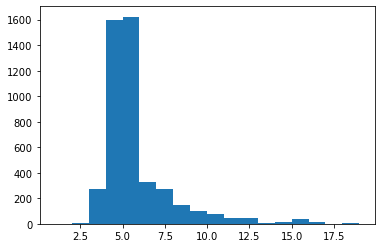

In [15]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [16]:
iters = simulate_robust(G, W, 5, range(N), 0, False, True, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 4    acc: 4.75                                  
Result 12: 4    acc: 4.6923076923076925                    
Result 13: 4    acc: 4.642857142857143                     
Result 14: 6    acc: 4.733333333333333                     
Result 15: 6    acc: 4.8125                                
Result 16: 5    acc: 4.823529411764706  

Result 136: 5    acc: 5.299270072992701                    
Result 137: 5    acc: 5.297101449275362                    
Result 138: 6    acc: 5.302158273381295                    
Result 139: 5    acc: 5.3                                  
Result 140: 5    acc: 5.297872340425532                    
Result 141: 5    acc: 5.295774647887324                    
Result 142: 5    acc: 5.293706293706293                    
Result 143: 5    acc: 5.291666666666667                    
Result 144: 5    acc: 5.289655172413793                    
Result 145: 5    acc: 5.287671232876712                    
Result 146: 5    acc: 5.285714285714286                    
Result 147: 5    acc: 5.283783783783784                    
Result 148: 5    acc: 5.281879194630872                    
Result 149: 5    acc: 5.28                                 
Result 150: 5    acc: 5.2781456953642385                   
Result 151: 5    acc: 5.276315789473684                    
Result 152: 6    acc: 5.281045751633987 

Result 273: 5    acc: 5.083941605839416                    
Result 274: 5    acc: 5.083636363636364                    
Result 275: 5    acc: 5.083333333333333                    
Result 276: 5    acc: 5.0830324909747295                   
Result 277: 4    acc: 5.079136690647482                    
Result 278: 5    acc: 5.078853046594982                    
Result 279: 5    acc: 5.078571428571428                    
Result 280: 5    acc: 5.07829181494662                     
Result 281: 5    acc: 5.078014184397163                    
Result 282: 4    acc: 5.074204946996466                    
Result 283: 5    acc: 5.073943661971831                    
Result 284: 5    acc: 5.073684210526316                    
Result 285: 5    acc: 5.073426573426573                    
Result 286: 6    acc: 5.076655052264808                    
Result 287: 6    acc: 5.079861111111111                    
Result 288: 5    acc: 5.079584775086505                    
Result 289: 5    acc: 5.0793103448275865

Result 410: 3    acc: 5.0535279805352795                   
Result 411: 3    acc: 5.048543689320389                    
Result 412: 7    acc: 5.053268765133172                    
Result 413: 5    acc: 5.053140096618358                    
Result 414: 5    acc: 5.053012048192771                    
Result 415: 7    acc: 5.0576923076923075                   
Result 416: 3    acc: 5.052757793764988                    
Result 417: 7    acc: 5.057416267942584                    
Result 418: 6    acc: 5.059665871121719                    
Result 419: 5    acc: 5.059523809523809                    
Result 420: 5    acc: 5.059382422802851                    
Result 421: 5    acc: 5.059241706161138                    
Result 422: 4    acc: 5.056737588652482                    
Result 423: 5    acc: 5.056603773584905                    
Result 424: 5    acc: 5.056470588235294                    
Result 425: 5    acc: 5.056338028169014                    
Result 426: 4    acc: 5.053864168618267 

Result 548: 5    acc: 4.967213114754099                    
Result 549: 5    acc: 4.967272727272727                    
Result 550: 5    acc: 4.967332123411978                    
Result 551: 5    acc: 4.967391304347826                    
Result 552: 5    acc: 4.967450271247739                    
Result 553: 5    acc: 4.9675090252707585                   
Result 554: 5    acc: 4.967567567567568                    
Result 555: 5    acc: 4.967625899280575                    
Result 556: 5    acc: 4.9676840215439855                   
Result 557: 5    acc: 4.967741935483871                    
Result 558: 5    acc: 4.967799642218247                    
Result 559: 5    acc: 4.9678571428571425                   
Result 560: 5    acc: 4.967914438502674                    
Result 561: 5    acc: 4.967971530249111                    
Result 562: 5    acc: 4.968028419182948                    
Result 563: 4    acc: 4.966312056737588                    
Result 564: 5    acc: 4.9663716814159296

Result 686: 4    acc: 4.967976710334789                    
Result 687: 5    acc: 4.968023255813954                    
Result 688: 4    acc: 4.966618287373004                    
Result 689: 5    acc: 4.966666666666667                    
Result 690: 5    acc: 4.96671490593343                     
Result 691: 5    acc: 4.966763005780347                    
Result 692: 5    acc: 4.966810966810967                    
Result 693: 5    acc: 4.96685878962536                     
Result 694: 5    acc: 4.966906474820144                    
Result 695: 5    acc: 4.966954022988506                    
Result 696: 4    acc: 4.9655667144906745                   
Result 697: 5    acc: 4.965616045845272                    
Result 698: 5    acc: 4.965665236051502                    
Result 699: 4    acc: 4.964285714285714                    
Result 700: 4    acc: 4.9629101283880175                   
Result 701: 4    acc: 4.961538461538462                    
Result 702: 4    acc: 4.960170697012802 

Result 822: 5    acc: 4.92588092345079                     
Result 823: 3    acc: 4.923543689320389                    
Result 824: 3    acc: 4.921212121212121                    
Result 825: 5    acc: 4.921307506053269                    
Result 826: 5    acc: 4.921402660217654                    
Result 827: 5    acc: 4.921497584541063                    
Result 828: 5    acc: 4.921592279855247                    
Result 829: 5    acc: 4.921686746987952                    
Result 830: 4    acc: 4.92057761732852                     
Result 831: 4    acc: 4.919471153846154                    
Result 832: 4    acc: 4.918367346938775                    
Result 833: 4    acc: 4.91726618705036                     
Result 834: 5    acc: 4.917365269461078                    
Result 835: 5    acc: 4.917464114832536                    
Result 836: 5    acc: 4.917562724014337                    
Result 837: 5    acc: 4.9176610978520285                   
Result 838: 5    acc: 4.917759237187128 

Result 958: 6    acc: 4.908237747653806                    
Result 959: 6    acc: 4.909375                             
Result 960: 4    acc: 4.908428720083247                    
Result 961: 5    acc: 4.908523908523908                    
Result 962: 4    acc: 4.907580477673935                    
Result 963: 4    acc: 4.906639004149378                    
Result 964: 5    acc: 4.9067357512953365                   
Result 965: 5    acc: 4.906832298136646                    
Result 966: 5    acc: 4.906928645294726                    
Result 967: 5    acc: 4.9070247933884295                   
Result 968: 5    acc: 4.9071207430340555                   
Result 969: 5    acc: 4.907216494845361                    
Result 970: 5    acc: 4.907312049433574                    
Result 971: 4    acc: 4.906378600823046                    
Result 972: 5    acc: 4.906474820143885                    
Result 973: 5    acc: 4.906570841889117                    
Result 974: 5    acc: 4.906666666666666 

Result 1094: 5    acc: 4.920547945205479                   
Result 1095: 4    acc: 4.91970802919708                    
Result 1096: 4    acc: 4.918869644484959                   
Result 1097: 4    acc: 4.918032786885246                   
Result 1098: 4    acc: 4.917197452229299                   
Result 1099: 4    acc: 4.916363636363636                   
Result 1100: 5    acc: 4.916439600363306                   
Result 1101: 5    acc: 4.916515426497278                   
Result 1102: 4    acc: 4.915684496826836                   
Result 1103: 7    acc: 4.917572463768116                   
Result 1104: 5    acc: 4.91764705882353                    
Result 1105: 5    acc: 4.917721518987341                   
Result 1106: 4    acc: 4.916892502258356                   
Result 1107: 6    acc: 4.917870036101083                   
Result 1108: 6    acc: 4.918845807033364                   
Result 1109: 5    acc: 4.918918918918919                   
Result 1110: 5    acc: 4.918991899189919

Result 1230: 6    acc: 4.930138099106418                   
Result 1231: 6    acc: 4.9310064935064934                  
Result 1232: 6    acc: 4.931873479318734                   
Result 1233: 6    acc: 4.932739059967585                   
Result 1234: 6    acc: 4.933603238866397                   
Result 1235: 6    acc: 4.934466019417476                   
Result 1236: 6    acc: 4.935327405012126                   
Result 1237: 6    acc: 4.936187399030695                   
Result 1238: 6    acc: 4.937046004842615                   
Result 1239: 5    acc: 4.937096774193549                   
Result 1240: 6    acc: 4.93795326349718                    
Result 1241: 5    acc: 4.938003220611916                   
Result 1242: 4    acc: 4.937248592115849                   
Result 1243: 4    acc: 4.936495176848875                   
Result 1244: 5    acc: 4.936546184738956                   
Result 1245: 4    acc: 4.935794542536115                   
Result 1246: 4    acc: 4.935044105854049

Result 1367: 5    acc: 4.928362573099415                   
Result 1368: 5    acc: 4.928414901387875                   
Result 1369: 5    acc: 4.9284671532846716                  
Result 1370: 5    acc: 4.928519328956965                   
Result 1371: 5    acc: 4.928571428571429                   
Result 1372: 5    acc: 4.9286234522942465                  
Result 1373: 5    acc: 4.92867540029112                    
Result 1374: 6    acc: 4.929454545454545                   
Result 1375: 6    acc: 4.930232558139535                   
Result 1376: 6    acc: 4.931009440813362                   
Result 1377: 6    acc: 4.931785195936139                   
Result 1378: 6    acc: 4.932559825960841                   
Result 1379: 6    acc: 4.933333333333334                   
Result 1380: 6    acc: 4.934105720492397                   
Result 1381: 5    acc: 4.934153400868307                   
Result 1382: 5    acc: 4.934201012292118                   
Result 1383: 5    acc: 4.934248554913295

Result 1504: 4    acc: 4.915614617940199                   
Result 1505: 4    acc: 4.915006640106242                   
Result 1506: 4    acc: 4.914399469143994                   
Result 1507: 5    acc: 4.914456233421751                   
Result 1508: 5    acc: 4.914512922465208                   
Result 1509: 5    acc: 4.914569536423841                   
Result 1510: 5    acc: 4.914626075446724                   
Result 1511: 4    acc: 4.914021164021164                   
Result 1512: 5    acc: 4.91407799074686                    
Result 1513: 5    acc: 4.914134742404228                   
Result 1514: 5    acc: 4.914191419141914                   
Result 1515: 5    acc: 4.91424802110818                    
Result 1516: 5    acc: 4.91430454845089                    
Result 1517: 5    acc: 4.914361001317523                   
Result 1518: 5    acc: 4.914417379855168                   
Result 1519: 5    acc: 4.9144736842105265                  
Result 1520: 5    acc: 4.914529914529915

Result 1640: 4    acc: 4.917123705057891                   
Result 1641: 5    acc: 4.917174177831912                   
Result 1642: 5    acc: 4.9172245891661595                  
Result 1643: 5    acc: 4.917274939172749                   
Result 1644: 5    acc: 4.917325227963526                   
Result 1645: 5    acc: 4.917375455650061                   
Result 1646: 5    acc: 4.917425622343655                   
Result 1647: 5    acc: 4.91747572815534                    
Result 1648: 5    acc: 4.917525773195877                   
Result 1649: 6    acc: 4.918181818181818                   
Result 1650: 5    acc: 4.9182313749242885                  
Result 1651: 5    acc: 4.918280871670702                   
Result 1652: 5    acc: 4.918330308529946                   
Result 1653: 5    acc: 4.918379685610641                   
Result 1654: 5    acc: 4.918429003021148                   
Result 1655: 5    acc: 4.918478260869565                   
Result 1656: 5    acc: 4.918527459263729

Result 1778: 4    acc: 4.9027543563799885                  
Result 1779: 4    acc: 4.902247191011236                   
Result 1780: 4    acc: 4.901740595171252                   
Result 1781: 4    acc: 4.901234567901234                   
Result 1782: 5    acc: 4.901289960740325                   
Result 1783: 5    acc: 4.901345291479821                   
Result 1784: 5    acc: 4.90140056022409                    
Result 1785: 5    acc: 4.901455767077268                   
Result 1786: 5    acc: 4.901510912143257                   
Result 1787: 6    acc: 4.902125279642058                   
Result 1788: 6    acc: 4.902738960313024                   
Result 1789: 5    acc: 4.902793296089386                   
Result 1790: 5    acc: 4.902847571189279                   
Result 1791: 5    acc: 4.902901785714286                   
Result 1792: 5    acc: 4.902955939765755                   
Result 1793: 5    acc: 4.903010033444816                   
Result 1794: 6    acc: 4.903621169916435

Result 1916: 4    acc: 4.896713615023474                   
Result 1917: 4    acc: 4.896246089676747                   
Result 1918: 4    acc: 4.895779051589369                   
Result 1919: 5    acc: 4.895833333333333                   
Result 1920: 5    acc: 4.895887558563248                   
Result 1921: 5    acc: 4.895941727367326                   
Result 1922: 5    acc: 4.895995839833593                   
Result 1923: 4    acc: 4.895530145530145                   
Result 1924: 4    acc: 4.895064935064935                   
Result 1925: 4    acc: 4.89460020768432                    
Result 1926: 4    acc: 4.894135962636222                   
Result 1927: 4    acc: 4.893672199170124                   
Result 1928: 4    acc: 4.893208916537066                   
Result 1929: 4    acc: 4.892746113989637                   
Result 1930: 4    acc: 4.8922837907819785                  
Result 1931: 4    acc: 4.891821946169772                   
Result 1932: 4    acc: 4.891360579410243

Result 2053: 4    acc: 4.875851996105161                   
Result 2054: 7    acc: 4.876885644768857                   
Result 2055: 6    acc: 4.877431906614786                   
Result 2056: 3    acc: 4.876519202722411                   
Result 2057: 6    acc: 4.87706511175899                    
Result 2058: 7    acc: 4.8780961631860125                  
Result 2059: 7    acc: 4.879126213592233                   
Result 2060: 4    acc: 4.878699660359049                   
Result 2061: 5    acc: 4.878758486905917                   
Result 2062: 6    acc: 4.879301987396994                   
Result 2063: 6    acc: 4.87984496124031                    
Result 2064: 6    acc: 4.880387409200969                   
Result 2065: 6    acc: 4.880929332042594                   
Result 2066: 6    acc: 4.881470730527334                   
Result 2067: 6    acc: 4.882011605415861                   
Result 2068: 6    acc: 4.882551957467376                   
Result 2069: 6    acc: 4.883091787439613

Result 2191: 6    acc: 4.869525547445256                   
Result 2192: 6    acc: 4.8700410396716824                  
Result 2193: 6    acc: 4.870556061987238                   
Result 2194: 6    acc: 4.871070615034169                   
Result 2195: 6    acc: 4.871584699453552                   
Result 2196: 6    acc: 4.872098315885298                   
Result 2197: 6    acc: 4.872611464968153                   
Result 2198: 6    acc: 4.8731241473397                     
Result 2199: 6    acc: 4.873636363636364                   
Result 2200: 6    acc: 4.874148114493412                   
Result 2201: 6    acc: 4.874659400544959                   
Result 2202: 6    acc: 4.875170222423967                   
Result 2203: 6    acc: 4.875680580762251                   
Result 2204: 6    acc: 4.876190476190477                   
Result 2205: 6    acc: 4.876699909338169                   
Result 2206: 6    acc: 4.877208880833711                   
Result 2207: 6    acc: 4.877717391304348

Result 2329: 5    acc: 4.8931330472103                     
Result 2330: 5    acc: 4.893178893178893                   
Result 2331: 5    acc: 4.893224699828473                   
Result 2332: 5    acc: 4.893270467209601                   
Result 2333: 4    acc: 4.892887746358183                   
Result 2334: 5    acc: 4.892933618843683                   
Result 2335: 5    acc: 4.892979452054795                   
Result 2336: 4    acc: 4.8925973470261015                  
Result 2337: 4    acc: 4.892215568862276                   
Result 2338: 5    acc: 4.892261650277897                   
Result 2339: 5    acc: 4.892307692307693                   
Result 2340: 5    acc: 4.892353695002136                   
Result 2341: 5    acc: 4.892399658411614                   
Result 2342: 5    acc: 4.8924455825864275                  
Result 2343: 5    acc: 4.892491467576792                   
Result 2344: 5    acc: 4.892537313432836                   
Result 2345: 5    acc: 4.892583120204604

Result 2467: 5    acc: 4.897082658022691                   
Result 2468: 5    acc: 4.8971243418388015                  
Result 2469: 5    acc: 4.897165991902834                   
Result 2470: 5    acc: 4.8972076082557665                  
Result 2471: 5    acc: 4.897249190938512                   
Result 2472: 5    acc: 4.897290739991913                   
Result 2473: 5    acc: 4.89733225545675                    
Result 2474: 5    acc: 4.897373737373737                   
Result 2475: 5    acc: 4.8974151857835215                  
Result 2476: 5    acc: 4.897456600726685                   
Result 2477: 5    acc: 4.8974979822437446                  
Result 2478: 5    acc: 4.897539330375151                   
Result 2479: 6    acc: 4.897983870967742                   
Result 2480: 5    acc: 4.898024989923418                   
Result 2481: 5    acc: 4.8980660757453665                  
Result 2482: 5    acc: 4.898107128473621                   
Result 2483: 5    acc: 4.898148148148148

Result 2605: 5    acc: 4.903683806600154                   
Result 2606: 5    acc: 4.903720751822018                   
Result 2607: 5    acc: 4.903757668711656                   
Result 2608: 5    acc: 4.903794557301648                   
Result 2609: 4    acc: 4.903448275862069                   
Result 2610: 5    acc: 4.903485254691689                   
Result 2611: 5    acc: 4.903522205206738                   
Result 2612: 5    acc: 4.903559127439724                   
Result 2613: 5    acc: 4.903596021423106                   
Result 2614: 5    acc: 4.903632887189293                   
Result 2615: 5    acc: 4.9036697247706424                  
Result 2616: 5    acc: 4.903706534199465                   
Result 2617: 5    acc: 4.903743315508021                   
Result 2618: 5    acc: 4.903780068728523                   
Result 2619: 5    acc: 4.90381679389313                    
Result 2620: 5    acc: 4.903853491033956                   
Result 2621: 5    acc: 4.903890160183066

Result 2743: 4    acc: 4.9121720116618075                  
Result 2744: 5    acc: 4.9122040072859745                  
Result 2745: 3    acc: 4.911507647487254                   
Result 2746: 6    acc: 4.911903895158354                   
Result 2747: 6    acc: 4.912299854439593                   
Result 2748: 5    acc: 4.912331757002546                   
Result 2749: 5    acc: 4.9123636363636365                  
Result 2750: 6    acc: 4.912758996728463                   
Result 2751: 5    acc: 4.912790697674419                   
Result 2752: 6    acc: 4.913185615691972                   
Result 2753: 6    acc: 4.91358024691358                    
Result 2754: 4    acc: 4.913248638838476                   
Result 2755: 6    acc: 4.913642960812772                   
Result 2756: 6    acc: 4.914036996735582                   
Result 2757: 6    acc: 4.914430746918057                   
Result 2758: 6    acc: 4.914824211670895                   
Result 2759: 6    acc: 4.915217391304348

Result 2879: 5    acc: 4.922569444444444                   
Result 2880: 5    acc: 4.922596320721971                   
Result 2881: 4    acc: 4.922276197085357                   
Result 2882: 5    acc: 4.92230315643427                    
Result 2883: 5    acc: 4.922330097087379                   
Result 2884: 4    acc: 4.922010398613518                   
Result 2885: 4    acc: 4.921690921690922                   
Result 2886: 4    acc: 4.9213716660893665                  
Result 2887: 4    acc: 4.921052631578948                   
Result 2888: 5    acc: 4.921079958463136                   
Result 2889: 5    acc: 4.921107266435986                   
Result 2890: 5    acc: 4.921134555517122                   
Result 2891: 5    acc: 4.921161825726141                   
Result 2892: 5    acc: 4.921189077082613                   
Result 2893: 5    acc: 4.9212163096060815                  
Result 2894: 5    acc: 4.921243523316062                   
Result 2895: 5    acc: 4.921270718232044

Result 3015: 5    acc: 4.894230769230769                   
Result 3016: 4    acc: 4.893934371892609                   
Result 3017: 6    acc: 4.894300861497681                   
Result 3018: 6    acc: 4.894667108314011                   
Result 3019: 6    acc: 4.895033112582781                   
Result 3020: 6    acc: 4.895398874544853                   
Result 3021: 6    acc: 4.895764394440768                   
Result 3022: 6    acc: 4.896129672510751                   
Result 3023: 6    acc: 4.896494708994709                   
Result 3024: 6    acc: 4.896859504132231                   
Result 3025: 6    acc: 4.897224058162591                   
Result 3026: 6    acc: 4.897588371324744                   
Result 3027: 6    acc: 4.897952443857331                   
Result 3028: 6    acc: 4.898316275998679                   
Result 3029: 6    acc: 4.898679867986798                   
Result 3030: 6    acc: 4.8990432200593865                  
Result 3031: 6    acc: 4.899406332453826

Result 3153: 5    acc: 4.9273937856689916                  
Result 3154: 5    acc: 4.927416798732171                   
Result 3155: 6    acc: 4.927756653992396                   
Result 3156: 4    acc: 4.927462781121318                   
Result 3157: 4    acc: 4.927169094363522                   
Result 3158: 4    acc: 4.926875593542261                   
Result 3159: 4    acc: 4.926582278481012                   
Result 3160: 4    acc: 4.9262891490034795                  
Result 3161: 4    acc: 4.925996204933586                   
Result 3162: 4    acc: 4.925703446095479                   
Result 3163: 5    acc: 4.925726927939317                   
Result 3164: 5    acc: 4.925750394944708                   
Result 3165: 5    acc: 4.92577384712571                    
Result 3166: 5    acc: 4.925797284496369                   
Result 3167: 5    acc: 4.925820707070707                   
Result 3168: 5    acc: 4.925844114862732                   
Result 3169: 5    acc: 4.925867507886435

Result 3289: 7    acc: 4.922492401215806                   
Result 3290: 5    acc: 4.922515952597995                   
Result 3291: 7    acc: 4.92314702308627                    
Result 3292: 7    acc: 4.923777710294564                   
Result 3293: 7    acc: 4.924408014571949                   
Result 3294: 6    acc: 4.9247344461305005                  
Result 3295: 6    acc: 4.925060679611651                   
Result 3296: 5    acc: 4.925083409159842                   
Result 3297: 5    acc: 4.925106124924197                   
Result 3298: 5    acc: 4.9251288269172475                  
Result 3299: 5    acc: 4.925151515151515                   
Result 3300: 5    acc: 4.925174189639503                   
Result 3301: 5    acc: 4.925196850393701                   
Result 3302: 5    acc: 4.925219497426582                   
Result 3303: 5    acc: 4.925242130750605                   
Result 3304: 5    acc: 4.925264750378215                   
Result 3305: 5    acc: 4.925287356321839

Result 3427: 4    acc: 4.95536756126021                    
Result 3428: 6    acc: 4.955672207640712                   
Result 3429: 6    acc: 4.955976676384839                   
Result 3430: 6    acc: 4.956280967647916                   
Result 3431: 6    acc: 4.956585081585081                   
Result 3432: 6    acc: 4.956889018351296                   
Result 3433: 5    acc: 4.956901572510192                   
Result 3434: 5    acc: 4.956914119359534                   
Result 3435: 4    acc: 4.956635622817229                   
Result 3436: 5    acc: 4.956648239743963                   
Result 3437: 6    acc: 4.95695171611402                    
Result 3438: 6    acc: 4.957255015993021                   
Result 3439: 5    acc: 4.957267441860465                   
Result 3440: 5    acc: 4.957279860505667                   
Result 3441: 5    acc: 4.9572922719349215                  
Result 3442: 4    acc: 4.9570142317746155                  
Result 3443: 5    acc: 4.957026713124274

Result 3564: 4    acc: 4.978681626928471                   
Result 3565: 6    acc: 4.97896803140774                    
Result 3566: 7    acc: 4.979534622932436                   
Result 3567: 7    acc: 4.980100896860987                   
Result 3568: 7    acc: 4.980666853460353                   
Result 3569: 5    acc: 4.980672268907563                   
Result 3570: 5    acc: 4.980677681321759                   
Result 3571: 6    acc: 4.980963045912654                   
Result 3572: 6    acc: 4.981248250769661                   
Result 3573: 6    acc: 4.981533296026861                   
Result 3574: 6    acc: 4.9818181818181815                  
Result 3575: 6    acc: 4.982102908277405                   
Result 3576: 6    acc: 4.98238747553816                    
Result 3577: 6    acc: 4.982671883733929                   
Result 3578: 5    acc: 4.982676725342275                   
Result 3579: 5    acc: 4.98268156424581                    
Result 3580: 5    acc: 4.982686400446803

Result 3700: 5    acc: 4.997298027560119                   
Result 3701: 5    acc: 4.997298757428417                   
Result 3702: 6    acc: 4.99756953821226                    
Result 3703: 6    acc: 4.997840172786177                   
Result 3704: 5    acc: 4.997840755735493                   
Result 3705: 5    acc: 4.99784133837021                    
Result 3706: 5    acc: 4.997841920690585                   
Result 3707: 5    acc: 4.997842502696872                   
Result 3708: 5    acc: 4.997843084389324                   
Result 3709: 5    acc: 4.997843665768194                   
Result 3710: 5    acc: 4.997844246833737                   
Result 3711: 5    acc: 4.997844827586207                   
Result 3712: 5    acc: 4.997845408025855                   
Result 3713: 5    acc: 4.9978459881529345                  
Result 3714: 5    acc: 4.997846567967699                   
Result 3715: 5    acc: 4.997847147470399                   
Result 3716: 7    acc: 4.998385794995965

Result 3836: 4    acc: 4.9921813917122755                  
Result 3837: 4    acc: 4.991922876498176                   
Result 3838: 4    acc: 4.99166449596249                    
Result 3839: 4    acc: 4.99140625                          
Result 3840: 4    acc: 4.991148138505597                   
Result 3841: 4    acc: 4.990890161374284                   
Result 3842: 5    acc: 4.990892531876138                   
Result 3843: 4    acc: 4.990634755463059                   
Result 3844: 5    acc: 4.990637191157347                   
Result 3845: 5    acc: 4.990639625585024                   
Result 3846: 5    acc: 4.990642058747076                   
Result 3847: 5    acc: 4.990644490644491                   
Result 3848: 4    acc: 4.990387113535983                   
Result 3849: 5    acc: 4.99038961038961                    
Result 3850: 5    acc: 4.9903921059465075                  
Result 3851: 4    acc: 4.990134994807892                   
Result 3852: 4    acc: 4.989878017129509

Result 3973: 6    acc: 5.0027679919476595                  
Result 3974: 6    acc: 5.003018867924529                   
Result 3975: 6    acc: 5.003269617706238                   
Result 3976: 6    acc: 5.003520241387981                   
Result 3977: 6    acc: 5.003770739064857                   
Result 3978: 6    acc: 5.004021110831867                   
Result 3979: 5    acc: 5.004020100502513                   
Result 3980: 6    acc: 5.004270283848279                   
Result 3981: 6    acc: 5.004520341536916                   
Result 3982: 6    acc: 5.004770273663068                   
Result 3983: 5    acc: 5.004769076305221                   
Result 3984: 5    acc: 5.004767879548306                   
Result 3985: 5    acc: 5.004766683391871                   
Result 3986: 5    acc: 5.004765487835465                   
Result 3987: 4    acc: 5.004513540621866                   
Result 3988: 5    acc: 5.004512409125094                   
Result 3989: 5    acc: 5.004511278195489

Result 4109: 6    acc: 5.012408759124088                   
Result 4110: 4    acc: 5.012162490878132                   
Result 4111: 5    acc: 5.01215953307393                    
Result 4112: 5    acc: 5.012156576707999                   
Result 4113: 5    acc: 5.01215362177929                    
Result 4114: 5    acc: 5.012150668286756                   
Result 4115: 4    acc: 5.011904761904762                   
Result 4116: 5    acc: 5.0119018702939035                  
Result 4117: 5    acc: 5.011898980087421                   
Result 4118: 5    acc: 5.011896091284292                   
Result 4119: 5    acc: 5.011893203883496                   
Result 4120: 5    acc: 5.011890317884009                   
Result 4121: 5    acc: 5.011887433284813                   
Result 4122: 5    acc: 5.01188455008489                    
Result 4123: 7    acc: 5.012366634335597                   
Result 4124: 6    acc: 5.0126060606060605                  
Result 4125: 5    acc: 5.012603005332041

Result 4246: 5    acc: 5.012714857546503                   
Result 4247: 6    acc: 5.012947269303202                   
Result 4248: 6    acc: 5.013179571663921                   
Result 4249: 4    acc: 5.012941176470588                   
Result 4250: 6    acc: 5.013173370971536                   
Result 4251: 3    acc: 5.012699905926623                   
Result 4252: 4    acc: 5.012461791676464                   
Result 4253: 5    acc: 5.012458862247296                   
Result 4254: 5    acc: 5.0124559341950645                  
Result 4255: 4    acc: 5.012218045112782                   
Result 4256: 5    acc: 5.012215175005872                   
Result 4257: 5    acc: 5.012212306247064                   
Result 4258: 5    acc: 5.0122094388354075                  
Result 4259: 4    acc: 5.011971830985916                   
Result 4260: 4    acc: 5.011734334663225                   
Result 4261: 7    acc: 5.012200844673862                   
Result 4262: 5    acc: 5.012197982641332

Result 4382: 3    acc: 5.013917408167922                   
Result 4383: 3    acc: 5.01345802919708                    
Result 4384: 6    acc: 5.013683010262258                   
Result 4385: 6    acc: 5.01390788873689                    
Result 4386: 6    acc: 5.014132664691133                   
Result 4387: 6    acc: 5.014357338195078                   
Result 4388: 6    acc: 5.014581909318752                   
Result 4389: 5    acc: 5.014578587699317                   
Result 4390: 5    acc: 5.014575267592804                   
Result 4391: 5    acc: 5.014571948998179                   
Result 4392: 4    acc: 5.014340997040747                   
Result 4393: 4    acc: 5.014110150204825                   
Result 4394: 5    acc: 5.0141069397042095                  
Result 4395: 5    acc: 5.014103730664241                   
Result 4396: 5    acc: 5.014100523083921                   
Result 4397: 5    acc: 5.014097316962255                   
Result 4398: 5    acc: 5.01409411229825 

Result 4518: 7    acc: 5.017039167957512                   
Result 4519: 7    acc: 5.017477876106195                   
Result 4520: 7    acc: 5.017916390179164                   
Result 4521: 7    acc: 5.018354710305175                   
Result 4522: 7    acc: 5.018792836612867                   
Result 4523: 7    acc: 5.019230769230769                   
Result 4524: 7    acc: 5.0196685082872925                  
Result 4525: 7    acc: 5.020106053910738                   
Result 4526: 7    acc: 5.020543406229291                   
Result 4527: 7    acc: 5.020980565371024                   
Result 4528: 7    acc: 5.021417531463899                   
Result 4529: 7    acc: 5.021854304635761                   
Result 4530: 7    acc: 5.022290885014345                   
Result 4531: 7    acc: 5.0227272727272725                  
Result 4532: 7    acc: 5.023163467902052                   
Result 4533: 7    acc: 5.0235994706660785                  
Result 4534: 7    acc: 5.024035281146637

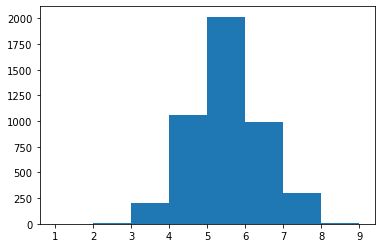

In [17]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [18]:
iters = simulate_robust(G, W, 5, range(N), 0.4, False, True, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 4    acc: 4.75                                  
Result 12: 4    acc: 4.6923076923076925                    
Result 13: 4    acc: 4.642857142857143                     
Result 14: 5    acc: 4.666666666666667                     
Result 15: 5    acc: 4.6875                                
Result 16: 4    acc: 4.647058823529412  

Result 136: 5    acc: 4.795620437956204                    
Result 137: 5    acc: 4.797101449275362                    
Result 138: 5    acc: 4.798561151079137                    
Result 139: 5    acc: 4.8                                  
Result 140: 5    acc: 4.801418439716312                    
Result 141: 5    acc: 4.802816901408451                    
Result 142: 5    acc: 4.804195804195804                    
Result 143: 5    acc: 4.805555555555555                    
Result 144: 5    acc: 4.8068965517241375                   
Result 145: 5    acc: 4.808219178082192                    
Result 146: 5    acc: 4.809523809523809                    
Result 147: 5    acc: 4.8108108108108105                   
Result 148: 5    acc: 4.8120805369127515                   
Result 149: 5    acc: 4.8133333333333335                   
Result 150: 5    acc: 4.814569536423841                    
Result 151: 5    acc: 4.815789473684211                    
Result 152: 5    acc: 4.816993464052287 

Result 273: 4    acc: 4.7153284671532845                   
Result 274: 6    acc: 4.72                                 
Result 275: 6    acc: 4.72463768115942                     
Result 276: 6    acc: 4.729241877256317                    
Result 277: 6    acc: 4.733812949640288                    
Result 278: 6    acc: 4.738351254480286                    
Result 279: 5    acc: 4.739285714285714                    
Result 280: 5    acc: 4.740213523131673                    
Result 281: 5    acc: 4.74113475177305                     
Result 282: 4    acc: 4.738515901060071                    
Result 283: 6    acc: 4.742957746478873                    
Result 284: 5    acc: 4.743859649122807                    
Result 285: 5    acc: 4.744755244755245                    
Result 286: 4    acc: 4.7421602787456445                   
Result 287: 4    acc: 4.739583333333333                    
Result 288: 6    acc: 4.743944636678201                    
Result 289: 6    acc: 4.748275862068965 

Result 410: 3    acc: 4.885644768856448                    
Result 411: 3    acc: 4.881067961165049                    
Result 412: 5    acc: 4.88135593220339                     
Result 413: 6    acc: 4.884057971014493                    
Result 414: 5    acc: 4.88433734939759                     
Result 415: 5    acc: 4.884615384615385                    
Result 416: 4    acc: 4.882494004796163                    
Result 417: 4    acc: 4.880382775119617                    
Result 418: 7    acc: 4.885441527446301                    
Result 419: 5    acc: 4.885714285714286                    
Result 420: 5    acc: 4.885985748218527                    
Result 421: 5    acc: 4.886255924170616                    
Result 422: 4    acc: 4.884160756501182                    
Result 423: 4    acc: 4.882075471698113                    
Result 424: 6    acc: 4.884705882352941                    
Result 425: 5    acc: 4.884976525821596                    
Result 426: 4    acc: 4.882903981264637 

Result 546: 5    acc: 4.86654478976234                     
Result 547: 5    acc: 4.866788321167883                    
Result 548: 5    acc: 4.8670309653916215                   
Result 549: 5    acc: 4.867272727272727                    
Result 550: 5    acc: 4.867513611615245                    
Result 551: 5    acc: 4.867753623188406                    
Result 552: 5    acc: 4.867992766726944                    
Result 553: 5    acc: 4.868231046931408                    
Result 554: 5    acc: 4.8684684684684685                   
Result 555: 5    acc: 4.868705035971223                    
Result 556: 5    acc: 4.868940754039497                    
Result 557: 5    acc: 4.869175627240144                    
Result 558: 5    acc: 4.869409660107334                    
Result 559: 5    acc: 4.869642857142857                    
Result 560: 5    acc: 4.8698752228163995                   
Result 561: 5    acc: 4.870106761565836                    
Result 562: 5    acc: 4.870337477797514 

Result 683: 4    acc: 4.826023391812866                    
Result 684: 3    acc: 4.823357664233576                    
Result 685: 4    acc: 4.822157434402333                    
Result 686: 4    acc: 4.820960698689956                    
Result 687: 5    acc: 4.821220930232558                    
Result 688: 4    acc: 4.820029027576197                    
Result 689: 5    acc: 4.820289855072463                    
Result 690: 5    acc: 4.8205499276411                      
Result 691: 5    acc: 4.820809248554913                    
Result 692: 5    acc: 4.821067821067821                    
Result 693: 5    acc: 4.821325648414986                    
Result 694: 5    acc: 4.821582733812949                    
Result 695: 5    acc: 4.82183908045977                     
Result 696: 4    acc: 4.820659971305595                    
Result 697: 5    acc: 4.820916905444126                    
Result 698: 4    acc: 4.819742489270387                    
Result 699: 4    acc: 4.8185714285714285

Result 820: 5    acc: 4.778319123020706                    
Result 821: 5    acc: 4.778588807785888                    
Result 822: 5    acc: 4.778857837181045                    
Result 823: 3    acc: 4.776699029126213                    
Result 824: 3    acc: 4.774545454545454                    
Result 825: 5    acc: 4.774818401937046                    
Result 826: 5    acc: 4.77509068923821                     
Result 827: 5    acc: 4.77536231884058                     
Result 828: 5    acc: 4.775633293124246                    
Result 829: 6    acc: 4.77710843373494                     
Result 830: 4    acc: 4.776173285198556                    
Result 831: 4    acc: 4.775240384615385                    
Result 832: 4    acc: 4.774309723889556                    
Result 833: 4    acc: 4.773381294964029                    
Result 834: 4    acc: 4.772455089820359                    
Result 835: 4    acc: 4.771531100478469                    
Result 836: 4    acc: 4.770609318996415 

Result 958: 4    acc: 4.736183524504693                    
Result 959: 4    acc: 4.735416666666667                    
Result 960: 4    acc: 4.73465140478668                     
Result 961: 5    acc: 4.734927234927235                    
Result 962: 4    acc: 4.734164070612668                    
Result 963: 4    acc: 4.733402489626556                    
Result 964: 4    acc: 4.732642487046632                    
Result 965: 4    acc: 4.731884057971015                    
Result 966: 4    acc: 4.731127197518097                    
Result 967: 4    acc: 4.730371900826446                    
Result 968: 4    acc: 4.729618163054695                    
Result 969: 5    acc: 4.729896907216495                    
Result 970: 5    acc: 4.7301750772399584                   
Result 971: 4    acc: 4.729423868312757                    
Result 972: 6    acc: 4.730729701952724                    
Result 973: 6    acc: 4.732032854209446                    
Result 974: 6    acc: 4.733333333333333 

Result 1096: 4    acc: 4.725615314494075                   
Result 1097: 4    acc: 4.7249544626593805                  
Result 1098: 4    acc: 4.724294813466788                   
Result 1099: 4    acc: 4.723636363636364                   
Result 1100: 5    acc: 4.7238873751135335                  
Result 1101: 9    acc: 4.727767695099819                   
Result 1102: 3    acc: 4.726201269265639                   
Result 1103: 7    acc: 4.728260869565218                   
Result 1104: 7    acc: 4.730316742081448                   
Result 1105: 5    acc: 4.730560578661844                   
Result 1106: 4    acc: 4.729900632339657                   
Result 1107: 5    acc: 4.73014440433213                    
Result 1108: 5    acc: 4.730387736699729                   
Result 1109: 5    acc: 4.730630630630631                   
Result 1110: 5    acc: 4.730873087308731                   
Result 1111: 4    acc: 4.73021582733813                    
Result 1112: 6    acc: 4.731356693620844

Result 1233: 5    acc: 4.706645056726094                   
Result 1234: 5    acc: 4.706882591093118                   
Result 1235: 5    acc: 4.707119741100324                   
Result 1236: 5    acc: 4.7073565076798705                  
Result 1237: 5    acc: 4.707592891760905                   
Result 1238: 5    acc: 4.707828894269572                   
Result 1239: 5    acc: 4.708064516129032                   
Result 1240: 5    acc: 4.708299758259468                   
Result 1241: 5    acc: 4.708534621578099                   
Result 1242: 4    acc: 4.707964601769912                   
Result 1243: 4    acc: 4.707395498392283                   
Result 1244: 5    acc: 4.707630522088353                   
Result 1245: 4    acc: 4.707062600321027                   
Result 1246: 4    acc: 4.706495589414595                   
Result 1247: 4    acc: 4.705929487179487                   
Result 1248: 5    acc: 4.7061649319455565                  
Result 1249: 5    acc: 4.7064           

Result 1369: 6    acc: 4.71021897810219                    
Result 1370: 6    acc: 4.711159737417943                   
Result 1371: 6    acc: 4.712099125364431                   
Result 1372: 6    acc: 4.713037144938092                   
Result 1373: 6    acc: 4.713973799126638                   
Result 1374: 5    acc: 4.714181818181818                   
Result 1375: 5    acc: 4.714389534883721                   
Result 1376: 4    acc: 4.7138707334785765                  
Result 1377: 5    acc: 4.714078374455733                   
Result 1378: 5    acc: 4.714285714285714                   
Result 1379: 5    acc: 4.714492753623189                   
Result 1380: 5    acc: 4.714699493120927                   
Result 1381: 5    acc: 4.714905933429812                   
Result 1382: 5    acc: 4.715112075198843                   
Result 1383: 5    acc: 4.715317919075145                   
Result 1384: 5    acc: 4.7155234657039715                  
Result 1385: 5    acc: 4.715728715728716

Result 1505: 5    acc: 4.709827357237716                   
Result 1506: 5    acc: 4.710019907100199                   
Result 1507: 5    acc: 4.710212201591512                   
Result 1508: 5    acc: 4.710404241219351                   
Result 1509: 5    acc: 4.710596026490066                   
Result 1510: 5    acc: 4.710787557908669                   
Result 1511: 3    acc: 4.709656084656085                   
Result 1512: 4    acc: 4.709187045604759                   
Result 1513: 4    acc: 4.708718626155878                   
Result 1514: 4    acc: 4.708250825082509                   
Result 1515: 4    acc: 4.70778364116095                    
Result 1516: 5    acc: 4.707976268951879                   
Result 1517: 4    acc: 4.707509881422925                   
Result 1518: 4    acc: 4.707044107965767                   
Result 1519: 4    acc: 4.706578947368421                   
Result 1520: 4    acc: 4.70611439842209                    
Result 1521: 4    acc: 4.705650459921157

Result 1642: 5    acc: 4.692635423006695                   
Result 1643: 5    acc: 4.692822384428224                   
Result 1644: 5    acc: 4.693009118541034                   
Result 1645: 5    acc: 4.693195625759417                   
Result 1646: 5    acc: 4.69338190649666                    
Result 1647: 4    acc: 4.692961165048544                   
Result 1648: 4    acc: 4.692540933899333                   
Result 1649: 6    acc: 4.693333333333333                   
Result 1650: 5    acc: 4.693519079345851                   
Result 1651: 5    acc: 4.693704600484262                   
Result 1652: 5    acc: 4.6938898971566845                  
Result 1653: 5    acc: 4.694074969770254                   
Result 1654: 5    acc: 4.694259818731118                   
Result 1655: 5    acc: 4.694444444444445                   
Result 1656: 5    acc: 4.694628847314424                   
Result 1657: 5    acc: 4.69481302774427                    
Result 1658: 5    acc: 4.694996986136227

Result 1779: 4    acc: 4.678089887640449                   
Result 1780: 4    acc: 4.6777091521617065                  
Result 1781: 4    acc: 4.677328843995511                   
Result 1782: 5    acc: 4.677509814918676                   
Result 1783: 5    acc: 4.677690582959642                   
Result 1784: 5    acc: 4.677871148459384                   
Result 1785: 5    acc: 4.6780515117581185                  
Result 1786: 5    acc: 4.6782316731953                     
Result 1787: 5    acc: 4.6784116331096195                  
Result 1788: 5    acc: 4.678591391839016                   
Result 1789: 4    acc: 4.678212290502794                   
Result 1790: 4    acc: 4.677833612506979                   
Result 1791: 4    acc: 4.677455357142857                   
Result 1792: 4    acc: 4.67707752370329                    
Result 1793: 4    acc: 4.67670011148272                    
Result 1794: 5    acc: 4.676880222841226                   
Result 1795: 5    acc: 4.67706013363029 

Result 1916: 4    acc: 4.669796557120501                   
Result 1917: 4    acc: 4.669447340980188                   
Result 1918: 4    acc: 4.669098488796248                   
Result 1919: 5    acc: 4.669270833333333                   
Result 1920: 5    acc: 4.6694429984383135                  
Result 1921: 5    acc: 4.669614984391259                   
Result 1922: 5    acc: 4.669786791471659                   
Result 1923: 4    acc: 4.669438669438669                   
Result 1924: 4    acc: 4.669090909090909                   
Result 1925: 4    acc: 4.668743509865005                   
Result 1926: 4    acc: 4.668396471198754                   
Result 1927: 4    acc: 4.668049792531121                   
Result 1928: 4    acc: 4.667703473302229                   
Result 1929: 4    acc: 4.667357512953368                   
Result 1930: 4    acc: 4.6670119109269805                  
Result 1931: 4    acc: 4.666666666666667                   
Result 1932: 4    acc: 4.666321779617175

Result 2052: 4    acc: 4.651729176814418                   
Result 2053: 4    acc: 4.651411879259981                   
Result 2054: 6    acc: 4.652068126520681                   
Result 2055: 6    acc: 4.652723735408561                   
Result 2056: 3    acc: 4.651920272241128                   
Result 2057: 6    acc: 4.652575315840622                   
Result 2058: 6    acc: 4.653229723166586                   
Result 2059: 6    acc: 4.653883495145631                   
Result 2060: 4    acc: 4.653566229985444                   
Result 2061: 5    acc: 4.653734238603298                   
Result 2062: 6    acc: 4.6543868153174985                  
Result 2063: 6    acc: 4.655038759689923                   
Result 2064: 6    acc: 4.655690072639225                   
Result 2065: 6    acc: 4.656340755082285                   
Result 2066: 6    acc: 4.656990807934204                   
Result 2067: 6    acc: 4.657640232108317                   
Result 2068: 6    acc: 4.658289028516191

Result 2189: 5    acc: 4.6287671232876715                  
Result 2190: 5    acc: 4.628936558649019                   
Result 2191: 5    acc: 4.6291058394160585                  
Result 2192: 5    acc: 4.629274965800273                   
Result 2193: 5    acc: 4.629443938012762                   
Result 2194: 5    acc: 4.629612756264237                   
Result 2195: 5    acc: 4.629781420765028                   
Result 2196: 5    acc: 4.62994993172508                    
Result 2197: 5    acc: 4.630118289353958                   
Result 2198: 5    acc: 4.6302864938608455                  
Result 2199: 5    acc: 4.630454545454546                   
Result 2200: 5    acc: 4.63062244434348                    
Result 2201: 5    acc: 4.630790190735695                   
Result 2202: 5    acc: 4.630957784838856                   
Result 2203: 5    acc: 4.631125226860254                   
Result 2204: 5    acc: 4.631292517006803                   
Result 2205: 5    acc: 4.631459655485041

Result 2327: 5    acc: 4.634450171821306                   
Result 2328: 5    acc: 4.634607127522542                   
Result 2329: 5    acc: 4.634763948497854                   
Result 2330: 5    acc: 4.634920634920635                   
Result 2331: 5    acc: 4.635077186963979                   
Result 2332: 5    acc: 4.6352336048006855                  
Result 2333: 4    acc: 4.634961439588689                   
Result 2334: 4    acc: 4.634689507494647                   
Result 2335: 4    acc: 4.634417808219178                   
Result 2336: 4    acc: 4.634146341463414                   
Result 2337: 4    acc: 4.633875106928999                   
Result 2338: 4    acc: 4.633604104318085                   
Result 2339: 4    acc: 4.633333333333334                   
Result 2340: 4    acc: 4.633062793677915                   
Result 2341: 4    acc: 4.632792485055508                   
Result 2342: 4    acc: 4.632522407170295                   
Result 2343: 4    acc: 4.632252559726963

Result 2464: 5    acc: 4.683975659229209                   
Result 2465: 5    acc: 4.684103811841038                   
Result 2466: 5    acc: 4.684231860559384                   
Result 2467: 5    acc: 4.684359805510534                   
Result 2468: 5    acc: 4.684487646820575                   
Result 2469: 5    acc: 4.684615384615385                   
Result 2470: 5    acc: 4.684743019020639                   
Result 2471: 5    acc: 4.684870550161812                   
Result 2472: 5    acc: 4.684997978164173                   
Result 2473: 5    acc: 4.685125303152789                   
Result 2474: 5    acc: 4.685252525252525                   
Result 2475: 5    acc: 4.685379644588045                   
Result 2476: 5    acc: 4.685506661283811                   
Result 2477: 5    acc: 4.685633575464084                   
Result 2478: 5    acc: 4.685760387252925                   
Result 2479: 4    acc: 4.685483870967742                   
Result 2480: 6    acc: 4.686013704151552

Result 2600: 5    acc: 4.686274509803922                   
Result 2601: 5    acc: 4.686395080707149                   
Result 2602: 5    acc: 4.686515558970418                   
Result 2603: 5    acc: 4.686635944700461                   
Result 2604: 3    acc: 4.685988483685221                   
Result 2605: 5    acc: 4.686108979278588                   
Result 2606: 5    acc: 4.686229382431914                   
Result 2607: 5    acc: 4.686349693251533                   
Result 2608: 5    acc: 4.686469911843618                   
Result 2609: 5    acc: 4.6865900383141765                  
Result 2610: 5    acc: 4.686710072769054                   
Result 2611: 5    acc: 4.6868300153139355                  
Result 2612: 5    acc: 4.686949866054344                   
Result 2613: 5    acc: 4.6870696250956385                  
Result 2614: 5    acc: 4.687189292543021                   
Result 2615: 5    acc: 4.687308868501529                   
Result 2616: 5    acc: 4.687428353076041

Result 2737: 4    acc: 4.685536888239591                   
Result 2738: 4    acc: 4.685286600949252                   
Result 2739: 4    acc: 4.685036496350365                   
Result 2740: 4    acc: 4.684786574242977                   
Result 2741: 4    acc: 4.684536834427425                   
Result 2742: 4    acc: 4.684287276704338                   
Result 2743: 4    acc: 4.684037900874635                   
Result 2744: 5    acc: 4.684153005464481                   
Result 2745: 3    acc: 4.68353969410051                    
Result 2746: 4    acc: 4.683290862759374                   
Result 2747: 4    acc: 4.683042212518195                   
Result 2748: 4    acc: 4.682793743179338                   
Result 2749: 4    acc: 4.682545454545455                   
Result 2750: 4    acc: 4.6822973464194835                  
Result 2751: 5    acc: 4.682412790697675                   
Result 2752: 6    acc: 4.68289139120959                    
Result 2753: 8    acc: 4.684095860566448

Result 2875: 4    acc: 4.692976356050069                   
Result 2876: 4    acc: 4.692735488355926                   
Result 2877: 4    acc: 4.692494788047255                   
Result 2878: 4    acc: 4.692254254949635                   
Result 2879: 8    acc: 4.693402777777778                   
Result 2880: 8    acc: 4.694550503297466                   
Result 2881: 8    acc: 4.695697432338654                   
Result 2882: 8    acc: 4.696843565730142                   
Result 2883: 8    acc: 4.697988904299584                   
Result 2884: 8    acc: 4.699133448873484                   
Result 2885: 8    acc: 4.7002772002772                     
Result 2886: 8    acc: 4.701420159334949                   
Result 2887: 8    acc: 4.702562326869806                   
Result 2888: 8    acc: 4.703703703703703                   
Result 2889: 8    acc: 4.704844290657439                   
Result 2890: 8    acc: 4.705984088550674                   
Result 2891: 8    acc: 4.707123098201936

Result 3013: 3    acc: 4.704047777040477                   
Result 3014: 3    acc: 4.703482587064677                   
Result 3015: 3    acc: 4.702917771883289                   
Result 3016: 4    acc: 4.702684786211468                   
Result 3017: 5    acc: 4.702783300198807                   
Result 3018: 5    acc: 4.702881748923485                   
Result 3019: 5    acc: 4.702980132450331                   
Result 3020: 5    acc: 4.7030784508440915                  
Result 3021: 5    acc: 4.703176704169424                   
Result 3022: 5    acc: 4.703274892490903                   
Result 3023: 5    acc: 4.703373015873016                   
Result 3024: 5    acc: 4.7034710743801655                  
Result 3025: 5    acc: 4.703569068076669                   
Result 3026: 5    acc: 4.703666997026759                   
Result 3027: 5    acc: 4.703764861294584                   
Result 3028: 5    acc: 4.703862660944206                   
Result 3029: 5    acc: 4.703960396039604

Result 3149: 6    acc: 4.734285714285714                   
Result 3150: 6    acc: 4.734687400825135                   
Result 3151: 7    acc: 4.7354060913705585                  
Result 3152: 7    acc: 4.736124326038693                   
Result 3153: 7    acc: 4.7368421052631575                  
Result 3154: 5    acc: 4.736925515055468                   
Result 3155: 6    acc: 4.737325728770596                   
Result 3156: 4    acc: 4.737092176116566                   
Result 3157: 4    acc: 4.736858771374288                   
Result 3158: 4    acc: 4.7366255144032925                  
Result 3159: 4    acc: 4.736392405063291                   
Result 3160: 4    acc: 4.736159443214173                   
Result 3161: 4    acc: 4.735926628716003                   
Result 3162: 4    acc: 4.735693961429023                   
Result 3163: 4    acc: 4.735461441213654                   
Result 3164: 4    acc: 4.73522906793049                    
Result 3165: 4    acc: 4.734996841440303

Result 3285: 5    acc: 4.734023128423615                   
Result 3286: 5    acc: 4.734104046242774                   
Result 3287: 5    acc: 4.734184914841849                   
Result 3288: 5    acc: 4.734265734265734                   
Result 3289: 5    acc: 4.73434650455927                    
Result 3290: 4    acc: 4.734123366757824                   
Result 3291: 5    acc: 4.734204131227218                   
Result 3292: 5    acc: 4.734284846644397                   
Result 3293: 5    acc: 4.734365513054038                   
Result 3294: 5    acc: 4.734446130500759                   
Result 3295: 5    acc: 4.734526699029126                   
Result 3296: 4    acc: 4.734303912647862                   
Result 3297: 4    acc: 4.734081261370528                   
Result 3298: 4    acc: 4.733858745074265                   
Result 3299: 4    acc: 4.733636363636363                   
Result 3300: 4    acc: 4.733414116934262                   
Result 3301: 4    acc: 4.733192004845548

Result 3421: 5    acc: 4.757451782583285                   
Result 3422: 5    acc: 4.757522640958224                   
Result 3423: 5    acc: 4.757593457943925                   
Result 3424: 5    acc: 4.757664233576643                   
Result 3425: 4    acc: 4.757443082311734                   
Result 3426: 4    acc: 4.757222060110884                   
Result 3427: 5    acc: 4.757292882147024                   
Result 3428: 5    acc: 4.757363662875474                   
Result 3429: 4    acc: 4.757142857142857                   
Result 3430: 4    acc: 4.756922180122413                   
Result 3431: 4    acc: 4.756701631701632                   
Result 3432: 6    acc: 4.757063792601223                   
Result 3433: 5    acc: 4.75713453698311                    
Result 3434: 5    acc: 4.757205240174672                   
Result 3435: 4    acc: 4.756984866123399                   
Result 3436: 5    acc: 4.757055571719523                   
Result 3437: 6    acc: 4.757417102966841

Result 3560: 3    acc: 4.777309744453805                   
Result 3561: 3    acc: 4.776810780460416                   
Result 3562: 3    acc: 4.776312096547853                   
Result 3563: 5    acc: 4.776374859708193                   
Result 3564: 5    acc: 4.776437587657784                   
Result 3565: 5    acc: 4.776500280426248                   
Result 3566: 7    acc: 4.777123633305298                   
Result 3567: 8    acc: 4.778026905829597                   
Result 3568: 7    acc: 4.778649481647521                   
Result 3569: 6    acc: 4.778991596638655                   
Result 3570: 6    acc: 4.779333520022402                   
Result 3571: 6    acc: 4.779675251959686                   
Result 3572: 4    acc: 4.7794570389028825                  
Result 3573: 4    acc: 4.779238947957471                   
Result 3574: 4    acc: 4.779020979020979                   
Result 3575: 4    acc: 4.778803131991052                   
Result 3576: 4    acc: 4.778585406765446

Result 3697: 5    acc: 4.777447268793943                   
Result 3698: 5    acc: 4.777507434441741                   
Result 3699: 4    acc: 4.777297297297297                   
Result 3700: 4    acc: 4.7770872737098085                  
Result 3701: 4    acc: 4.77687736358725                    
Result 3702: 5    acc: 4.776937618147448                   
Result 3703: 5    acc: 4.776997840172786                   
Result 3704: 5    acc: 4.777058029689608                   
Result 3705: 5    acc: 4.777118186724231                   
Result 3706: 5    acc: 4.77717831130294                    
Result 3707: 5    acc: 4.777238403451996                   
Result 3708: 5    acc: 4.777298463197627                   
Result 3709: 5    acc: 4.777358490566038                   
Result 3710: 5    acc: 4.777418485583401                   
Result 3711: 5    acc: 4.777478448275862                   
Result 3712: 5    acc: 4.777538378669539                   
Result 3713: 5    acc: 4.777598276790522

Result 3835: 5    acc: 4.7763295099061525                  
Result 3836: 5    acc: 4.776387802971072                   
Result 3837: 5    acc: 4.776446065659197                   
Result 3838: 5    acc: 4.776504297994269                   
Result 3839: 5    acc: 4.7765625                           
Result 3840: 5    acc: 4.776620671700078                   
Result 3841: 5    acc: 4.776678813118168                   
Result 3842: 4    acc: 4.776476710902941                   
Result 3843: 8    acc: 4.777315296566077                   
Result 3844: 4    acc: 4.777113133940182                   
Result 3845: 4    acc: 4.776911076443057                   
Result 3846: 4    acc: 4.776709123992721                   
Result 3847: 4    acc: 4.776507276507276                   
Result 3848: 5    acc: 4.776565341647181                   
Result 3849: 4    acc: 4.776363636363636                   
Result 3850: 4    acc: 4.776162035834848                   
Result 3851: 8    acc: 4.776998961578401

Result 3972: 5    acc: 4.791844953435691                   
Result 3973: 5    acc: 4.791897332662305                   
Result 3974: 5    acc: 4.7919496855345916                  
Result 3975: 5    acc: 4.792002012072435                   
Result 3976: 5    acc: 4.792054312295701                   
Result 3977: 5    acc: 4.792106586224233                   
Result 3978: 5    acc: 4.792158833877859                   
Result 3979: 5    acc: 4.792211055276382                   
Result 3980: 6    acc: 4.792514443607134                   
Result 3981: 6    acc: 4.792817679558011                   
Result 3982: 6    acc: 4.793120763243786                   
Result 3983: 5    acc: 4.793172690763052                   
Result 3984: 5    acc: 4.793224592220828                   
Result 3985: 5    acc: 4.793276467636729                   
Result 3986: 5    acc: 4.7933283170303485                  
Result 3987: 5    acc: 4.793380140421264                   
Result 3988: 5    acc: 4.793431937829029

Result 4109: 5    acc: 4.794403892944039                   
Result 4110: 4    acc: 4.7942106543420095                  
Result 4111: 5    acc: 4.794260700389105                   
Result 4112: 5    acc: 4.794310722100657                   
Result 4113: 6    acc: 4.794603791929995                   
Result 4114: 6    acc: 4.794896719319563                   
Result 4115: 4    acc: 4.794703595724004                   
Result 4116: 5    acc: 4.794753461258198                   
Result 4117: 5    acc: 4.794803302574065                   
Result 4118: 5    acc: 4.794853119689245                   
Result 4119: 5    acc: 4.794902912621359                   
Result 4120: 5    acc: 4.794952681388013                   
Result 4121: 5    acc: 4.795002426006793                   
Result 4122: 5    acc: 4.79505214649527                    
Result 4123: 5    acc: 4.795101842870999                   
Result 4124: 5    acc: 4.795151515151515                   
Result 4125: 4    acc: 4.794958797867184

Result 4246: 7    acc: 4.802684247704262                   
Result 4247: 6    acc: 4.802966101694915                   
Result 4248: 6    acc: 4.8032478230171805                  
Result 4249: 4    acc: 4.803058823529412                   
Result 4250: 6    acc: 4.803340390496354                   
Result 4251: 3    acc: 4.802916274694262                   
Result 4252: 4    acc: 4.802727486480132                   
Result 4253: 5    acc: 4.802773859896568                   
Result 4254: 5    acc: 4.802820211515864                   
Result 4255: 4    acc: 4.802631578947368                   
Result 4256: 5    acc: 4.802677942212826                   
Result 4257: 5    acc: 4.802724283701268                   
Result 4258: 5    acc: 4.802770603428034                   
Result 4259: 4    acc: 4.802582159624413                   
Result 4260: 4    acc: 4.802393804271298                   
Result 4261: 7    acc: 4.802909432191459                   
Result 4262: 5    acc: 4.802955665024631

Result 4382: 5    acc: 4.819301848049282                   
Result 4383: 5    acc: 4.819343065693431                   
Result 4384: 6    acc: 4.819612314709236                   
Result 4385: 6    acc: 4.819881440948472                   
Result 4386: 6    acc: 4.820150444495099                   
Result 4387: 6    acc: 4.820419325432999                   
Result 4388: 6    acc: 4.820688083845979                   
Result 4389: 5    acc: 4.820728929384966                   
Result 4390: 5    acc: 4.820769756319745                   
Result 4391: 5    acc: 4.820810564663024                   
Result 4392: 4    acc: 4.8206237195538355                  
Result 4393: 4    acc: 4.820436959490214                   
Result 4394: 5    acc: 4.820477815699658                   
Result 4395: 5    acc: 4.820518653321201                   
Result 4396: 5    acc: 4.820559472367523                   
Result 4397: 5    acc: 4.820600272851296                   
Result 4398: 4    acc: 4.820413730393271

Result 4519: 7    acc: 4.815929203539823                   
Result 4520: 7    acc: 4.816412298164123                   
Result 4521: 7    acc: 4.816895179124281                   
Result 4522: 7    acc: 4.8173778465620165                  
Result 4523: 7    acc: 4.817860300618921                   
Result 4524: 7    acc: 4.818342541436464                   
Result 4525: 7    acc: 4.8188245691559874                  
Result 4526: 7    acc: 4.81930638391871                    
Result 4527: 7    acc: 4.819787985865724                   
Result 4528: 7    acc: 4.8202693751379995                  
Result 4529: 5    acc: 4.820309050772627                   
Result 4530: 5    acc: 4.820348708894284                   
Result 4531: 5    acc: 4.820388349514563                   
Result 4532: 5    acc: 4.820427972645048                   
Result 4533: 5    acc: 4.820467578297309                   
Result 4534: 5    acc: 4.820507166482911                   
Result 4535: 5    acc: 4.820546737213404

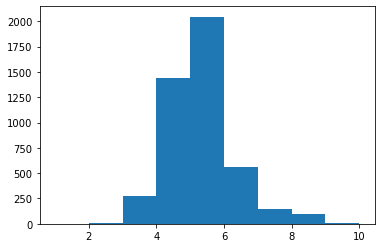

In [19]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [20]:
iters = simulate_robust(G, W, 5, range(N), 0.8, False, True, False)

Result 0: 4    acc: 4.0                                    
Result 1: 4    acc: 4.0                                    
Result 2: 3    acc: 3.6666666666666665                     
Result 3: 3    acc: 3.5                                    
Result 4: 5    acc: 3.8                                    
Result 5: 5    acc: 4.0                                    
Result 6: 5    acc: 4.142857142857143                      
Result 7: 5    acc: 4.25                                   
Result 8: 5    acc: 4.333333333333333                      
Result 9: 5    acc: 4.4                                    
Result 10: 5    acc: 4.454545454545454                     
Result 11: 5    acc: 4.5                                   
Result 12: 5    acc: 4.538461538461538                     
Result 13: 5    acc: 4.571428571428571                     
Result 14: 4    acc: 4.533333333333333                     
Result 15: 4    acc: 4.5                                   
Result 16: 4    acc: 4.470588235294118  

Result 136: 4    acc: 6.145985401459854                    
Result 137: 4    acc: 6.130434782608695                    
Result 138: 7    acc: 6.136690647482014                    
Result 139: 7    acc: 6.142857142857143                    
Result 140: 7    acc: 6.148936170212766                    
Result 141: 7    acc: 6.154929577464789                    
Result 142: 6    acc: 6.153846153846154                    
Result 143: 4    acc: 6.138888888888889                    
Result 144: 6    acc: 6.137931034482759                    
Result 145: 6    acc: 6.136986301369863                    
Result 146: 6    acc: 6.136054421768708                    
Result 147: 7    acc: 6.141891891891892                    
Result 148: 7    acc: 6.147651006711409                    
Result 149: 6    acc: 6.1466666666666665                   
Result 150: 7    acc: 6.152317880794702                    
Result 151: 7    acc: 6.157894736842105                    
Result 152: 7    acc: 6.163398692810458 

Result 274: 13    acc: 5.665454545454545                   
Result 275: 13    acc: 5.692028985507246                   
Result 276: 12    acc: 5.714801444043322                   
Result 277: 12    acc: 5.737410071942446                   
Result 278: 9    acc: 5.749103942652329                    
Result 279: 5    acc: 5.746428571428571                    
Result 280: 5    acc: 5.7437722419928825                   
Result 281: 4    acc: 5.73758865248227                     
Result 282: 4    acc: 5.731448763250883                    
Result 283: 6    acc: 5.732394366197183                    
Result 284: 5    acc: 5.729824561403508                    
Result 285: 5    acc: 5.7272727272727275                   
Result 286: 4    acc: 5.7212543554006965                   
Result 287: 5    acc: 5.71875                              
Result 288: 6    acc: 5.719723183391004                    
Result 289: 6    acc: 5.720689655172414                    
Result 290: 5    acc: 5.718213058419244 

Result 410: 6    acc: 5.598540145985401                    
Result 411: 6    acc: 5.599514563106796                    
Result 412: 5    acc: 5.598062953995157                    
Result 413: 6    acc: 5.599033816425121                    
Result 414: 5    acc: 5.597590361445783                    
Result 415: 5    acc: 5.596153846153846                    
Result 416: 4    acc: 5.592326139088729                    
Result 417: 4    acc: 5.588516746411483                    
Result 418: 6    acc: 5.5894988066825775                   
Result 419: 5    acc: 5.588095238095238                    
Result 420: 5    acc: 5.5866983372921615                   
Result 421: 5    acc: 5.585308056872038                    
Result 422: 4    acc: 5.581560283687943                    
Result 423: 4    acc: 5.577830188679245                    
Result 424: 6    acc: 5.578823529411765                    
Result 425: 4    acc: 5.575117370892019                    
Result 426: 4    acc: 5.571428571428571 

Result 547: 3    acc: 5.494525547445256                    
Result 548: 4    acc: 5.491803278688525                    
Result 549: 4    acc: 5.489090909090909                    
Result 550: 4    acc: 5.486388384754991                    
Result 551: 4    acc: 5.483695652173913                    
Result 552: 4    acc: 5.481012658227848                    
Result 553: 4    acc: 5.478339350180505                    
Result 554: 4    acc: 5.475675675675675                    
Result 555: 4    acc: 5.473021582733813                    
Result 556: 4    acc: 5.470377019748653                    
Result 557: 4    acc: 5.467741935483871                    
Result 558: 4    acc: 5.465116279069767                    
Result 559: 4    acc: 5.4625                               
Result 560: 4    acc: 5.459893048128342                    
Result 561: 4    acc: 5.45729537366548                     
Result 562: 4    acc: 5.4547069271758435                   
Result 563: 4    acc: 5.452127659574468 

Result 684: 3    acc: 5.28029197080292                     
Result 685: 4    acc: 5.278425655976676                    
Result 686: 4    acc: 5.276564774381368                    
Result 687: 4    acc: 5.274709302325581                    
Result 688: 4    acc: 5.272859216255442                    
Result 689: 4    acc: 5.271014492753623                    
Result 690: 4    acc: 5.2691751085383505                   
Result 691: 4    acc: 5.267341040462428                    
Result 692: 4    acc: 5.265512265512266                    
Result 693: 4    acc: 5.263688760806916                    
Result 694: 4    acc: 5.261870503597122                    
Result 695: 4    acc: 5.260057471264368                    
Result 696: 4    acc: 5.258249641319942                    
Result 697: 4    acc: 5.256446991404012                    
Result 698: 4    acc: 5.254649499284692                    
Result 699: 4    acc: 5.252857142857143                    
Result 700: 4    acc: 5.251069900142653 

Result 820: 5    acc: 5.20341047503045                     
Result 821: 5    acc: 5.20316301703163                     
Result 822: 9    acc: 5.207776427703524                    
Result 823: 3    acc: 5.205097087378641                    
Result 824: 3    acc: 5.202424242424242                    
Result 825: 5    acc: 5.202179176755448                    
Result 826: 4    acc: 5.200725513905684                    
Result 827: 5    acc: 5.200483091787439                    
Result 828: 5    acc: 5.200241254523522                    
Result 829: 6    acc: 5.201204819277108                    
Result 830: 4    acc: 5.199759326113116                    
Result 831: 4    acc: 5.1983173076923075                   
Result 832: 4    acc: 5.1968787515006                      
Result 833: 4    acc: 5.195443645083933                    
Result 834: 5    acc: 5.195209580838323                    
Result 835: 5    acc: 5.194976076555024                    
Result 836: 5    acc: 5.1947431302270015

Result 959: 4    acc: 5.196875                             
Result 960: 4    acc: 5.195629552549428                    
Result 961: 5    acc: 5.1954261954261955                   
Result 962: 4    acc: 5.194184839044652                    
Result 963: 4    acc: 5.1929460580912865                   
Result 964: 5    acc: 5.192746113989637                    
Result 965: 5    acc: 5.192546583850931                    
Result 966: 5    acc: 5.1923474663909                      
Result 967: 5    acc: 5.1921487603305785                   
Result 968: 5    acc: 5.191950464396285                    
Result 969: 6    acc: 5.192783505154639                    
Result 970: 4    acc: 5.1915550978372815                   
Result 971: 4    acc: 5.190329218106996                    
Result 972: 6    acc: 5.1911613566289825                   
Result 973: 6    acc: 5.191991786447638                    
Result 974: 6    acc: 5.1928205128205125                   
Result 975: 6    acc: 5.193647540983607 

Result 1096: 4    acc: 5.170464904284412                   
Result 1097: 4    acc: 5.169398907103825                   
Result 1098: 4    acc: 5.168334849863513                   
Result 1099: 4    acc: 5.167272727272727                   
Result 1100: 4    acc: 5.166212534059945                   
Result 1101: 12    acc: 5.172413793103448                  
Result 1102: 4    acc: 5.171350861287398                   
Result 1103: 4    acc: 5.170289855072464                   
Result 1104: 10    acc: 5.174660633484163                  
Result 1105: 4    acc: 5.173598553345389                   
Result 1106: 4    acc: 5.172538392050587                   
Result 1107: 5    acc: 5.172382671480144                   
Result 1108: 5    acc: 5.172227231740306                   
Result 1109: 4    acc: 5.171171171171171                   
Result 1110: 4    acc: 5.17011701170117                    
Result 1111: 4    acc: 5.169064748201439                   
Result 1112: 6    acc: 5.169811320754717

Result 1235: 4    acc: 5.127022653721683                   
Result 1236: 4    acc: 5.126111560226354                   
Result 1237: 4    acc: 5.125201938610663                   
Result 1238: 4    acc: 5.124293785310734                   
Result 1239: 4    acc: 5.123387096774193                   
Result 1240: 4    acc: 5.122481869460112                   
Result 1241: 5    acc: 5.122383252818035                   
Result 1242: 4    acc: 5.121480289621883                   
Result 1243: 4    acc: 5.120578778135048                   
Result 1244: 5    acc: 5.120481927710843                   
Result 1245: 4    acc: 5.119582664526485                   
Result 1246: 4    acc: 5.118684843624699                   
Result 1247: 4    acc: 5.117788461538462                   
Result 1248: 5    acc: 5.117694155324259                   
Result 1249: 5    acc: 5.1176                              
Result 1250: 5    acc: 5.117505995203837                   
Result 1251: 5    acc: 5.11741214057508 

Result 1371: 4    acc: 5.051020408163265                   
Result 1372: 4    acc: 5.050254916241807                   
Result 1373: 4    acc: 5.049490538573508                   
Result 1374: 4    acc: 5.048727272727272                   
Result 1375: 4    acc: 5.0479651162790695                  
Result 1376: 4    acc: 5.04720406681191                    
Result 1377: 4    acc: 5.04644412191582                    
Result 1378: 4    acc: 5.0456852791878175                  
Result 1379: 4    acc: 5.044927536231884                   
Result 1380: 4    acc: 5.044170890658942                   
Result 1381: 4    acc: 5.043415340086831                   
Result 1382: 4    acc: 5.042660882140275                   
Result 1383: 4    acc: 5.041907514450867                   
Result 1384: 4    acc: 5.041155234657039                   
Result 1385: 4    acc: 5.040404040404041                   
Result 1386: 4    acc: 5.039653929343908                   
Result 1387: 4    acc: 5.038904899135447

Result 1508: 5    acc: 5.019880715705765                   
Result 1509: 5    acc: 5.0198675496688745                  
Result 1510: 5    acc: 5.019854401058901                   
Result 1511: 3    acc: 5.018518518518518                   
Result 1512: 4    acc: 5.017845340383344                   
Result 1513: 4    acc: 5.017173051519155                   
Result 1514: 4    acc: 5.016501650165017                   
Result 1515: 4    acc: 5.015831134564643                   
Result 1516: 5    acc: 5.015820698747528                   
Result 1517: 4    acc: 5.015151515151516                   
Result 1518: 4    acc: 5.014483212639894                   
Result 1519: 4    acc: 5.013815789473684                   
Result 1520: 4    acc: 5.013149243918475                   
Result 1521: 4    acc: 5.012483574244415                   
Result 1522: 4    acc: 5.011818778726198                   
Result 1523: 4    acc: 5.011154855643045                   
Result 1524: 4    acc: 5.010491803278689

Result 1645: 7    acc: 5.008505467800729                   
Result 1646: 5    acc: 5.008500303582271                   
Result 1647: 4    acc: 5.007888349514563                   
Result 1648: 4    acc: 5.007277137659187                   
Result 1649: 3    acc: 5.006060606060606                   
Result 1650: 5    acc: 5.006056935190793                   
Result 1651: 5    acc: 5.006053268765133                   
Result 1652: 5    acc: 5.0060496067755595                  
Result 1653: 5    acc: 5.006045949214027                   
Result 1654: 5    acc: 5.006042296072508                   
Result 1655: 5    acc: 5.006038647342995                   
Result 1656: 5    acc: 5.006035003017502                   
Result 1657: 5    acc: 5.0060313630880575                  
Result 1658: 5    acc: 5.006027727546715                   
Result 1659: 5    acc: 5.006024096385542                   
Result 1660: 5    acc: 5.006020469596629                   
Result 1661: 5    acc: 5.006016847172082

Result 1781: 4    acc: 4.978114478114478                   
Result 1782: 5    acc: 4.978126752664049                   
Result 1783: 5    acc: 4.978139013452915                   
Result 1784: 5    acc: 4.978151260504202                   
Result 1785: 5    acc: 4.978163493840985                   
Result 1786: 5    acc: 4.97817571348629                    
Result 1787: 5    acc: 4.978187919463087                   
Result 1788: 5    acc: 4.978200111794298                   
Result 1789: 4    acc: 4.977653631284916                   
Result 1790: 4    acc: 4.977107761027359                   
Result 1791: 4    acc: 4.9765625                           
Result 1792: 4    acc: 4.976017847183491                   
Result 1793: 4    acc: 4.975473801560758                   
Result 1794: 7    acc: 4.976601671309192                   
Result 1795: 5    acc: 4.976614699331849                   
Result 1796: 3    acc: 4.975514746800223                   
Result 1797: 4    acc: 4.974972191323693

Result 1919: 5    acc: 4.966666666666667                   
Result 1920: 5    acc: 4.9666840187402395                  
Result 1921: 5    acc: 4.9667013527575445                  
Result 1922: 5    acc: 4.96671866874675                    
Result 1923: 5    acc: 4.966735966735967                   
Result 1924: 5    acc: 4.966753246753247                   
Result 1925: 5    acc: 4.966770508826584                   
Result 1926: 5    acc: 4.966787752983913                   
Result 1927: 5    acc: 4.966804979253112                   
Result 1928: 5    acc: 4.966822187662001                   
Result 1929: 5    acc: 4.966839378238342                   
Result 1930: 5    acc: 4.9668565510098395                  
Result 1931: 5    acc: 4.966873706004141                   
Result 1932: 5    acc: 4.966890843248836                   
Result 1933: 5    acc: 4.966907962771458                   
Result 1934: 5    acc: 4.966925064599483                   
Result 1935: 6    acc: 4.967458677685951

Result 2055: 15    acc: 4.970817120622568                  
Result 2056: 3    acc: 4.9698590179873605                  
Result 2057: 4    acc: 4.969387755102041                   
Result 2058: 5    acc: 4.969402622632346                   
Result 2059: 5    acc: 4.9694174757281555                  
Result 2060: 4    acc: 4.968947113051916                   
Result 2061: 4    acc: 4.968477206595538                   
Result 2062: 4    acc: 4.968007755695589                   
Result 2063: 4    acc: 4.967538759689923                   
Result 2064: 4    acc: 4.967070217917676                   
Result 2065: 4    acc: 4.966602129719265                   
Result 2066: 4    acc: 4.966134494436381                   
Result 2067: 4    acc: 4.965667311411992                   
Result 2068: 4    acc: 4.965200579990333                   
Result 2069: 6    acc: 4.965700483091787                   
Result 2070: 4    acc: 4.965234186383389                   
Result 2071: 4    acc: 4.96476833976834 

Result 2191: 5    acc: 4.956660583941606                   
Result 2192: 5    acc: 4.956680346557228                   
Result 2193: 5    acc: 4.956700091157703                   
Result 2194: 5    acc: 4.956719817767654                   
Result 2195: 5    acc: 4.956739526411657                   
Result 2196: 5    acc: 4.9567592171142465                  
Result 2197: 5    acc: 4.956778889899909                   
Result 2198: 5    acc: 4.956798544793088                   
Result 2199: 5    acc: 4.956818181818182                   
Result 2200: 5    acc: 4.956837800999546                   
Result 2201: 5    acc: 4.956857402361489                   
Result 2202: 5    acc: 4.95687698592828                    
Result 2203: 5    acc: 4.956896551724138                   
Result 2204: 5    acc: 4.956916099773243                   
Result 2205: 5    acc: 4.956935630099728                   
Result 2206: 5    acc: 4.956955142727685                   
Result 2207: 5    acc: 4.956974637681159

Result 2327: 5    acc: 4.935567010309279                   
Result 2328: 5    acc: 4.935594675826535                   
Result 2329: 5    acc: 4.935622317596566                   
Result 2330: 5    acc: 4.935649935649936                   
Result 2331: 5    acc: 4.935677530017153                   
Result 2332: 5    acc: 4.935705100728676                   
Result 2333: 4    acc: 4.935304198800343                   
Result 2334: 5    acc: 4.9353319057815845                  
Result 2335: 5    acc: 4.935359589041096                   
Result 2336: 4    acc: 4.934959349593496                   
Result 2337: 4    acc: 4.934559452523525                   
Result 2338: 5    acc: 4.934587430525866                   
Result 2339: 5    acc: 4.934615384615385                   
Result 2340: 5    acc: 4.934643314822726                   
Result 2341: 5    acc: 4.93467122117848                    
Result 2342: 5    acc: 4.934699103713188                   
Result 2343: 5    acc: 4.934726962457338

Result 2463: 6    acc: 4.971996753246753                   
Result 2464: 4    acc: 4.971602434077079                   
Result 2465: 4    acc: 4.971208434712084                   
Result 2466: 4    acc: 4.97081475476287                    
Result 2467: 4    acc: 4.970421393841167                   
Result 2468: 4    acc: 4.9700283515593355                  
Result 2469: 4    acc: 4.969635627530365                   
Result 2470: 4    acc: 4.969243221367868                   
Result 2471: 4    acc: 4.968851132686084                   
Result 2472: 4    acc: 4.968459361099879                   
Result 2473: 4    acc: 4.9680679062247375                  
Result 2474: 4    acc: 4.9676767676767675                  
Result 2475: 4    acc: 4.967285945072698                   
Result 2476: 4    acc: 4.966895438029875                   
Result 2477: 4    acc: 4.966505246166263                   
Result 2478: 4    acc: 4.966115369100444                   
Result 2479: 4    acc: 4.965725806451613

Result 2600: 5    acc: 4.969242599000385                   
Result 2601: 5    acc: 4.9692544196771715                  
Result 2602: 5    acc: 4.96926623127161                    
Result 2603: 5    acc: 4.969278033794163                   
Result 2604: 3    acc: 4.96852207293666                    
Result 2605: 4    acc: 4.968150422102839                   
Result 2606: 8    acc: 4.969313387034906                   
Result 2607: 8    acc: 4.9704754601226995                  
Result 2608: 8    acc: 4.971636642391721                   
Result 2609: 4    acc: 4.971264367816092                   
Result 2610: 5    acc: 4.971275373420146                   
Result 2611: 5    acc: 4.971286370597244                   
Result 2612: 7    acc: 4.972062763107539                   
Result 2613: 5    acc: 4.972073450650345                   
Result 2614: 5    acc: 4.9720841300191205                  
Result 2615: 5    acc: 4.972094801223242                   
Result 2616: 5    acc: 4.972105464272067

Result 2738: 4    acc: 4.965680905439942                   
Result 2739: 4    acc: 4.9653284671532845                  
Result 2740: 4    acc: 4.964976286026998                   
Result 2741: 5    acc: 4.964989059080962                   
Result 2742: 5    acc: 4.965001822821728                   
Result 2743: 4    acc: 4.964650145772595                   
Result 2744: 8    acc: 4.96575591985428                    
Result 2745: 3    acc: 4.9650400582665695                  
Result 2746: 4    acc: 4.964688751365125                   
Result 2747: 4    acc: 4.964337700145561                   
Result 2748: 4    acc: 4.963986904328847                   
Result 2749: 5    acc: 4.964                               
Result 2750: 5    acc: 4.964013086150491                   
Result 2751: 5    acc: 4.964026162790698                   
Result 2752: 6    acc: 4.964402470032692                   
Result 2753: 16    acc: 4.968409586056645                  
Result 2754: 16    acc: 4.97241379310344

Result 2874: 3    acc: 5.004869565217391                   
Result 2875: 4    acc: 5.0045201668984705                  
Result 2876: 4    acc: 5.004171011470282                   
Result 2877: 4    acc: 5.003822098679638                   
Result 2878: 4    acc: 5.003473428273706                   
Result 2879: 8    acc: 5.004513888888889                   
Result 2880: 8    acc: 5.005553627212773                   
Result 2881: 8    acc: 5.006592643997224                   
Result 2882: 8    acc: 5.007630939993063                   
Result 2883: 8    acc: 5.0086685159500695                  
Result 2884: 8    acc: 5.009705372616985                   
Result 2885: 8    acc: 5.010741510741511                   
Result 2886: 8    acc: 5.011776931070315                   
Result 2887: 8    acc: 5.01281163434903                    
Result 2888: 8    acc: 5.013845621322257                   
Result 2889: 8    acc: 5.014878892733564                   
Result 2890: 8    acc: 5.015911449325493

Result 3010: 5    acc: 5.004649618067087                   
Result 3011: 5    acc: 5.00464807436919                    
Result 3012: 4    acc: 5.0043146365748425                  
Result 3013: 4    acc: 5.003981420039814                   
Result 3014: 4    acc: 5.003648424543947                   
Result 3015: 5    acc: 5.003647214854111                   
Result 3016: 5    acc: 5.003646005966192                   
Result 3017: 5    acc: 5.0036447978793905                  
Result 3018: 5    acc: 5.003643590592912                   
Result 3019: 5    acc: 5.0036423841059605                  
Result 3020: 5    acc: 5.003641178417743                   
Result 3021: 5    acc: 5.0036399735274655                  
Result 3022: 5    acc: 5.003638769434337                   
Result 3023: 5    acc: 5.0036375661375665                  
Result 3024: 5    acc: 5.003636363636364                   
Result 3025: 5    acc: 5.003635161929941                   
Result 3026: 5    acc: 5.003633961017509

Result 3146: 16    acc: 5.111852557991738                  
Result 3147: 16    acc: 5.115311308767471                  
Result 3148: 16    acc: 5.118767862813591                  
Result 3149: 10    acc: 5.120317460317461                  
Result 3150: 16    acc: 5.123770231672485                  
Result 3151: 13    acc: 5.126269035532995                  
Result 3152: 13    acc: 5.128766254360926                  
Result 3153: 13    acc: 5.131261889663919                  
Result 3154: 5    acc: 5.13122028526149                    
Result 3155: 10    acc: 5.13276299112801                   
Result 3156: 4    acc: 5.132404181184669                   
Result 3157: 4    acc: 5.132045598480051                   
Result 3158: 4    acc: 5.131687242798354                   
Result 3159: 4    acc: 5.131329113924051                   
Result 3160: 4    acc: 5.130971211641885                   
Result 3161: 4    acc: 5.130613535736876                   
Result 3162: 4    acc: 5.13025608599431 

Result 3284: 7    acc: 5.1585996955859965                  
Result 3285: 7    acc: 5.159160073037127                   
Result 3286: 7    acc: 5.159720109522361                   
Result 3287: 7    acc: 5.160279805352798                   
Result 3288: 7    acc: 5.160839160839161                   
Result 3289: 4    acc: 5.16048632218845                    
Result 3290: 5    acc: 5.160437556973564                   
Result 3291: 4    acc: 5.1600850546780075                  
Result 3292: 7    acc: 5.160643789857273                   
Result 3293: 4    acc: 5.1602914389799635                  
Result 3294: 7    acc: 5.160849772382398                   
Result 3295: 7    acc: 5.161407766990291                   
Result 3296: 5    acc: 5.16135881104034                    
Result 3297: 5    acc: 5.161309884778654                   
Result 3298: 5    acc: 5.161260988178236                   
Result 3299: 5    acc: 5.161212121212121                   
Result 3300: 5    acc: 5.161163283853377

Result 3420: 5    acc: 5.2353113124817305                  
Result 3421: 5    acc: 5.235242548217417                   
Result 3422: 5    acc: 5.23517382413088                    
Result 3423: 5    acc: 5.235105140186916                   
Result 3424: 5    acc: 5.235036496350365                   
Result 3425: 4    acc: 5.234676007005254                   
Result 3426: 5    acc: 5.23460752845054                    
Result 3427: 5    acc: 5.234539089848308                   
Result 3428: 5    acc: 5.2344706911636045                  
Result 3429: 4    acc: 5.234110787172011                   
Result 3430: 4    acc: 5.233751092975809                   
Result 3431: 4    acc: 5.233391608391608                   
Result 3432: 11    acc: 5.235071366152054                  
Result 3433: 5    acc: 5.235002912055911                   
Result 3434: 7    acc: 5.2355167394468705                  
Result 3435: 5    acc: 5.235448195576251                   
Result 3436: 5    acc: 5.235379691591504

Result 3556: 4    acc: 5.240371099240933                   
Result 3557: 4    acc: 5.2400224845418775                  
Result 3558: 4    acc: 5.2396740657488055                  
Result 3559: 3    acc: 5.2390449438202245                  
Result 3560: 3    acc: 5.238416175231676                   
Result 3561: 3    acc: 5.2377877596855695                  
Result 3562: 3    acc: 5.237159696884648                   
Result 3563: 8    acc: 5.2379349046015715                  
Result 3564: 8    acc: 5.2387096774193544                  
Result 3565: 8    acc: 5.23948401570387                    
Result 3566: 11    acc: 5.241098962713765                  
Result 3567: 12    acc: 5.242993273542601                  
Result 3568: 11    acc: 5.244606332305968                  
Result 3569: 8    acc: 5.245378151260504                   
Result 3570: 8    acc: 5.246149537944554                   
Result 3571: 8    acc: 5.246920492721165                   
Result 3572: 8    acc: 5.247691015952981

Result 3692: 5    acc: 5.278635255889521                   
Result 3693: 5    acc: 5.278559826746075                   
Result 3694: 5    acc: 5.278484438430311                   
Result 3695: 5    acc: 5.278409090909091                   
Result 3696: 4    acc: 5.278063294563159                   
Result 3697: 4    acc: 5.277717685235262                   
Result 3698: 4    acc: 5.2773722627737225                  
Result 3699: 4    acc: 5.277027027027027                   
Result 3700: 3    acc: 5.276411780599838                   
Result 3701: 3    acc: 5.275796866558617                   
Result 3702: 5    acc: 5.275722387253579                   
Result 3703: 5    acc: 5.2756479481641465                  
Result 3704: 4    acc: 5.275303643724697                   
Result 3705: 4    acc: 5.274959525094442                   
Result 3706: 4    acc: 5.274615592123011                   
Result 3707: 4    acc: 5.274271844660194                   
Result 3708: 4    acc: 5.273928282555945

Result 3828: 4    acc: 5.27108905719509                    
Result 3829: 4    acc: 5.270757180156658                   
Result 3830: 4    acc: 5.270425476376925                   
Result 3831: 4    acc: 5.270093945720251                   
Result 3832: 4    acc: 5.269762588051135                   
Result 3833: 4    acc: 5.26943140323422                    
Result 3834: 4    acc: 5.269100391134289                   
Result 3835: 5    acc: 5.269030239833159                   
Result 3836: 5    acc: 5.268960125097733                   
Result 3837: 5    acc: 5.268890046899426                   
Result 3838: 5    acc: 5.26882000520969                    
Result 3839: 5    acc: 5.26875                             
Result 3840: 5    acc: 5.268680031241864                   
Result 3841: 5    acc: 5.268610098906819                   
Result 3842: 4    acc: 5.268279989591465                   
Result 3843: 8    acc: 5.268990634755463                   
Result 3844: 4    acc: 5.268660598179454

Result 3966: 4    acc: 5.29795815477691                    
Result 3967: 4    acc: 5.297631048387097                   
Result 3968: 4    acc: 5.297304106827917                   
Result 3969: 4    acc: 5.296977329974811                   
Result 3970: 4    acc: 5.29665071770335                    
Result 3971: 8    acc: 5.297331319234642                   
Result 3972: 8    acc: 5.298011578152529                   
Result 3973: 8    acc: 5.298691494715651                   
Result 3974: 8    acc: 5.29937106918239                    
Result 3975: 8    acc: 5.300050301810865                   
Result 3976: 8    acc: 5.300729192858939                   
Result 3977: 5    acc: 5.300653594771242                   
Result 3978: 5    acc: 5.300578034682081                   
Result 3979: 4    acc: 5.300251256281407                   
Result 3980: 4    acc: 5.299924642049736                   
Result 3981: 4    acc: 5.299598191863385                   
Result 3982: 4    acc: 5.299271905598795

Result 4102: 3    acc: 5.274189617353156                   
Result 4103: 3    acc: 5.273635477582846                   
Result 4104: 4    acc: 5.273325213154689                   
Result 4105: 4    acc: 5.273015099853873                   
Result 4106: 4    acc: 5.272705137570003                   
Result 4107: 4    acc: 5.272395326192795                   
Result 4108: 4    acc: 5.272085665612071                   
Result 4109: 4    acc: 5.271776155717761                   
Result 4110: 5    acc: 5.271710046217465                   
Result 4111: 6    acc: 5.271887159533074                   
Result 4112: 6    acc: 5.272064186725018                   
Result 4113: 6    acc: 5.272241127856101                   
Result 4114: 6    acc: 5.272417982989064                   
Result 4115: 6    acc: 5.272594752186589                   
Result 4116: 4    acc: 5.272285644887054                   
Result 4117: 4    acc: 5.271976687712482                   
Result 4118: 4    acc: 5.271667880553532

Result 4239: 6    acc: 5.257783018867925                   
Result 4240: 6    acc: 5.2579580287668                     
Result 4241: 12    acc: 5.2595473833097595                 
Result 4242: 4    acc: 5.2592505302851755                  
Result 4243: 13    acc: 5.261074458058435                  
Result 4244: 13    acc: 5.262897526501766                  
Result 4245: 13    acc: 5.264719736222327                  
Result 4246: 7    acc: 5.26512832587709                    
Result 4247: 13    acc: 5.266949152542373                  
Result 4248: 13    acc: 5.268769122146387                  
Result 4249: 12    acc: 5.270352941176471                  
Result 4250: 16    acc: 5.272876970124677                  
Result 4251: 5    acc: 5.272812793979304                   
Result 4252: 5    acc: 5.272748648013168                   
Result 4253: 5    acc: 5.272684532204983                   
Result 4254: 5    acc: 5.27262044653349                    
Result 4255: 5    acc: 5.272556390977444

Result 4375: 4    acc: 5.2922760511883                     
Result 4376: 4    acc: 5.291980808773133                   
Result 4377: 4    acc: 5.2916857012334395                  
Result 4378: 4    acc: 5.291390728476821                   
Result 4379: 4    acc: 5.291095890410959                   
Result 4380: 4    acc: 5.29080118694362                    
Result 4381: 4    acc: 5.290506617982657                   
Result 4382: 3    acc: 5.289984029203742                   
Result 4383: 4    acc: 5.289689781021898                   
Result 4384: 6    acc: 5.289851767388826                   
Result 4385: 6    acc: 5.290013679890561                   
Result 4386: 6    acc: 5.290175518577616                   
Result 4387: 6    acc: 5.290337283500456                   
Result 4388: 6    acc: 5.290498974709501                   
Result 4389: 5    acc: 5.290432801822323                   
Result 4390: 5    acc: 5.2903666590753815                  
Result 4391: 5    acc: 5.290300546448087

Result 4512: 6    acc: 5.276977620208287                   
Result 4513: 6    acc: 5.277137793531236                   
Result 4514: 6    acc: 5.277297895902547                   
Result 4515: 6    acc: 5.277457927369354                   
Result 4516: 6    acc: 5.277617887978747                   
Result 4517: 6    acc: 5.277777777777778                   
Result 4518: 6    acc: 5.277937596813454                   
Result 4519: 6    acc: 5.2780973451327435                  
Result 4520: 6    acc: 5.2782570227825705                  
Result 4521: 6    acc: 5.2784166298098185                  
Result 4522: 6    acc: 5.278576166261331                   
Result 4523: 6    acc: 5.278735632183908                   
Result 4524: 6    acc: 5.278895027624309                   
Result 4525: 6    acc: 5.279054352629253                   
Result 4526: 6    acc: 5.279213607245416                   
Result 4527: 6    acc: 5.279372791519434                   
Result 4528: 6    acc: 5.279531905497902

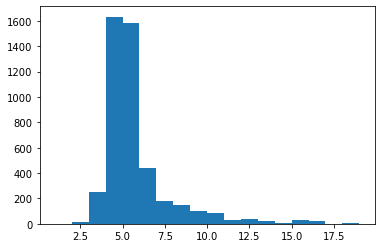

In [21]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [22]:
iters = simulate_robust(G, W, 5, range(N), 0, True, True, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 5    acc: 4.866666666666666                     
Result 15: 5    acc: 4.875                                 
Result 16: 4    acc: 4.823529411764706  

Result 136: 5    acc: 5.255474452554744                    
Result 137: 5    acc: 5.253623188405797                    
Result 138: 5    acc: 5.251798561151079                    
Result 139: 5    acc: 5.25                                 
Result 140: 6    acc: 5.25531914893617                     
Result 141: 6    acc: 5.26056338028169                     
Result 142: 6    acc: 5.265734265734266                    
Result 143: 5    acc: 5.263888888888889                    
Result 144: 5    acc: 5.2620689655172415                   
Result 145: 5    acc: 5.260273972602739                    
Result 146: 5    acc: 5.258503401360544                    
Result 147: 6    acc: 5.263513513513513                    
Result 148: 6    acc: 5.268456375838926                    
Result 149: 6    acc: 5.273333333333333                    
Result 150: 6    acc: 5.2781456953642385                   
Result 151: 5    acc: 5.276315789473684                    
Result 152: 5    acc: 5.2745098039215685

Result 273: 4    acc: 4.978102189781022                    
Result 274: 4    acc: 4.974545454545455                    
Result 275: 9    acc: 4.989130434782608                    
Result 276: 10    acc: 5.007220216606498                   
Result 277: 10    acc: 5.025179856115108                   
Result 278: 4    acc: 5.021505376344086                    
Result 279: 5    acc: 5.021428571428571                    
Result 280: 4    acc: 5.01779359430605                     
Result 281: 7    acc: 5.024822695035461                    
Result 282: 4    acc: 5.021201413427562                    
Result 283: 6    acc: 5.024647887323944                    
Result 284: 4    acc: 5.021052631578947                    
Result 285: 5    acc: 5.020979020979021                    
Result 286: 6    acc: 5.024390243902439                    
Result 287: 5    acc: 5.024305555555555                    
Result 288: 6    acc: 5.027681660899654                    
Result 289: 6    acc: 5.031034482758621 

Result 410: 3    acc: 5.092457420924574                    
Result 411: 3    acc: 5.087378640776699                    
Result 412: 5    acc: 5.087167070217918                    
Result 413: 6    acc: 5.0893719806763285                   
Result 414: 4    acc: 5.086746987951807                    
Result 415: 5    acc: 5.086538461538462                    
Result 416: 4    acc: 5.083932853717027                    
Result 417: 4    acc: 5.08133971291866                     
Result 418: 10    acc: 5.093078758949881                   
Result 419: 4    acc: 5.09047619047619                     
Result 420: 5    acc: 5.090261282660332                    
Result 421: 4    acc: 5.087677725118484                    
Result 422: 3    acc: 5.08274231678487                     
Result 423: 5    acc: 5.0825471698113205                   
Result 424: 6    acc: 5.084705882352941                    
Result 425: 5    acc: 5.084507042253521                    
Result 426: 4    acc: 5.081967213114754 

Result 548: 5    acc: 5.114754098360656                    
Result 549: 5    acc: 5.114545454545454                    
Result 550: 5    acc: 5.114337568058076                    
Result 551: 5    acc: 5.114130434782608                    
Result 552: 5    acc: 5.113924050632911                    
Result 553: 5    acc: 5.113718411552346                    
Result 554: 5    acc: 5.113513513513514                    
Result 555: 5    acc: 5.113309352517986                    
Result 556: 5    acc: 5.11310592459605                     
Result 557: 5    acc: 5.112903225806452                    
Result 558: 5    acc: 5.112701252236136                    
Result 559: 5    acc: 5.1125                               
Result 560: 5    acc: 5.112299465240642                    
Result 561: 5    acc: 5.112099644128114                    
Result 562: 5    acc: 5.11190053285968                     
Result 563: 4    acc: 5.109929078014185                    
Result 564: 5    acc: 5.109734513274336 

Result 684: 4    acc: 5.032116788321168                    
Result 685: 4    acc: 5.030612244897959                    
Result 686: 4    acc: 5.029112081513828                    
Result 687: 5    acc: 5.02906976744186                     
Result 688: 4    acc: 5.027576197387518                    
Result 689: 5    acc: 5.027536231884058                    
Result 690: 5    acc: 5.027496382054993                    
Result 691: 5    acc: 5.027456647398844                    
Result 692: 5    acc: 5.027417027417028                    
Result 693: 5    acc: 5.027377521613833                    
Result 694: 5    acc: 5.027338129496403                    
Result 695: 5    acc: 5.027298850574713                    
Result 696: 4    acc: 5.025824964131994                    
Result 697: 5    acc: 5.025787965616046                    
Result 698: 7    acc: 5.028612303290415                    
Result 699: 4    acc: 5.027142857142858                    
Result 700: 4    acc: 5.025677603423681 

Result 820: 5    acc: 5.02436053593179                     
Result 821: 5    acc: 5.024330900243309                    
Result 822: 5    acc: 5.024301336573512                    
Result 823: 4    acc: 5.023058252427185                    
Result 824: 4    acc: 5.0218181818181815                   
Result 825: 5    acc: 5.021791767554479                    
Result 826: 5    acc: 5.021765417170496                    
Result 827: 5    acc: 5.021739130434782                    
Result 828: 4    acc: 5.020506634499397                    
Result 829: 6    acc: 5.021686746987951                    
Result 830: 4    acc: 5.020457280385078                    
Result 831: 4    acc: 5.019230769230769                    
Result 832: 4    acc: 5.018007202881153                    
Result 833: 4    acc: 5.016786570743405                    
Result 834: 4    acc: 5.015568862275449                    
Result 835: 4    acc: 5.014354066985646                    
Result 836: 4    acc: 5.013142174432497 

Result 957: 4    acc: 4.964509394572025                    
Result 958: 4    acc: 4.963503649635037                    
Result 959: 4    acc: 4.9625                               
Result 960: 4    acc: 4.9614984391259105                   
Result 961: 4    acc: 4.960498960498961                    
Result 962: 4    acc: 4.959501557632398                    
Result 963: 4    acc: 4.95850622406639                     
Result 964: 4    acc: 4.957512953367876                    
Result 965: 4    acc: 4.956521739130435                    
Result 966: 4    acc: 4.955532574974147                    
Result 967: 4    acc: 4.954545454545454                    
Result 968: 4    acc: 4.953560371517028                    
Result 969: 5    acc: 4.953608247422681                    
Result 970: 4    acc: 4.952626158599382                    
Result 971: 4    acc: 4.95164609053498                     
Result 972: 6    acc: 4.9527235354573484                   
Result 973: 6    acc: 4.953798767967146 

Result 1093: 5    acc: 4.937842778793419                   
Result 1094: 5    acc: 4.937899543378996                   
Result 1095: 4    acc: 4.937043795620438                   
Result 1096: 4    acc: 4.936189608021878                   
Result 1097: 4    acc: 4.935336976320583                   
Result 1098: 4    acc: 4.934485896269336                   
Result 1099: 4    acc: 4.933636363636364                   
Result 1100: 4    acc: 4.932788374205268                   
Result 1101: 7    acc: 4.9346642468239565                  
Result 1102: 3    acc: 4.932910244786945                   
Result 1103: 8    acc: 4.9356884057971016                  
Result 1104: 8    acc: 4.938461538461539                   
Result 1105: 4    acc: 4.937613019891501                   
Result 1106: 4    acc: 4.93676603432701                    
Result 1107: 5    acc: 4.936823104693141                   
Result 1108: 5    acc: 4.93688007213706                    
Result 1109: 4    acc: 4.936036036036036

Result 1229: 6    acc: 4.894308943089431                   
Result 1230: 5    acc: 4.894394800974817                   
Result 1231: 5    acc: 4.89448051948052                    
Result 1232: 5    acc: 4.894566098945661                   
Result 1233: 5    acc: 4.894651539708266                   
Result 1234: 5    acc: 4.894736842105263                   
Result 1235: 5    acc: 4.894822006472492                   
Result 1236: 5    acc: 4.894907033144705                   
Result 1237: 5    acc: 4.894991922455573                   
Result 1238: 5    acc: 4.895076674737692                   
Result 1239: 6    acc: 4.8959677419354835                  
Result 1240: 5    acc: 4.896051571313457                   
Result 1241: 5    acc: 4.896135265700483                   
Result 1242: 4    acc: 4.8954143201930815                  
Result 1243: 4    acc: 4.894694533762058                   
Result 1244: 5    acc: 4.894779116465863                   
Result 1245: 4    acc: 4.89406099518459 

Result 1367: 6    acc: 4.873538011695906                   
Result 1368: 6    acc: 4.87436084733382                    
Result 1369: 6    acc: 4.875182481751825                   
Result 1370: 6    acc: 4.87600291757841                    
Result 1371: 6    acc: 4.876822157434402                   
Result 1372: 6    acc: 4.877640203932994                   
Result 1373: 6    acc: 4.878457059679767                   
Result 1374: 5    acc: 4.8785454545454545                  
Result 1375: 5    acc: 4.878633720930233                   
Result 1376: 4    acc: 4.877995642701525                   
Result 1377: 5    acc: 4.878084179970973                   
Result 1378: 5    acc: 4.878172588832487                   
Result 1379: 5    acc: 4.878260869565217                   
Result 1380: 5    acc: 4.878349022447502                   
Result 1381: 5    acc: 4.878437047756874                   
Result 1382: 5    acc: 4.8785249457700655                  
Result 1383: 5    acc: 4.878612716763006

Result 1504: 4    acc: 4.8631229235880395                  
Result 1505: 5    acc: 4.863213811420983                   
Result 1506: 5    acc: 4.863304578633046                   
Result 1507: 5    acc: 4.863395225464191                   
Result 1508: 5    acc: 4.8634857521537445                  
Result 1509: 5    acc: 4.863576158940397                   
Result 1510: 4    acc: 4.86300463269358                    
Result 1511: 4    acc: 4.862433862433862                   
Result 1512: 5    acc: 4.862524785194977                   
Result 1513: 5    acc: 4.862615587846763                   
Result 1514: 5    acc: 4.862706270627062                   
Result 1515: 5    acc: 4.862796833773087                   
Result 1516: 5    acc: 4.862887277521424                   
Result 1517: 5    acc: 4.862977602108037                   
Result 1518: 5    acc: 4.863067807768268                   
Result 1519: 5    acc: 4.863157894736842                   
Result 1520: 5    acc: 4.863247863247863

Result 1642: 3    acc: 4.878271454656117                   
Result 1643: 5    acc: 4.878345498783455                   
Result 1644: 5    acc: 4.878419452887538                   
Result 1645: 7    acc: 4.879708383961118                   
Result 1646: 5    acc: 4.879781420765028                   
Result 1647: 7    acc: 4.881067961165049                   
Result 1648: 7    acc: 4.882352941176471                   
Result 1649: 6    acc: 4.883030303030303                   
Result 1650: 5    acc: 4.883101150817686                   
Result 1651: 5    acc: 4.88317191283293                    
Result 1652: 5    acc: 4.8832425892317                     
Result 1653: 5    acc: 4.883313180169287                   
Result 1654: 5    acc: 4.883383685800604                   
Result 1655: 7    acc: 4.884661835748792                   
Result 1656: 5    acc: 4.884731442365721                   
Result 1657: 5    acc: 4.884800965018094                   
Result 1658: 5    acc: 4.884870403857746

Result 1781: 4    acc: 4.866442199775533                   
Result 1782: 5    acc: 4.866517106001122                   
Result 1783: 5    acc: 4.866591928251121                   
Result 1784: 5    acc: 4.866666666666666                   
Result 1785: 5    acc: 4.866741321388578                   
Result 1786: 5    acc: 4.866815892557359                   
Result 1787: 5    acc: 4.866890380313199                   
Result 1788: 5    acc: 4.866964784795975                   
Result 1789: 4    acc: 4.866480446927374                   
Result 1790: 4    acc: 4.865996649916248                   
Result 1791: 4    acc: 4.865513392857143                   
Result 1792: 4    acc: 4.865030674846626                   
Result 1793: 4    acc: 4.864548494983278                   
Result 1794: 6    acc: 4.865181058495822                   
Result 1795: 6    acc: 4.8658129175946545                  
Result 1796: 3    acc: 4.864774624373957                   
Result 1797: 4    acc: 4.864293659621802

Result 1919: 5    acc: 4.85                                
Result 1920: 5    acc: 4.850078084331077                   
Result 1921: 5    acc: 4.850156087408949                   
Result 1922: 5    acc: 4.850234009360374                   
Result 1923: 4    acc: 4.8497920997921                     
Result 1924: 4    acc: 4.849350649350649                   
Result 1925: 4    acc: 4.848909657320872                   
Result 1926: 4    acc: 4.848469122989102                   
Result 1927: 4    acc: 4.848029045643154                   
Result 1928: 4    acc: 4.847589424572317                   
Result 1929: 4    acc: 4.847150259067358                   
Result 1930: 4    acc: 4.846711548420507                   
Result 1931: 4    acc: 4.846273291925466                   
Result 1932: 4    acc: 4.845835488877393                   
Result 1933: 4    acc: 4.8453981385729055                  
Result 1934: 4    acc: 4.844961240310077                   
Result 1935: 6    acc: 4.845557851239669

Result 2055: 10    acc: 4.832684824902723                  
Result 2056: 3    acc: 4.831793874574624                   
Result 2057: 5    acc: 4.831875607385811                   
Result 2058: 6    acc: 4.832442933462846                   
Result 2059: 6    acc: 4.8330097087378645                  
Result 2060: 4    acc: 4.832605531295488                   
Result 2061: 4    acc: 4.832201745877788                   
Result 2062: 6    acc: 4.832767813863306                   
Result 2063: 6    acc: 4.833333333333333                   
Result 2064: 6    acc: 4.8338983050847455                  
Result 2065: 6    acc: 4.834462729912875                   
Result 2066: 6    acc: 4.835026608611514                   
Result 2067: 6    acc: 4.835589941972921                   
Result 2068: 6    acc: 4.83615273078782                    
Result 2069: 5    acc: 4.836231884057971                   
Result 2070: 5    acc: 4.83631096088846                    
Result 2071: 5    acc: 4.836389961389961

Result 2192: 5    acc: 4.797993616051071                   
Result 2193: 5    acc: 4.798085688240656                   
Result 2194: 5    acc: 4.798177676537585                   
Result 2195: 5    acc: 4.798269581056466                   
Result 2196: 5    acc: 4.798361401911698                   
Result 2197: 5    acc: 4.798453139217471                   
Result 2198: 5    acc: 4.798544793087768                   
Result 2199: 5    acc: 4.798636363636364                   
Result 2200: 5    acc: 4.798727850976829                   
Result 2201: 5    acc: 4.798819255222525                   
Result 2202: 5    acc: 4.798910576486609                   
Result 2203: 5    acc: 4.799001814882033                   
Result 2204: 5    acc: 4.799092970521542                   
Result 2205: 5    acc: 4.799184043517679                   
Result 2206: 5    acc: 4.799275033982782                   
Result 2207: 5    acc: 4.799365942028985                   
Result 2208: 5    acc: 4.799456767768221

Result 2328: 4    acc: 4.792614856161443                   
Result 2329: 4    acc: 4.792274678111588                   
Result 2330: 4    acc: 4.791934791934792                   
Result 2331: 4    acc: 4.791595197255575                   
Result 2332: 4    acc: 4.7912558936991                     
Result 2333: 4    acc: 4.7909168808911735                  
Result 2334: 6    acc: 4.791434689507494                   
Result 2335: 6    acc: 4.79195205479452                    
Result 2336: 4    acc: 4.791613179289688                   
Result 2337: 4    acc: 4.791274593669804                   
Result 2338: 4    acc: 4.790936297563061                   
Result 2339: 4    acc: 4.7905982905982905                  
Result 2340: 4    acc: 4.790260572404955                   
Result 2341: 4    acc: 4.789923142613151                   
Result 2342: 4    acc: 4.789586000853607                   
Result 2343: 4    acc: 4.789249146757679                   
Result 2344: 4    acc: 4.788912579957356

Result 2466: 4    acc: 4.837454398054317                   
Result 2467: 4    acc: 4.83711507293355                    
Result 2468: 4    acc: 4.8367760226812475                  
Result 2469: 4    acc: 4.836437246963563                   
Result 2470: 4    acc: 4.836098745447187                   
Result 2471: 4    acc: 4.835760517799352                   
Result 2472: 4    acc: 4.835422563687828                   
Result 2473: 4    acc: 4.835084882780921                   
Result 2474: 4    acc: 4.834747474747474                   
Result 2475: 4    acc: 4.834410339256866                   
Result 2476: 4    acc: 4.8340734759790065                  
Result 2477: 4    acc: 4.833736884584342                   
Result 2478: 4    acc: 4.833400564743848                   
Result 2479: 4    acc: 4.833064516129032                   
Result 2480: 6    acc: 4.833534864973801                   
Result 2481: 6    acc: 4.834004834810637                   
Result 2482: 6    acc: 4.834474426097462

Result 2602: 5    acc: 4.823280829811756                   
Result 2603: 5    acc: 4.8233486943164365                  
Result 2604: 4    acc: 4.823032629558541                   
Result 2605: 5    acc: 4.823100537221796                   
Result 2606: 5    acc: 4.823168392788646                   
Result 2607: 5    acc: 4.8232361963190185                  
Result 2608: 5    acc: 4.823303947872748                   
Result 2609: 5    acc: 4.823371647509578                   
Result 2610: 5    acc: 4.823439295289162                   
Result 2611: 5    acc: 4.823506891271057                   
Result 2612: 5    acc: 4.823574435514734                   
Result 2613: 6    acc: 4.824024483550115                   
Result 2614: 8    acc: 4.825239005736138                   
Result 2615: 7    acc: 4.826070336391437                   
Result 2616: 7    acc: 4.826901031715705                   
Result 2617: 8    acc: 4.828113063407181                   
Result 2618: 8    acc: 4.829324169530355

Result 2740: 4    acc: 4.841298796059832                   
Result 2741: 6    acc: 4.841721371261853                   
Result 2742: 6    acc: 4.842143638352169                   
Result 2743: 4    acc: 4.841836734693878                   
Result 2744: 5    acc: 4.841894353369764                   
Result 2745: 4    acc: 4.841587764020393                   
Result 2746: 5    acc: 4.841645431379687                   
Result 2747: 5    acc: 4.841703056768559                   
Result 2748: 5    acc: 4.8417606402328115                  
Result 2749: 5    acc: 4.841818181818182                   
Result 2750: 5    acc: 4.841875681570338                   
Result 2751: 9    acc: 4.843386627906977                   
Result 2752: 8    acc: 4.844533236469307                   
Result 2753: 8    acc: 4.845679012345679                   
Result 2754: 5    acc: 4.84573502722323                    
Result 2755: 8    acc: 4.846879535558781                   
Result 2756: 8    acc: 4.848023213638013

Result 2878: 4    acc: 4.863494268843349                   
Result 2879: 8    acc: 4.864583333333333                   
Result 2880: 8    acc: 4.865671641791045                   
Result 2881: 8    acc: 4.866759195003469                   
Result 2882: 8    acc: 4.867845993756504                   
Result 2883: 8    acc: 4.868932038834951                   
Result 2884: 8    acc: 4.87001733102253                    
Result 2885: 8    acc: 4.871101871101871                   
Result 2886: 8    acc: 4.87218565985452                    
Result 2887: 8    acc: 4.873268698060942                   
Result 2888: 8    acc: 4.874350986500519                   
Result 2889: 8    acc: 4.875432525951557                   
Result 2890: 8    acc: 4.876513317191283                   
Result 2891: 8    acc: 4.877593360995851                   
Result 2892: 8    acc: 4.878672658140339                   
Result 2893: 8    acc: 4.879751209398756                   
Result 2894: 8    acc: 4.880829015544041

Result 3016: 4    acc: 4.866092144514418                   
Result 3017: 5    acc: 4.866136514247846                   
Result 3018: 5    acc: 4.866180854587612                   
Result 3019: 5    acc: 4.866225165562914                   
Result 3020: 5    acc: 4.866269447202913                   
Result 3021: 5    acc: 4.866313699536731                   
Result 3022: 5    acc: 4.86635792259345                    
Result 3023: 5    acc: 4.866402116402116                   
Result 3024: 5    acc: 4.8664462809917355                  
Result 3025: 5    acc: 4.866490416391276                   
Result 3026: 5    acc: 4.866534522629666                   
Result 3027: 5    acc: 4.866578599735799                   
Result 3028: 5    acc: 4.866622647738527                   
Result 3029: 5    acc: 4.866666666666666                   
Result 3030: 5    acc: 4.866710656548994                   
Result 3031: 5    acc: 4.866754617414248                   
Result 3032: 5    acc: 4.866798549291131

Result 3153: 9    acc: 4.930881420418516                   
Result 3154: 9    acc: 4.932171156893819                   
Result 3155: 8    acc: 4.933143219264892                   
Result 3156: 4    acc: 4.932847640164713                   
Result 3157: 4    acc: 4.932552248258391                   
Result 3158: 4    acc: 4.932257043368154                   
Result 3159: 4    acc: 4.931962025316456                   
Result 3160: 4    acc: 4.931667193925973                   
Result 3161: 5    acc: 4.93168880455408                    
Result 3162: 5    acc: 4.931710401517547                   
Result 3163: 5    acc: 4.93173198482933                    
Result 3164: 5    acc: 4.93175355450237                    
Result 3165: 4    acc: 4.931459254579911                   
Result 3166: 5    acc: 4.93148089674771                    
Result 3167: 4    acc: 4.9311868686868685                  
Result 3168: 4    acc: 4.930893026191227                   
Result 3169: 5    acc: 4.930914826498423

Result 3289: 6    acc: 4.948024316109422                   
Result 3290: 7    acc: 4.948647827408083                   
Result 3291: 6    acc: 4.948967193195625                   
Result 3292: 7    acc: 4.9495900394776795                  
Result 3293: 6    acc: 4.949908925318762                   
Result 3294: 7    acc: 4.950531107738999                   
Result 3295: 7    acc: 4.951152912621359                   
Result 3296: 7    acc: 4.951774340309372                   
Result 3297: 7    acc: 4.952395391146149                   
Result 3298: 7    acc: 4.953016065474386                   
Result 3299: 7    acc: 4.953636363636364                   
Result 3300: 7    acc: 4.954256285973948                   
Result 3301: 7    acc: 4.954875832828589                   
Result 3302: 7    acc: 4.955495004541326                   
Result 3303: 7    acc: 4.956113801452784                   
Result 3304: 7    acc: 4.956732223903177                   
Result 3305: 7    acc: 4.957350272232305

Result 3426: 4    acc: 5.024803034724249                   
Result 3427: 6    acc: 5.025087514585764                   
Result 3428: 6    acc: 5.025371828521434                   
Result 3429: 5    acc: 5.025364431486881                   
Result 3430: 5    acc: 5.025357038764208                   
Result 3431: 5    acc: 5.02534965034965                    
Result 3432: 8    acc: 5.026216137489077                   
Result 3433: 5    acc: 5.026208503203262                   
Result 3434: 5    acc: 5.026200873362446                   
Result 3435: 5    acc: 5.026193247962747                   
Result 3436: 5    acc: 5.026185627000291                   
Result 3437: 6    acc: 5.026468877254217                   
Result 3438: 6    acc: 5.026751962779878                   
Result 3439: 5    acc: 5.026744186046511                   
Result 3440: 5    acc: 5.026736413833188                   
Result 3441: 5    acc: 5.026728646135967                   
Result 3442: 5    acc: 5.026720882950915

Result 3563: 4    acc: 5.04320987654321                    
Result 3564: 5    acc: 5.04319775596073                    
Result 3565: 6    acc: 5.043466068424005                   
Result 3566: 8    acc: 5.044294925707878                   
Result 3567: 8    acc: 5.0451233183856505                  
Result 3568: 8    acc: 5.0459512468478565                  
Result 3569: 6    acc: 5.046218487394958                   
Result 3570: 6    acc: 5.046485578269392                   
Result 3571: 5    acc: 5.046472564389697                   
Result 3572: 6    acc: 5.046739434648755                   
Result 3573: 6    acc: 5.047006155567991                   
Result 3574: 6    acc: 5.047272727272727                   
Result 3575: 6    acc: 5.047539149888143                   
Result 3576: 6    acc: 5.047805423539279                   
Result 3577: 5    acc: 5.047792062604807                   
Result 3578: 6    acc: 5.0480581167924                     
Result 3579: 6    acc: 5.048324022346368

Result 3700: 3    acc: 5.054579843285598                   
Result 3701: 3    acc: 5.054024851431659                   
Result 3702: 5    acc: 5.05401026194977                    
Result 3703: 5    acc: 5.053995680345572                   
Result 3704: 4    acc: 5.053711201079622                   
Result 3705: 4    acc: 5.053426875337291                   
Result 3706: 4    acc: 5.053142702994335                   
Result 3707: 4    acc: 5.052858683926645                   
Result 3708: 4    acc: 5.052574818010245                   
Result 3709: 4    acc: 5.052291105121294                   
Result 3710: 4    acc: 5.052007545136082                   
Result 3711: 4    acc: 5.051724137931035                   
Result 3712: 4    acc: 5.05144088338271                    
Result 3713: 4    acc: 5.051157781367798                   
Result 3714: 4    acc: 5.050874831763123                   
Result 3715: 4    acc: 5.05059203444564                    
Result 3716: 4    acc: 5.05030938929244 

Result 3836: 5    acc: 5.048475371383893                   
Result 3837: 5    acc: 5.048462741010943                   
Result 3838: 5    acc: 5.048450117218025                   
Result 3839: 5    acc: 5.0484375                           
Result 3840: 5    acc: 5.048424889351732                   
Result 3841: 5    acc: 5.04841228526809                    
Result 3842: 4    acc: 5.048139474368982                   
Result 3843: 8    acc: 5.048907388137357                   
Result 3844: 4    acc: 5.048634590377113                   
Result 3845: 4    acc: 5.048361934477379                   
Result 3846: 4    acc: 5.048089420327528                   
Result 3847: 4    acc: 5.047817047817047                   
Result 3848: 5    acc: 5.047804624577813                   
Result 3849: 4    acc: 5.047532467532467                   
Result 3850: 4    acc: 5.047260451830693                   
Result 3851: 8    acc: 5.0480269989615785                  
Result 3852: 8    acc: 5.048793148196211

Result 3973: 6    acc: 5.064418721690991                   
Result 3974: 6    acc: 5.064654088050315                   
Result 3975: 6    acc: 5.064889336016097                   
Result 3976: 6    acc: 5.065124465677647                   
Result 3977: 5    acc: 5.065108094519859                   
Result 3978: 5    acc: 5.065091731590852                   
Result 3979: 6    acc: 5.065326633165829                   
Result 3980: 5    acc: 5.065310223561919                   
Result 3981: 5    acc: 5.0652938221999                     
Result 3982: 5    acc: 5.0652774290735625                  
Result 3983: 5    acc: 5.065261044176707                   
Result 3984: 5    acc: 5.065244667503137                   
Result 3985: 5    acc: 5.065228299046663                   
Result 3986: 5    acc: 5.065211938801103                   
Result 3987: 5    acc: 5.0651955867602805                  
Result 3988: 5    acc: 5.065179242918025                   
Result 3989: 6    acc: 5.065413533834587

Result 4109: 8    acc: 5.069343065693431                   
Result 4110: 4    acc: 5.069082948187789                   
Result 4111: 5    acc: 5.069066147859922                   
Result 4112: 5    acc: 5.069049355701434                   
Result 4113: 5    acc: 5.0690325717063685                  
Result 4114: 5    acc: 5.069015795868773                   
Result 4115: 5    acc: 5.068999028182701                   
Result 4116: 7    acc: 5.069468059266456                   
Result 4117: 4    acc: 5.069208353569694                   
Result 4118: 4    acc: 5.068948773974266                   
Result 4119: 4    acc: 5.06868932038835                    
Result 4120: 4    acc: 5.068429992720214                   
Result 4121: 4    acc: 5.068170790878215                   
Result 4122: 4    acc: 5.067911714770798                   
Result 4123: 5    acc: 5.067895247332687                   
Result 4124: 8    acc: 5.068606060606061                   
Result 4125: 5    acc: 5.06858943286476 

Result 4245: 6    acc: 5.074894017899199                   
Result 4246: 6    acc: 5.075111843654344                   
Result 4247: 6    acc: 5.0753295668549905                  
Result 4248: 7    acc: 5.075782537067545                   
Result 4249: 6    acc: 5.076                               
Result 4250: 8    acc: 5.076687838155728                   
Result 4251: 5    acc: 5.076669802445908                   
Result 4252: 4    acc: 5.076416647072654                   
Result 4253: 5    acc: 5.076398683591914                   
Result 4254: 6    acc: 5.076615746180964                   
Result 4255: 5    acc: 5.076597744360902                   
Result 4256: 5    acc: 5.076579750998356                   
Result 4257: 4    acc: 5.076326914044152                   
Result 4258: 4    acc: 5.076074195820615                   
Result 4259: 4    acc: 5.075821596244132                   
Result 4260: 4    acc: 5.075569115231167                   
Result 4261: 7    acc: 5.076020647583294

Result 4381: 5    acc: 5.103833865814696                   
Result 4382: 5    acc: 5.103810175678759                   
Result 4383: 5    acc: 5.103786496350365                   
Result 4384: 6    acc: 5.103990877993159                   
Result 4385: 6    acc: 5.104195166438669                   
Result 4386: 6    acc: 5.104399361750627                   
Result 4387: 6    acc: 5.104603463992707                   
Result 4388: 6    acc: 5.104807473228526                   
Result 4389: 5    acc: 5.104783599088838                   
Result 4390: 5    acc: 5.104759735823275                   
Result 4391: 5    acc: 5.104735883424408                   
Result 4392: 5    acc: 5.104712041884817                   
Result 4393: 4    acc: 5.104460628129267                   
Result 4394: 5    acc: 5.104436860068259                   
Result 4395: 5    acc: 5.104413102820746                   
Result 4396: 5    acc: 5.104389356379349                   
Result 4397: 4    acc: 5.104138244656662

Result 4519: 6    acc: 5.094469026548673                   
Result 4520: 6    acc: 5.094669320946693                   
Result 4521: 6    acc: 5.094869526758072                   
Result 4522: 6    acc: 5.0950696440415655                  
Result 4523: 6    acc: 5.0952696728558795                  
Result 4524: 6    acc: 5.095469613259668                   
Result 4525: 6    acc: 5.095669465311533                   
Result 4526: 6    acc: 5.095869229070025                   
Result 4527: 6    acc: 5.09606890459364                    
Result 4528: 6    acc: 5.096268491940826                   
Result 4529: 6    acc: 5.096467991169978                   
Result 4530: 6    acc: 5.096667402339439                   
Result 4531: 6    acc: 5.096866725507502                   
Result 4532: 6    acc: 5.097065960732407                   
Result 4533: 6    acc: 5.097265108072342                   
Result 4534: 6    acc: 5.097464167585446                   
Result 4535: 6    acc: 5.097663139329806

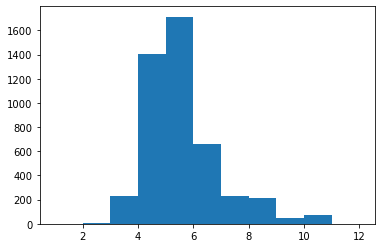

In [23]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [24]:
iters = simulate_robust(G, W, 5, range(N), 0.4, True, True, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 4    acc: 4.8                                   
Result 15: 5    acc: 4.8125                                
Result 16: 5    acc: 4.823529411764706  

Result 136: 5    acc: 5.182481751824818                    
Result 137: 5    acc: 5.181159420289855                    
Result 138: 5    acc: 5.179856115107913                    
Result 139: 5    acc: 5.178571428571429                    
Result 140: 6    acc: 5.184397163120567                    
Result 141: 6    acc: 5.190140845070423                    
Result 142: 6    acc: 5.195804195804196                    
Result 143: 5    acc: 5.194444444444445                    
Result 144: 5    acc: 5.1931034482758625                   
Result 145: 5    acc: 5.191780821917808                    
Result 146: 5    acc: 5.190476190476191                    
Result 147: 6    acc: 5.195945945945946                    
Result 148: 6    acc: 5.201342281879195                    
Result 149: 6    acc: 5.206666666666667                    
Result 150: 6    acc: 5.211920529801325                    
Result 151: 5    acc: 5.2105263157894735                   
Result 152: 5    acc: 5.209150326797386 

Result 273: 4    acc: 4.95985401459854                     
Result 274: 4    acc: 4.956363636363636                    
Result 275: 9    acc: 4.971014492753623                    
Result 276: 9    acc: 4.985559566787003                    
Result 277: 9    acc: 5.0                                  
Result 278: 6    acc: 5.003584229390681                    
Result 279: 5    acc: 5.003571428571429                    
Result 280: 4    acc: 5.0                                  
Result 281: 7    acc: 5.00709219858156                     
Result 282: 3    acc: 5.0                                  
Result 283: 6    acc: 5.003521126760563                    
Result 284: 4    acc: 5.0                                  
Result 285: 5    acc: 5.0                                  
Result 286: 5    acc: 5.0                                  
Result 287: 7    acc: 5.006944444444445                    
Result 288: 6    acc: 5.010380622837371                    
Result 289: 6    acc: 5.0137931034482754

Result 410: 3    acc: 5.099756690997567                    
Result 411: 3    acc: 5.094660194174757                    
Result 412: 5    acc: 5.094430992736077                    
Result 413: 6    acc: 5.096618357487923                    
Result 414: 4    acc: 5.093975903614457                    
Result 415: 5    acc: 5.09375                              
Result 416: 4    acc: 5.091127098321343                    
Result 417: 4    acc: 5.088516746411483                    
Result 418: 9    acc: 5.097852028639618                    
Result 419: 4    acc: 5.095238095238095                    
Result 420: 5    acc: 5.095011876484561                    
Result 421: 4    acc: 5.092417061611374                    
Result 422: 3    acc: 5.087470449172577                    
Result 423: 6    acc: 5.089622641509434                    
Result 424: 6    acc: 5.091764705882353                    
Result 425: 5    acc: 5.091549295774648                    
Result 426: 4    acc: 5.0889929742388755

Result 548: 5    acc: 5.120218579234972                    
Result 549: 5    acc: 5.12                                 
Result 550: 5    acc: 5.11978221415608                     
Result 551: 5    acc: 5.119565217391305                    
Result 552: 5    acc: 5.119349005424954                    
Result 553: 5    acc: 5.11913357400722                     
Result 554: 5    acc: 5.118918918918919                    
Result 555: 5    acc: 5.118705035971223                    
Result 556: 5    acc: 5.118491921005386                    
Result 557: 5    acc: 5.118279569892473                    
Result 558: 5    acc: 5.1180679785330945                   
Result 559: 5    acc: 5.117857142857143                    
Result 560: 5    acc: 5.117647058823529                    
Result 561: 5    acc: 5.117437722419929                    
Result 562: 5    acc: 5.1172291296625225                   
Result 563: 4    acc: 5.115248226950355                    
Result 564: 5    acc: 5.115044247787611 

Result 684: 4    acc: 5.054014598540146                    
Result 685: 4    acc: 5.052478134110787                    
Result 686: 4    acc: 5.0509461426492                      
Result 687: 5    acc: 5.050872093023256                    
Result 688: 4    acc: 5.049346879535559                    
Result 689: 5    acc: 5.04927536231884                     
Result 690: 5    acc: 5.049204052098408                    
Result 691: 5    acc: 5.0491329479768785                   
Result 692: 5    acc: 5.049062049062049                    
Result 693: 5    acc: 5.0489913544668585                   
Result 694: 5    acc: 5.048920863309353                    
Result 695: 5    acc: 5.0488505747126435                   
Result 696: 4    acc: 5.047345767575322                    
Result 697: 5    acc: 5.04727793696275                     
Result 698: 7    acc: 5.050071530758226                    
Result 699: 4    acc: 5.048571428571429                    
Result 700: 4    acc: 5.0470756062767475

Result 820: 5    acc: 5.032886723507917                    
Result 821: 5    acc: 5.032846715328467                    
Result 822: 5    acc: 5.032806804374241                    
Result 823: 4    acc: 5.031553398058253                    
Result 824: 4    acc: 5.03030303030303                     
Result 825: 5    acc: 5.030266343825666                    
Result 826: 5    acc: 5.030229746070133                    
Result 827: 5    acc: 5.030193236714976                    
Result 828: 4    acc: 5.0289505428226775                   
Result 829: 6    acc: 5.030120481927711                    
Result 830: 4    acc: 5.028880866425993                    
Result 831: 4    acc: 5.027644230769231                    
Result 832: 4    acc: 5.02641056422569                     
Result 833: 4    acc: 5.025179856115108                    
Result 834: 4    acc: 5.023952095808383                    
Result 835: 4    acc: 5.0227272727272725                   
Result 836: 4    acc: 5.021505376344086 

Result 958: 4    acc: 4.978102189781022                    
Result 959: 4    acc: 4.977083333333334                    
Result 960: 4    acc: 4.976066597294485                    
Result 961: 4    acc: 4.975051975051975                    
Result 962: 4    acc: 4.9740394600207685                   
Result 963: 4    acc: 4.973029045643154                    
Result 964: 4    acc: 4.972020725388601                    
Result 965: 4    acc: 4.971014492753623                    
Result 966: 4    acc: 4.970010341261634                    
Result 967: 4    acc: 4.9690082644628095                   
Result 968: 4    acc: 4.9680082559339525                   
Result 969: 5    acc: 4.968041237113402                    
Result 970: 4    acc: 4.967044284243048                    
Result 971: 4    acc: 4.966049382716049                    
Result 972: 6    acc: 4.9671120246659815                   
Result 973: 6    acc: 4.968172484599589                    
Result 974: 6    acc: 4.969230769230769 

Result 1096: 4    acc: 4.951686417502279                   
Result 1097: 4    acc: 4.950819672131147                   
Result 1098: 4    acc: 4.949954504094632                   
Result 1099: 4    acc: 4.949090909090909                   
Result 1100: 4    acc: 4.948228882833788                   
Result 1101: 4    acc: 4.947368421052632                   
Result 1102: 3    acc: 4.945602901178604                   
Result 1103: 10    acc: 4.95018115942029                   
Result 1104: 10    acc: 4.95475113122172                   
Result 1105: 4    acc: 4.9538878842676315                  
Result 1106: 4    acc: 4.9530261969286355                  
Result 1107: 5    acc: 4.953068592057762                   
Result 1108: 5    acc: 4.953110910730388                   
Result 1109: 4    acc: 4.9522522522522525                  
Result 1110: 4    acc: 4.951395139513951                   
Result 1111: 4    acc: 4.950539568345324                   
Result 1112: 6    acc: 4.951482479784366

Result 1232: 5    acc: 4.909975669099757                   
Result 1233: 5    acc: 4.910048622366289                   
Result 1234: 5    acc: 4.910121457489878                   
Result 1235: 5    acc: 4.910194174757281                   
Result 1236: 5    acc: 4.910266774454325                   
Result 1237: 5    acc: 4.910339256865913                   
Result 1238: 5    acc: 4.910411622276029                   
Result 1239: 5    acc: 4.910483870967742                   
Result 1240: 5    acc: 4.910556003223207                   
Result 1241: 5    acc: 4.9106280193236715                  
Result 1242: 4    acc: 4.909895414320193                   
Result 1243: 4    acc: 4.909163987138264                   
Result 1244: 5    acc: 4.909236947791165                   
Result 1245: 4    acc: 4.908507223113965                   
Result 1246: 4    acc: 4.907778668805133                   
Result 1247: 4    acc: 4.907051282051282                   
Result 1248: 5    acc: 4.907125700560448

Result 1369: 6    acc: 4.887591240875913                   
Result 1370: 6    acc: 4.888402625820569                   
Result 1371: 6    acc: 4.889212827988338                   
Result 1372: 6    acc: 4.890021849963583                   
Result 1373: 6    acc: 4.890829694323144                   
Result 1374: 5    acc: 4.890909090909091                   
Result 1375: 5    acc: 4.890988372093023                   
Result 1376: 4    acc: 4.890341321713871                   
Result 1377: 5    acc: 4.890420899854862                   
Result 1378: 5    acc: 4.890500362581581                   
Result 1379: 5    acc: 4.8905797101449275                  
Result 1380: 5    acc: 4.890658942795076                   
Result 1381: 5    acc: 4.8907380607814765                  
Result 1382: 5    acc: 4.890817064352856                   
Result 1383: 5    acc: 4.890895953757226                   
Result 1384: 5    acc: 4.8909747292418775                  
Result 1385: 5    acc: 4.891053391053391

Result 1505: 5    acc: 4.869853917662683                   
Result 1506: 5    acc: 4.869940278699403                   
Result 1507: 5    acc: 4.870026525198939                   
Result 1508: 5    acc: 4.870112657388999                   
Result 1509: 5    acc: 4.870198675496689                   
Result 1510: 4    acc: 4.869622766379881                   
Result 1511: 4    acc: 4.869047619047619                   
Result 1512: 5    acc: 4.869134170522141                   
Result 1513: 5    acc: 4.869220607661823                   
Result 1514: 5    acc: 4.869306930693069                   
Result 1515: 5    acc: 4.869393139841689                   
Result 1516: 5    acc: 4.869479235332894                   
Result 1517: 5    acc: 4.869565217391305                   
Result 1518: 5    acc: 4.869651086240948                   
Result 1519: 5    acc: 4.869736842105263                   
Result 1520: 5    acc: 4.8698224852071                     
Result 1521: 5    acc: 4.869908015768726

Result 1643: 5    acc: 4.894768856447689                   
Result 1644: 5    acc: 4.89483282674772                    
Result 1645: 6    acc: 4.8955042527339                     
Result 1646: 5    acc: 4.895567698846388                   
Result 1647: 7    acc: 4.896844660194175                   
Result 1648: 7    acc: 4.898120072771377                   
Result 1649: 6    acc: 4.8987878787878785                  
Result 1650: 5    acc: 4.898849182313749                   
Result 1651: 5    acc: 4.898910411622276                   
Result 1652: 5    acc: 4.898971566848155                   
Result 1653: 5    acc: 4.899032648125756                   
Result 1654: 5    acc: 4.899093655589124                   
Result 1655: 7    acc: 4.90036231884058                    
Result 1656: 5    acc: 4.9004224502112255                  
Result 1657: 5    acc: 4.900482509047045                   
Result 1658: 5    acc: 4.900542495479204                   
Result 1659: 5    acc: 4.900602409638554

Result 1780: 4    acc: 4.880404267265581                   
Result 1781: 4    acc: 4.879910213243547                   
Result 1782: 5    acc: 4.879977565900168                   
Result 1783: 5    acc: 4.880044843049327                   
Result 1784: 5    acc: 4.880112044817928                   
Result 1785: 5    acc: 4.880179171332586                   
Result 1786: 5    acc: 4.8802462227196415                  
Result 1787: 5    acc: 4.880313199105146                   
Result 1788: 5    acc: 4.880380100614869                   
Result 1789: 4    acc: 4.879888268156424                   
Result 1790: 4    acc: 4.8793969849246235                  
Result 1791: 4    acc: 4.87890625                          
Result 1792: 4    acc: 4.878416062465142                   
Result 1793: 4    acc: 4.877926421404682                   
Result 1794: 5    acc: 4.87799442896936                    
Result 1795: 6    acc: 4.878619153674833                   
Result 1796: 3    acc: 4.877573734001113

Result 1916: 5    acc: 4.8601982263954095                  
Result 1917: 5    acc: 4.860271115745569                   
Result 1918: 5    acc: 4.860343929129755                   
Result 1919: 5    acc: 4.860416666666667                   
Result 1920: 5    acc: 4.860489328474753                   
Result 1921: 5    acc: 4.860561914672217                   
Result 1922: 5    acc: 4.8606344253770155                  
Result 1923: 4    acc: 4.86018711018711                    
Result 1924: 4    acc: 4.85974025974026                    
Result 1925: 4    acc: 4.859293873312565                   
Result 1926: 4    acc: 4.858847950181629                   
Result 1927: 4    acc: 4.858402489626556                   
Result 1928: 4    acc: 4.857957490927942                   
Result 1929: 4    acc: 4.857512953367876                   
Result 1930: 4    acc: 4.857068876229933                   
Result 1931: 4    acc: 4.856625258799172                   
Result 1932: 4    acc: 4.856182100362131

Result 2054: 6    acc: 4.840875912408759                   
Result 2055: 11    acc: 4.843871595330739                  
Result 2056: 3    acc: 4.8429752066115705                  
Result 2057: 5    acc: 4.8430515063168125                  
Result 2058: 6    acc: 4.843613404565323                   
Result 2059: 6    acc: 4.844174757281554                   
Result 2060: 4    acc: 4.843765162542455                   
Result 2061: 4    acc: 4.843355965082444                   
Result 2062: 6    acc: 4.843916626272419                   
Result 2063: 6    acc: 4.844476744186046                   
Result 2064: 6    acc: 4.845036319612591                   
Result 2065: 6    acc: 4.845595353339787                   
Result 2066: 6    acc: 4.846153846153846                   
Result 2067: 6    acc: 4.846711798839459                   
Result 2068: 6    acc: 4.847269212179797                   
Result 2069: 5    acc: 4.8473429951690825                  
Result 2070: 5    acc: 4.847416706904877

Result 2192: 5    acc: 4.813953488372093                   
Result 2193: 5    acc: 4.814038286235187                   
Result 2194: 5    acc: 4.814123006833713                   
Result 2195: 5    acc: 4.814207650273224                   
Result 2196: 5    acc: 4.814292216659081                   
Result 2197: 5    acc: 4.814376706096452                   
Result 2198: 5    acc: 4.814461118690314                   
Result 2199: 5    acc: 4.8145454545454545                  
Result 2200: 5    acc: 4.81462971376647                    
Result 2201: 5    acc: 4.814713896457766                   
Result 2202: 5    acc: 4.814798002723559                   
Result 2203: 5    acc: 4.814882032667876                   
Result 2204: 5    acc: 4.814965986394558                   
Result 2205: 5    acc: 4.8150498640072525                  
Result 2206: 5    acc: 4.815133665609425                   
Result 2207: 5    acc: 4.815217391304348                   
Result 2208: 5    acc: 4.815301041195111

Result 2330: 4    acc: 4.806091806091806                   
Result 2331: 4    acc: 4.805746140651801                   
Result 2332: 4    acc: 4.805400771538792                   
Result 2333: 4    acc: 4.805055698371894                   
Result 2334: 6    acc: 4.805567451820129                   
Result 2335: 6    acc: 4.806078767123288                   
Result 2336: 4    acc: 4.805733846812152                   
Result 2337: 4    acc: 4.8053892215568865                  
Result 2338: 4    acc: 4.805044890979051                   
Result 2339: 4    acc: 4.8047008547008545                  
Result 2340: 4    acc: 4.804357112345151                   
Result 2341: 4    acc: 4.80401366353544                    
Result 2342: 4    acc: 4.80367050789586                    
Result 2343: 4    acc: 4.803327645051194                   
Result 2344: 4    acc: 4.802985074626866                   
Result 2345: 4    acc: 4.802642796248934                   
Result 2346: 4    acc: 4.802300809544099

Result 2468: 4    acc: 4.846901579586877                   
Result 2469: 4    acc: 4.846558704453441                   
Result 2470: 4    acc: 4.846216106839337                   
Result 2471: 4    acc: 4.845873786407767                   
Result 2472: 4    acc: 4.845531742822483                   
Result 2473: 4    acc: 4.845189975747777                   
Result 2474: 4    acc: 4.844848484848485                   
Result 2475: 4    acc: 4.844507269789984                   
Result 2476: 4    acc: 4.844166330238191                   
Result 2477: 4    acc: 4.843825665859564                   
Result 2478: 4    acc: 4.843485276321097                   
Result 2479: 4    acc: 4.843145161290322                   
Result 2480: 6    acc: 4.843611446997179                   
Result 2481: 6    acc: 4.844077356970185                   
Result 2482: 6    acc: 4.844542891663311                   
Result 2483: 6    acc: 4.845008051529791                   
Result 2484: 6    acc: 4.845472837022132

Result 2605: 5    acc: 4.833461243284727                   
Result 2606: 8    acc: 4.834675872650556                   
Result 2607: 8    acc: 4.835889570552148                   
Result 2608: 8    acc: 4.83710233806056                    
Result 2609: 5    acc: 4.837164750957855                   
Result 2610: 5    acc: 4.837227116047491                   
Result 2611: 5    acc: 4.83728943338438                    
Result 2612: 5    acc: 4.837351703023344                   
Result 2613: 7    acc: 4.838179035960215                   
Result 2614: 7    acc: 4.8390057361376675                  
Result 2615: 7    acc: 4.839831804281346                   
Result 2616: 7    acc: 4.840657241115782                   
Result 2617: 5    acc: 4.840718105423988                   
Result 2618: 7    acc: 4.841542573501337                   
Result 2619: 7    acc: 4.842366412213741                   
Result 2620: 7    acc: 4.843189622281572                   
Result 2621: 6    acc: 4.843630816170862

Result 2741: 6    acc: 4.858132749817651                   
Result 2742: 6    acc: 4.858549033904485                   
Result 2743: 5    acc: 4.858600583090379                   
Result 2744: 5    acc: 4.858652094717669                   
Result 2745: 4    acc: 4.858339402767662                   
Result 2746: 6    acc: 4.858755005460503                   
Result 2747: 6    acc: 4.859170305676856                   
Result 2748: 6    acc: 4.859585303746817                   
Result 2749: 6    acc: 4.86                                
Result 2750: 6    acc: 4.86041439476554                    
Result 2751: 9    acc: 4.861918604651163                   
Result 2752: 8    acc: 4.863058481656375                   
Result 2753: 8    acc: 4.864197530864198                   
Result 2754: 6    acc: 4.8646098003629765                  
Result 2755: 8    acc: 4.865747460087083                   
Result 2756: 9    acc: 4.867247007616975                   
Result 2757: 9    acc: 4.868745467730239

Result 2878: 4    acc: 4.885376866967697                   
Result 2879: 8    acc: 4.886458333333334                   
Result 2880: 8    acc: 4.88753904894134                    
Result 2881: 8    acc: 4.888619014573213                   
Result 2882: 8    acc: 4.8896982310093655                  
Result 2883: 8    acc: 4.890776699029126                   
Result 2884: 8    acc: 4.891854419410746                   
Result 2885: 8    acc: 4.892931392931393                   
Result 2886: 8    acc: 4.894007620367163                   
Result 2887: 8    acc: 4.895083102493075                   
Result 2888: 8    acc: 4.896157840083074                   
Result 2889: 8    acc: 4.897231833910035                   
Result 2890: 8    acc: 4.898305084745763                   
Result 2891: 8    acc: 4.899377593360996                   
Result 2892: 8    acc: 4.900449360525406                   
Result 2893: 8    acc: 4.901520387007602                   
Result 2894: 8    acc: 4.90259067357513 

Result 3015: 3    acc: 4.887267904509284                   
Result 3016: 4    acc: 4.886973815048061                   
Result 3017: 5    acc: 4.8870112657388995                  
Result 3018: 5    acc: 4.887048691619742                   
Result 3019: 5    acc: 4.887086092715232                   
Result 3020: 5    acc: 4.887123469049984                   
Result 3021: 5    acc: 4.887160820648577                   
Result 3022: 5    acc: 4.88719814753556                    
Result 3023: 5    acc: 4.887235449735449                   
Result 3024: 5    acc: 4.887272727272728                   
Result 3025: 5    acc: 4.887309980171844                   
Result 3026: 5    acc: 4.887347208457219                   
Result 3027: 5    acc: 4.887384412153237                   
Result 3028: 5    acc: 4.8874215912842525                  
Result 3029: 5    acc: 4.8874587458745875                  
Result 3030: 5    acc: 4.887495875948532                   
Result 3031: 5    acc: 4.887532981530343

Result 3151: 9    acc: 4.947969543147208                   
Result 3152: 9    acc: 4.9492546780843645                  
Result 3153: 9    acc: 4.950538998097654                   
Result 3154: 9    acc: 4.951822503961965                   
Result 3155: 8    acc: 4.952788339670469                   
Result 3156: 4    acc: 4.9524865378523915                  
Result 3157: 4    acc: 4.952184927169094                   
Result 3158: 4    acc: 4.951883507439063                   
Result 3159: 4    acc: 4.951582278481013                   
Result 3160: 4    acc: 4.951281240113888                   
Result 3161: 5    acc: 4.9512966476913345                  
Result 3162: 5    acc: 4.951312045526399                   
Result 3163: 5    acc: 4.951327433628318                   
Result 3164: 5    acc: 4.951342812006319                   
Result 3165: 4    acc: 4.951042324699936                   
Result 3166: 5    acc: 4.951057783391222                   
Result 3167: 4    acc: 4.950757575757576

Result 3287: 7    acc: 4.965936739659368                   
Result 3288: 7    acc: 4.966555183946488                   
Result 3289: 6    acc: 4.9668693009118545                  
Result 3290: 7    acc: 4.9674870859921                     
Result 3291: 6    acc: 4.967800729040097                   
Result 3292: 7    acc: 4.968417856058306                   
Result 3293: 6    acc: 4.968731026108076                   
Result 3294: 7    acc: 4.969347496206374                   
Result 3295: 7    acc: 4.96996359223301                    
Result 3296: 7    acc: 4.970579314528359                   
Result 3297: 7    acc: 4.971194663432383                   
Result 3298: 7    acc: 4.971809639284632                   
Result 3299: 7    acc: 4.972424242424243                   
Result 3300: 6    acc: 4.972735534686459                   
Result 3301: 6    acc: 4.9730466384009695                  
Result 3302: 6    acc: 4.973357553739025                   
Result 3303: 6    acc: 4.973668280871671

Result 3423: 5    acc: 5.052570093457944                   
Result 3424: 5    acc: 5.052554744525548                   
Result 3425: 4    acc: 5.052247518972563                   
Result 3426: 4    acc: 5.0519404727166615                  
Result 3427: 5    acc: 5.051925320886815                   
Result 3428: 5    acc: 5.05191017789443                    
Result 3429: 5    acc: 5.051895043731778                   
Result 3430: 5    acc: 5.05187991839114                    
Result 3431: 5    acc: 5.051864801864802                   
Result 3432: 8    acc: 5.0527235653946985                  
Result 3433: 5    acc: 5.05270821199767                    
Result 3434: 5    acc: 5.0526928675400296                  
Result 3435: 5    acc: 5.05267753201397                    
Result 3436: 5    acc: 5.052662205411696                   
Result 3437: 5    acc: 5.052646887725421                   
Result 3438: 5    acc: 5.052631578947368                   
Result 3439: 5    acc: 5.052616279069768

Result 3561: 5    acc: 5.070466030320045                   
Result 3562: 5    acc: 5.070446253157452                   
Result 3563: 4    acc: 5.070145903479236                   
Result 3564: 5    acc: 5.070126227208976                   
Result 3565: 5    acc: 5.0701065619742005                  
Result 3566: 10    acc: 5.071488645920942                  
Result 3567: 10    acc: 5.072869955156951                  
Result 3568: 10    acc: 5.0742504903334265                 
Result 3569: 6    acc: 5.074509803921568                   
Result 3570: 6    acc: 5.074768972276673                   
Result 3571: 6    acc: 5.075027995520717                   
Result 3572: 7    acc: 5.075566750629723                   
Result 3573: 7    acc: 5.076105204252938                   
Result 3574: 7    acc: 5.076643356643356                   
Result 3575: 7    acc: 5.077181208053691                   
Result 3576: 7    acc: 5.0777187587363715                  
Result 3577: 6    acc: 5.077976523197317

Result 3699: 5    acc: 5.092972972972973                   
Result 3700: 3    acc: 5.092407457443934                   
Result 3701: 3    acc: 5.09184224743382                    
Result 3702: 5    acc: 5.09181744531461                    
Result 3703: 5    acc: 5.091792656587473                   
Result 3704: 4    acc: 5.091497975708502                   
Result 3705: 4    acc: 5.091203453858608                   
Result 3706: 4    acc: 5.090909090909091                   
Result 3707: 4    acc: 5.090614886731392                   
Result 3708: 4    acc: 5.090320841197088                   
Result 3709: 4    acc: 5.0900269541778975                  
Result 3710: 4    acc: 5.089733225545675                   
Result 3711: 4    acc: 5.089439655172414                   
Result 3712: 4    acc: 5.089146242930245                   
Result 3713: 4    acc: 5.088852988691438                   
Result 3714: 4    acc: 5.088559892328399                   
Result 3715: 4    acc: 5.088266953713671

Result 3835: 5    acc: 5.089155370177268                   
Result 3836: 5    acc: 5.089132134480063                   
Result 3837: 5    acc: 5.089108910891089                   
Result 3838: 5    acc: 5.0890856994008855                  
Result 3839: 5    acc: 5.0890625                           
Result 3840: 5    acc: 5.08903931267899                    
Result 3841: 5    acc: 5.089016137428422                   
Result 3842: 4    acc: 5.088732760863908                   
Result 3843: 8    acc: 5.0894901144641                     
Result 3844: 4    acc: 5.089206762028609                   
Result 3845: 4    acc: 5.0889235569422775                  
Result 3846: 4    acc: 5.0886404990902                     
Result 3847: 4    acc: 5.088357588357589                   
Result 3848: 5    acc: 5.088334632372045                   
Result 3849: 4    acc: 5.088051948051948                   
Result 3850: 4    acc: 5.087769410542716                   
Result 3851: 8    acc: 5.08852544132918 

Result 3971: 6    acc: 5.101460221550856                   
Result 3972: 6    acc: 5.10168638308583                    
Result 3973: 6    acc: 5.101912430800201                   
Result 3974: 6    acc: 5.102138364779874                   
Result 3975: 6    acc: 5.102364185110664                   
Result 3976: 6    acc: 5.1025898918783                     
Result 3977: 5    acc: 5.102564102564102                   
Result 3978: 5    acc: 5.102538326212616                   
Result 3979: 5    acc: 5.10251256281407                    
Result 3980: 5    acc: 5.102486812358704                   
Result 3981: 5    acc: 5.102461074836765                   
Result 3982: 5    acc: 5.102435350238514                   
Result 3983: 5    acc: 5.102409638554217                   
Result 3984: 5    acc: 5.102383939774153                   
Result 3985: 5    acc: 5.10235825388861                    
Result 3986: 5    acc: 5.102332580887886                   
Result 3987: 5    acc: 5.102306920762286

Result 4107: 7    acc: 5.098101265822785                   
Result 4108: 5    acc: 5.0980773910927235                  
Result 4109: 7    acc: 5.098540145985401                   
Result 4110: 4    acc: 5.098272926295305                   
Result 4111: 5    acc: 5.098249027237354                   
Result 4112: 5    acc: 5.098225139800632                   
Result 4113: 6    acc: 5.098444336412251                   
Result 4114: 5    acc: 5.098420413122722                   
Result 4115: 5    acc: 5.098396501457726                   
Result 4116: 7    acc: 5.0988583920330335                  
Result 4117: 4    acc: 5.098591549295775                   
Result 4118: 4    acc: 5.098324836125273                   
Result 4119: 4    acc: 5.098058252427184                   
Result 4120: 4    acc: 5.097791798107256                   
Result 4121: 4    acc: 5.097525473071324                   
Result 4122: 4    acc: 5.097259277225321                   
Result 4123: 5    acc: 5.097235693501455

Result 4244: 9    acc: 5.097526501766785                   
Result 4245: 6    acc: 5.09773904851625                    
Result 4246: 6    acc: 5.097951495173064                   
Result 4247: 6    acc: 5.09816384180791                    
Result 4248: 7    acc: 5.098611437985408                   
Result 4249: 6    acc: 5.0988235294117645                  
Result 4250: 8    acc: 5.099505998588567                   
Result 4251: 5    acc: 5.0994825964252115                  
Result 4252: 4    acc: 5.099224077122032                   
Result 4253: 5    acc: 5.099200752233192                   
Result 4254: 6    acc: 5.099412455934195                   
Result 4255: 5    acc: 5.0993890977443606                  
Result 4256: 5    acc: 5.099365750528541                   
Result 4257: 4    acc: 5.099107562235791                   
Result 4258: 4    acc: 5.098849495186664                   
Result 4259: 4    acc: 5.098591549295775                   
Result 4260: 4    acc: 5.098333724477822

Result 4380: 5    acc: 5.132618123716046                   
Result 4381: 5    acc: 5.13258785942492                    
Result 4382: 4    acc: 5.1323294547113845                  
Result 4383: 4    acc: 5.132071167883212                   
Result 4384: 6    acc: 5.1322690992018245                  
Result 4385: 6    acc: 5.132466940264478                   
Result 4386: 6    acc: 5.132664691132892                   
Result 4387: 6    acc: 5.132862351868733                   
Result 4388: 6    acc: 5.133059922533607                   
Result 4389: 5    acc: 5.133029612756264                   
Result 4390: 5    acc: 5.132999316784332                   
Result 4391: 5    acc: 5.1329690346083785                  
Result 4392: 5    acc: 5.1329387662189845                  
Result 4393: 4    acc: 5.1326809285389166                  
Result 4394: 5    acc: 5.132650739476678                   
Result 4395: 5    acc: 5.132620564149226                   
Result 4396: 5    acc: 5.132590402547192

Result 4516: 5    acc: 5.12264777507195                    
Result 4517: 5    acc: 5.122620628596724                   
Result 4518: 3    acc: 5.122150918344767                   
Result 4519: 7    acc: 5.122566371681416                   
Result 4520: 7    acc: 5.122981641229816                   
Result 4521: 7    acc: 5.123396727111897                   
Result 4522: 7    acc: 5.123811629449481                   
Result 4523: 7    acc: 5.12422634836428                    
Result 4524: 7    acc: 5.124640883977901                   
Result 4525: 7    acc: 5.125055236411843                   
Result 4526: 7    acc: 5.125469405787498                   
Result 4527: 7    acc: 5.125883392226148                   
Result 4528: 7    acc: 5.126297195848974                   
Result 4529: 6    acc: 5.126490066225165                   
Result 4530: 6    acc: 5.126682851467667                   
Result 4531: 6    acc: 5.126875551632833                   
Result 4532: 6    acc: 5.127068166776969

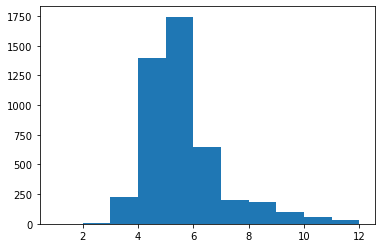

In [25]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [ ]:
iters = simulate_robust(G, W, 5, range(N), 0.8, True, True, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 6    acc: 4.8                                    
Result 5: 5    acc: 4.833333333333333                      
Result 6: 4    acc: 4.714285714285714                      
Result 7: 4    acc: 4.625                                  
Result 8: 4    acc: 4.555555555555555                      
Result 9: 4    acc: 4.5                                    
Result 10: 4    acc: 4.454545454545454                     
Result 11: 6    acc: 4.583333333333333                     
Result 12: 6    acc: 4.6923076923076925                    
Result 13: 5    acc: 4.714285714285714                     
Result 14: 3    acc: 4.6                                   
Result 15: 3    acc: 4.5                                   
Result 16: 3    acc: 4.411764705882353  

In [ ]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()